Konfigurasjon satt. Artefakter lagres til: artifacts/01_probe_baseline
Kjører på: cuda


100%|██████████| 170M/170M [00:06<00:00, 24.9MB/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Data lastet. Train size: 50000, Test size: 10000
Starter trening av Probe i 50 epoker...


/tmp/ipykernel_44655/3732683341.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Epoke 01 | Loss: 1.3300 | Train Acc: 0.5177 | Test Acc: 0.5576
Epoke 02 | Loss: 0.8620 | Train Acc: 0.6954 | Test Acc: 0.7050
Epoke 03 | Loss: 0.6819 | Train Acc: 0.7611 | Test Acc: 0.7697
Epoke 04 | Loss: 0.5763 | Train Acc: 0.7986 | Test Acc: 0.7968
Epoke 05 | Loss: 0.5055 | Train Acc: 0.8253 | Test Acc: 0.7652
Epoke 06 | Loss: 0.4481 | Train Acc: 0.8448 | Test Acc: 0.7963
Epoke 07 | Loss: 0.4063 | Train Acc: 0.8587 | Test Acc: 0.8419
Epoke 08 | Loss: 0.3740 | Train Acc: 0.8707 | Test Acc: 0.8462
Epoke 09 | Loss: 0.3344 | Train Acc: 0.8849 | Test Acc: 0.8603
Epoke 10 | Loss: 0.3128 | Train Acc: 0.8911 | Test Acc: 0.8686
Epoke 11 | Loss: 0.2910 | Train Acc: 0.9000 | Test Acc: 0.8656
Epoke 12 | Loss: 0.2648 | Train Acc: 0.9082 | Test Acc: 0.8768
Epoke 13 | Loss: 0.2487 | Train Acc: 0.9133 | Test Acc: 0.8928
Epoke 14 | Loss: 0.2323 | Train Acc: 0.9204 | Test Acc: 0.8854
Epoke 15 | Loss: 0.2120 | Train Acc: 0.9260 | Test Acc: 0.8922
Epoke 16 | Loss: 0.1998 | Train Acc: 0.9292 | Test Acc:

/tmp/ipykernel_44655/3732683341.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT_DIR / "probe_best.pth", map_location=device))


Targets (både logits og probs) lagret til: artifacts/01_probe_baseline/probe_targets.pt
Heatmap lagret til: artifacts/01_probe_baseline/probe_distribution_heatmap.png


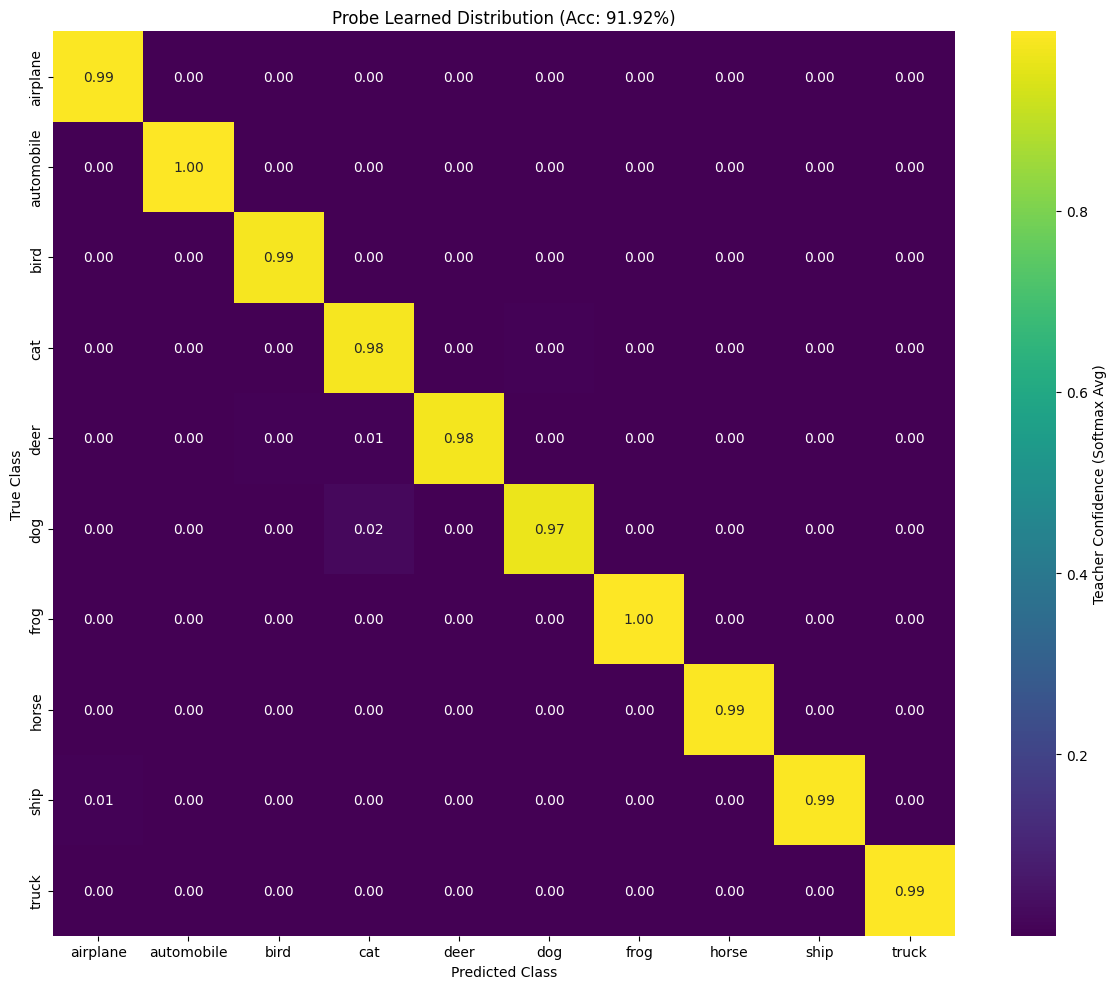

In [1]:
# === CELL 1 (Imports) ===
import os
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# === CELL 2 (Configuration) ===
# --- Konfigurasjon ---
EXPERIMENT_NAME = "01_probe_baseline"
DATA_DIR = Path("./data")
ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Opprett mapper
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparametere
# Vi bruker 50 epoker for å sikre en veldig sterk "Lærer" (Probe).
# Dette tilsvarer den "sterke sonden" (v2) fra det gamle repoet.
EPOCHS = 50 
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt. Artefakter lagres til: {ARTIFACTS_DIR}")

# === CELL 3 (Reproducibility) ===
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# === CELL 4 (Data Loading) ===
# Samme transformasjoner som originalt repo
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Eval transform (ingen augmentering) for validering OG ekstraksjon av targets
eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Datasets
train_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
# Vi trenger treningssettet uten augmentering for å hente ut "sannheten" modellen har lært
train_ds_eval = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=eval_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

# Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_eval_loader = DataLoader(train_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Data lastet. Train size: {len(train_ds)}, Test size: {len(test_ds)}")

# === CELL 5 (Model Definition) ===
def make_cifar_resnet18(num_classes=10):
    """
    Standard ResNet18 tilpasset CIFAR-10 (slik som i originalt repo).
    Fjerner maxpool og endrer første conv til 3x3 kernel.
    """
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

model = make_cifar_resnet18(NUM_CLASSES).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
criterion = nn.CrossEntropyLoss()

# === CELL 6 (Training & Eval Functions) ===
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.autocast(device_type="cuda" if device.type == "cuda" else "cpu", enabled=USE_AMP):
            logits = model(x)
            loss = criterion(logits, y)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
        
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
    return correct / total

# === CELL 7 (Main Training Loop) ===
print(f"Starter trening av Probe i {EPOCHS} epoker...")
best_acc = 0.0
stats = {"train_loss": [], "train_acc": [], "test_acc": []}
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_acc = evaluate(model, test_loader)
    
    stats["train_loss"].append(t_loss)
    stats["train_acc"].append(t_acc)
    stats["test_acc"].append(val_acc)
    
    # Lagre beste modell
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), CKPT_DIR / "probe_best.pth")
        
    print(f"Epoke {epoch:02d} | Loss: {t_loss:.4f} | Train Acc: {t_acc:.4f} | Test Acc: {val_acc:.4f}")

total_time = time.time() - start_time
print(f"Ferdig! Beste Test Acc: {best_acc:.4f}. Tid: {total_time/60:.1f} min.")

# Lagre slutt-statistikk
with open(ARTIFACTS_DIR / "training_stats.json", "w") as f:
    json.dump(stats, f, indent=2)

# === CELL 8 (Extract Stats / Targets) ===
# Her genererer vi "Sannheten" som de andre eksperimentene skal bruke.
# Vi gjør det nøyaktig som i originalt repo:
# - avg_probs: Gjennomsnitt av softmax (for Exp 3a)
# - avg_logits: Gjennomsnitt av rå logits (for Exp 3b, 4, 5)

print("Laster beste modell for å generere targets...")
model.load_state_dict(torch.load(CKPT_DIR / "probe_best.pth", map_location=device))
model.eval()

sum_probs = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.float64, device=device)
sum_logits = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.float64, device=device)
counts = torch.zeros(NUM_CLASSES, dtype=torch.long, device=device)

print("Analyserer treningssettet (eval-modus)...")
with torch.no_grad():
    for x, y in train_eval_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        
        # Akkumuler per klasse
        for c in range(NUM_CLASSES):
            mask = (y == c)
            if mask.any():
                # sum_probs: brukes av Exp 3a (KL Div)
                sum_probs[c] += probs[mask].sum(dim=0)
                # sum_logits: brukes av Exp 3b, 4, 5 (WMSE)
                sum_logits[c] += logits[mask].sum(dim=0)
                counts[c] += mask.sum()

# Beregn gjennomsnitt
avg_probs = (sum_probs / counts.view(-1, 1).clamp_min(1)).float().cpu()
avg_logits = (sum_logits / counts.view(-1, 1).clamp_min(1)).float().cpu()

# Lagre filene
targets_path = ARTIFACTS_DIR / "probe_targets.pt"
torch.save({
    "class_avg_probs": avg_probs,
    "class_avg_logits": avg_logits,
    "counts": counts.cpu(),
    "classes": CIFAR10_CLASSES
}, targets_path)

print(f"Targets (både logits og probs) lagret til: {targets_path}")

# === CELL 9 (Visualization) ===
# Generer heatmap av sannsynlighetsfordelingen (Final Target Distribution)
# Dette viser hva Læreren mener hver klasse "ligner på".

plt.figure(figsize=(12, 10))
sns.heatmap(
    avg_probs.numpy(),
    xticklabels=CIFAR10_CLASSES,
    yticklabels=CIFAR10_CLASSES,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': 'Teacher Confidence (Softmax Avg)'}
)
plt.title(f"Probe Learned Distribution (Acc: {best_acc:.2%})")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()

heatmap_path = ARTIFACTS_DIR / "probe_distribution_heatmap.png"
plt.savefig(heatmap_path)
print(f"Heatmap lagret til: {heatmap_path}")
plt.show()

In [2]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


Konfigurasjon satt for 02_exp1_baseline.
Artefakter lagres til: artifacts/02_exp1_baseline
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified
Data lastet. Train size: 50000, Test size: 10000
Starter Eksperiment 1: Baseline (Cross-Entropy)
Total Epoker: 300


/tmp/ipykernel_44655/2159489718.py:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Ep 001 | Loss: 1.3300 | TrAcc: 0.518 | TeAcc1: 0.558 | Rank: 1.99 | T: 10s
Ep 010 | Loss: 0.3128 | TrAcc: 0.891 | TeAcc1: 0.869 | Rank: 1.22 | T: 101s
Ep 020 | Loss: 0.1488 | TrAcc: 0.948 | TeAcc1: 0.897 | Rank: 1.17 | T: 200s
Ep 030 | Loss: 0.0826 | TrAcc: 0.971 | TeAcc1: 0.886 | Rank: 1.18 | T: 300s
Ep 040 | Loss: 0.0500 | TrAcc: 0.982 | TeAcc1: 0.912 | Rank: 1.14 | T: 401s
   -> Sjekkpunkt lagret ved epoke 50.
Ep 050 | Loss: 0.0393 | TrAcc: 0.987 | TeAcc1: 0.919 | Rank: 1.13 | T: 498s
Ep 060 | Loss: 0.0338 | TrAcc: 0.988 | TeAcc1: 0.916 | Rank: 1.13 | T: 595s
Ep 070 | Loss: 0.0248 | TrAcc: 0.992 | TeAcc1: 0.921 | Rank: 1.13 | T: 694s
Ep 080 | Loss: 0.0205 | TrAcc: 0.993 | TeAcc1: 0.923 | Rank: 1.12 | T: 793s
Ep 090 | Loss: 0.0187 | TrAcc: 0.993 | TeAcc1: 0.922 | Rank: 1.13 | T: 891s
Ep 100 | Loss: 0.0194 | TrAcc: 0.994 | TeAcc1: 0.922 | Rank: 1.13 | T: 990s
Ep 110 | Loss: 0.0160 | TrAcc: 0.995 | TeAcc1: 0.925 | Rank: 1.12 | T: 1089s
Ep 120 | Loss: 0.0157 | TrAcc: 0.995 | TeAcc1: 0.9

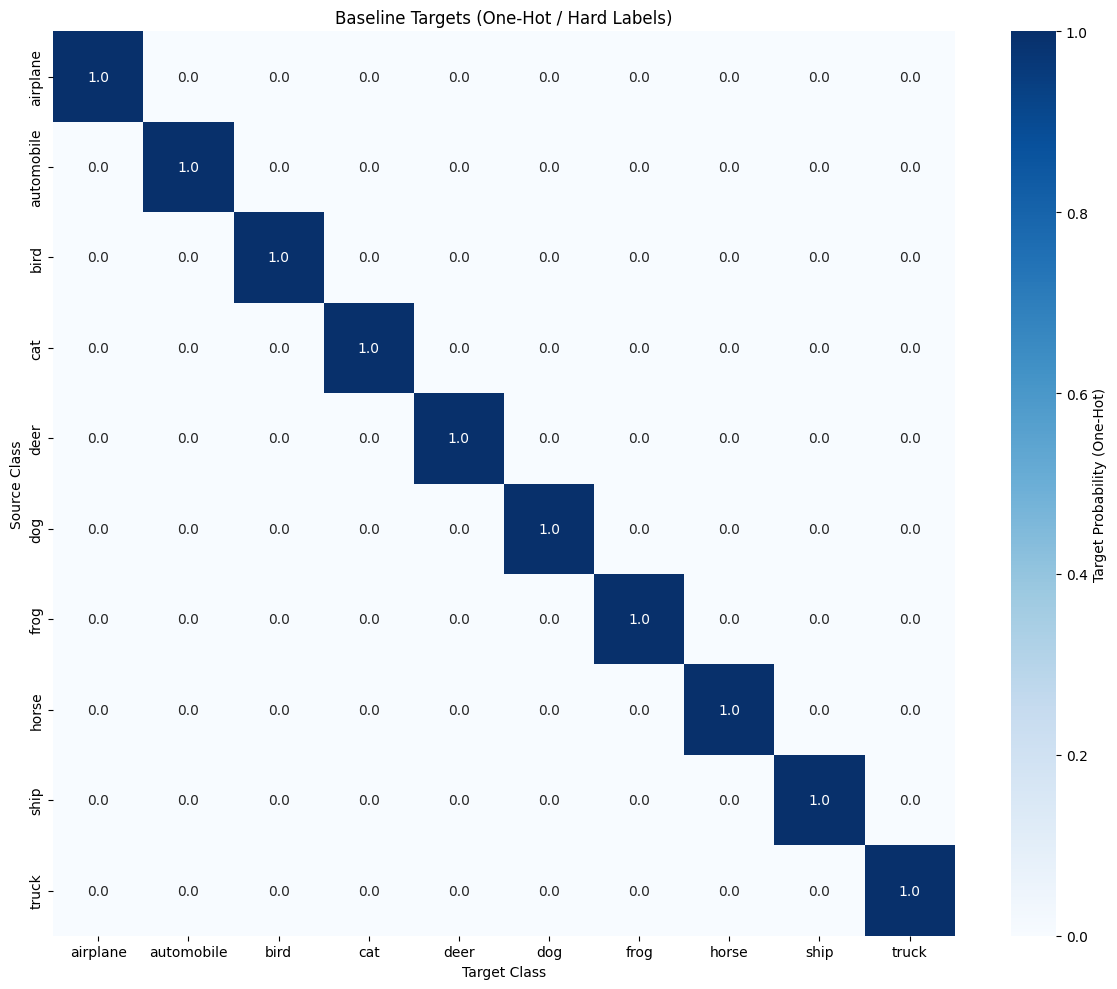

In [3]:
# === CELL 1 (Imports) ===
import os
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# === CELL 2 (Configuration) ===
# --- Konfigurasjon ---
EXPERIMENT_NAME = "02_exp1_baseline"
DATA_DIR = Path("./data")
ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Opprett mapper
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparametere
MAIN_EPOCHS = 300        # Kjører 300 (dekker også behovet for 50)
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {ARTIFACTS_DIR}")

# === CELL 3 (Reproducibility) ===
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# === CELL 4 (Data Loading) ===
# Samme transformasjoner som i det gamle repoet (og probe setup)
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Datasets
train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

# Loaders
train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Data lastet. Train size: {len(train_ds_aug)}, Test size: {len(test_ds)}")

# === CELL 5 (Model Definition) ===
def make_cifar_resnet18(num_classes=10):
    """
    Standard ResNet18 tilpasset CIFAR-10.
    Identisk arkitektur som brukt i Probe og gamle eksperimenter.
    """
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

model = make_cifar_resnet18(NUM_CLASSES).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
criterion = nn.CrossEntropyLoss()

# === CELL 6 (Evaluation Utilities) ===
@torch.no_grad()
def evaluate(model, loader):
    """
    Evaluerer modellen og returnerer:
    - Top-1 Accuracy
    - Top-2 Accuracy
    - Mean Rank (Gjennomsnittlig rangering av sann klasse)
    """
    model.eval()
    total = 0
    correct_top1 = 0
    correct_top2 = 0
    ranks_sum = 0.0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        
        # Sannsynligheter
        probs = F.softmax(logits, dim=1)
        
        # Top-k
        top2 = probs.topk(2, dim=1).indices
        pred_top1 = top2[:, 0]
        
        correct_top1 += (pred_top1 == y).sum().item()
        correct_top2 += ((top2[:, 0] == y) | (top2[:, 1] == y)).sum().item()
        
        # Mean Rank calculation
        # argsort descending gir indeksene sortert etter confidence.
        # Vi finner hvor sann klasse (y) befinner seg i denne sorteringen.
        # .nonzero()[:, 1] gir kolonne-indeksen (rangeringen, 0-indeksert)
        sorted_indices = logits.argsort(dim=1, descending=True)
        ranks = (sorted_indices == y.view(-1, 1)).nonzero()[:, 1] + 1
        ranks_sum += ranks.float().sum().item()
        
        total += x.size(0)
        
    return {
        "acc1": correct_top1 / total,
        "acc2": correct_top2 / total,
        "mean_rank": ranks_sum / total
    }

# === CELL 7 (Training Loop) ===
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.autocast(device_type="cuda" if device.type == "cuda" else "cpu", enabled=USE_AMP):
            logits = model(x)
            loss = criterion(logits, y)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
        
    return total_loss / total, correct / total

# === CELL 8 (Run Experiment) ===
print(f"Starter Eksperiment 1: Baseline (Cross-Entropy)")
print(f"Total Epoker: {MAIN_EPOCHS}")

best_acc = 0.0
history = {"train_loss": [], "train_acc": [], "test_acc1": [], "test_acc2": [], "mean_rank": []}
start_time = time.time()

for epoch in range(1, MAIN_EPOCHS + 1):
    t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_metrics = evaluate(model, test_loader)
    
    # Lagre historikk
    history["train_loss"].append(t_loss)
    history["train_acc"].append(t_acc)
    history["test_acc1"].append(val_metrics["acc1"])
    history["test_acc2"].append(val_metrics["acc2"])
    history["mean_rank"].append(val_metrics["mean_rank"])
    
    # Lagre beste modell
    if val_metrics["acc1"] > best_acc:
        best_acc = val_metrics["acc1"]
        torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_best.pth")
    
    # Lagre sjekkpunkt ved 50 epoker (for sammenligning)
    if epoch == 50:
        torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_epoch50.pth")
        print(f"   -> Sjekkpunkt lagret ved epoke 50.")

    # Logging
    if epoch % 10 == 0 or epoch == 1:
        dt = time.time() - start_time
        print(f"Ep {epoch:03d} | Loss: {t_loss:.4f} | TrAcc: {t_acc:.3f} | "
              f"TeAcc1: {val_metrics['acc1']:.3f} | Rank: {val_metrics['mean_rank']:.2f} | T: {dt:.0f}s")

total_time = time.time() - start_time
print(f"\nFerdig! Beste Test Acc: {best_acc:.4f}. Tid: {total_time/60:.1f} min.")

# === CELL 9 (Save Results & Artifacts) ===
# 1. Lagre treningshistorikk
results_file = ARTIFACTS_DIR / "results.json"
with open(results_file, "w") as f:
    json.dump({
        "config": {
            "epochs": MAIN_EPOCHS,
            "lr": LR,
            "batch_size": BATCH_SIZE,
            "seed": SEED
        },
        "best_acc": best_acc,
        "history": history
    }, f, indent=2)
print(f"Resultater lagret til {results_file}")

# 2. Generer Target Distribution Heatmap
# Siden dette er Baseline (Cross Entropy), er målet One-Hot.
# Det betyr at 'Airplane' skal være 100% 'Airplane' og 0% alt annet.
# Target Distribution er dermed en Identitetsmatrise.

print("Genererer Heatmap for Target Distribution...")
target_matrix = torch.eye(NUM_CLASSES).numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(
    target_matrix,
    xticklabels=CIFAR10_CLASSES,
    yticklabels=CIFAR10_CLASSES,
    annot=True,
    fmt=".1f", # Vis 1.0 eller 0.0
    cmap="Blues",
    cbar_kws={'label': 'Target Probability (One-Hot)'}
)
plt.title(f"Baseline Targets (One-Hot / Hard Labels)")
plt.xlabel("Target Class")
plt.ylabel("Source Class")
plt.tight_layout()

heatmap_path = ARTIFACTS_DIR / "target_distribution_heatmap.png"
plt.savefig(heatmap_path)
print(f"Heatmap lagret til: {heatmap_path}")
plt.show()

In [4]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


Konfigurasjon satt for 03_exp2_sbls.
Artefakter lagres til: artifacts/03_exp2_sbls
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified
Genererer Heatmap for SBLS Targets...
Heatmap lagret til: artifacts/03_exp2_sbls/target_distribution_heatmap.png


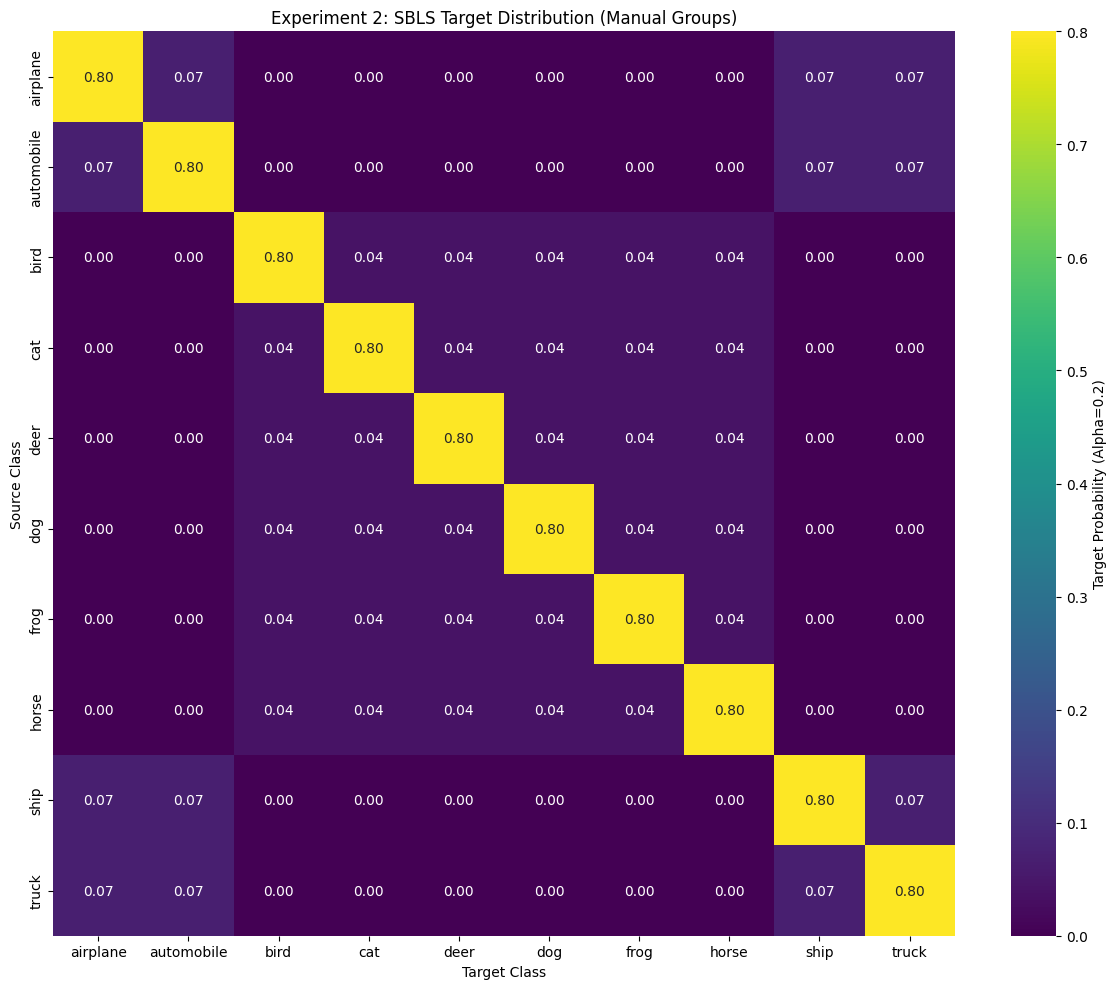


  STARTER KJØRING: 50 EPOKER


/tmp/ipykernel_44655/1840078635.py:276: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Ep 001 | Loss: 1.6070 | TrAcc: 0.501 | TeAcc1: 0.556 | Rank: 1.95 | T: 10s
Ep 010 | Loss: 0.9748 | TrAcc: 0.888 | TeAcc1: 0.858 | Rank: 1.26 | T: 100s
Ep 020 | Loss: 0.8790 | TrAcc: 0.944 | TeAcc1: 0.895 | Rank: 1.18 | T: 198s
Ep 030 | Loss: 0.8378 | TrAcc: 0.968 | TeAcc1: 0.906 | Rank: 1.18 | T: 294s
Ep 040 | Loss: 0.8200 | TrAcc: 0.978 | TeAcc1: 0.915 | Rank: 1.17 | T: 392s
Ep 050 | Loss: 0.8053 | TrAcc: 0.987 | TeAcc1: 0.918 | Rank: 1.16 | T: 492s
Ferdig med 50 epoker. Beste Acc: 0.9179. Data lagret i artifacts/03_exp2_sbls/run_50ep

  STARTER KJØRING: 300 EPOKER
Ep 001 | Loss: 1.6144 | TrAcc: 0.492 | TeAcc1: 0.547 | Rank: 2.29 | T: 10s
Ep 010 | Loss: 0.9683 | TrAcc: 0.892 | TeAcc1: 0.867 | Rank: 1.24 | T: 101s
Ep 020 | Loss: 0.8756 | TrAcc: 0.945 | TeAcc1: 0.876 | Rank: 1.27 | T: 203s
Ep 030 | Loss: 0.8362 | TrAcc: 0.970 | TeAcc1: 0.916 | Rank: 1.16 | T: 300s
Ep 040 | Loss: 0.8170 | TrAcc: 0.980 | TeAcc1: 0.918 | Rank: 1.17 | T: 399s
Ep 050 | Loss: 0.8093 | TrAcc: 0.984 | TeAcc1: 0

In [5]:
# === CELL 1 (Complete Experiment Code) ===
import os
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON & OPPSETT
# ==========================================
EXPERIMENT_NAME = "03_exp2_sbls"
DATA_DIR = Path("./data")
BASE_ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Opprett mapper
BASE_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparametere
RUNS = [50, 300]        # Vi kjører både kort (50) og lang (300) trening
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True

# SBLS Spesifikke parametere
ALPHA = 0.2             # Smoothing mass (Hvor mye sannsynlighet vi tar fra true class)
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {BASE_ARTIFACTS_DIR}")

# ==========================================
# 2. REPRODUSERBARHET
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# ==========================================
# 3. DATA LOADING
# ==========================================
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ==========================================
# 4. MODELL DEFINISJON
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# ==========================================
# 5. SBLS LOGIKK (Likhetsmatrise & Targets)
# ==========================================
def build_similarity_matrix_cifar10():
    """
    Bygger en manuell likhetsmatrise basert på superklasser i CIFAR-10.
    Animals: bird, cat, deer, dog, frog, horse (indices 2,3,4,5,6,7)
    Vehicles: airplane, automobile, ship, truck (indices 0,1,8,9)
    """
    C = len(CIFAR10_CLASSES)
    S = torch.zeros(C, C)
    
    animals = {2, 3, 4, 5, 6, 7}
    vehicles = {0, 1, 8, 9}
    
    for i in range(C):
        for j in range(C):
            if i == j:
                S[i, j] = 0.0 # Ingen selv-likhet her (håndteres av alpha i target-generering)
            else:
                if (i in animals and j in animals) or (i in vehicles and j in vehicles):
                    S[i, j] = 1.0 # "Lik"
                else:
                    S[i, j] = 0.0 # "Ulik"
                    
    # Normaliser rader slik at summen av naboer blir 1.0
    row_sums = S.sum(dim=1, keepdim=True).clamp_min(1e-8)
    S = S / row_sums
    return S

# Opprett matrisen og legg på device
S_MAT = build_similarity_matrix_cifar10().to(device)

def make_soft_targets(y, S, alpha=0.2, num_classes=10):
    """
    Genererer soft targets on-the-fly for en batch.
    y: (B,) labels
    S: (C, C) similarity matrix
    alpha: Hvor mye masse som skal fordeles til naboer.
    """
    B = y.shape[0]
    # Start med standard one-hot
    T = torch.zeros(B, num_classes, device=y.device)
    T.scatter_(1, y.view(-1, 1), 1.0)
    
    if alpha <= 0:
        return T
    
    # Reduser sannsynligheten for sann klasse
    T = T * (1.0 - alpha)
    
    # Hent nabo-fordeling fra S-matrisen
    # S[y] velger radene som tilsvarer labelene i batchen -> (B, C)
    neighbor_dist = S[y]
    
    # Sjekk om noen klasser ikke har naboer (row sums ~ 0) -> fallback til uniform distribution
    row_sums = neighbor_dist.sum(dim=1, keepdim=True)
    fallback = (row_sums < 1e-7).float()
    
    if fallback.any():
        # Fordel alpha uniformt over alle ANDRE klasser enn seg selv
        uniform = torch.ones_like(neighbor_dist) / (num_classes - 1)
        uniform.scatter_(1, y.view(-1, 1), 0.0)
        neighbor_dist = torch.where(fallback.bool(), uniform, neighbor_dist)
        
    # Legg til alpha-massen fordelt på naboer
    T = T + alpha * neighbor_dist
    return T

def soft_ce_loss(logits, soft_targets):
    """Cross Entropy med soft targets (probabilities)."""
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1).mean()

# ==========================================
# 6. VISUALISERING AV TARGETS
# ==========================================
# Vi visualiserer hvordan target-distribusjonen ser ut for hver klasse
# Dette tilsvarer "Target Distribution Heatmap" kravet.
print("Genererer Heatmap for SBLS Targets...")

# Lag en dummy batch med en av hver klasse for å visualisere matrisen
dummy_y = torch.arange(NUM_CLASSES, device=device)
dummy_targets = make_soft_targets(dummy_y, S_MAT, alpha=ALPHA, num_classes=NUM_CLASSES)

plt.figure(figsize=(12, 10))
sns.heatmap(
    dummy_targets.cpu().numpy(),
    xticklabels=CIFAR10_CLASSES,
    yticklabels=CIFAR10_CLASSES,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': f'Target Probability (Alpha={ALPHA})'}
)
plt.title(f"Experiment 2: SBLS Target Distribution (Manual Groups)")
plt.xlabel("Target Class")
plt.ylabel("Source Class")
plt.tight_layout()

heatmap_path = BASE_ARTIFACTS_DIR / "target_distribution_heatmap.png"
plt.savefig(heatmap_path)
print(f"Heatmap lagret til: {heatmap_path}")
plt.show()

# Lagre selve matrisen også
torch.save(dummy_targets.cpu(), BASE_ARTIFACTS_DIR / "sbls_target_matrix.pt")

# ==========================================
# 7. TRENINGS- OG EVALUERINGSFUNKSJONER
# ==========================================
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.autocast(device_type="cuda" if device.type == "cuda" else "cpu", enabled=USE_AMP):
            logits = model(x)
            # Generer targets dynamisk basert på SBLS logikk
            soft_targets = make_soft_targets(y, S_MAT, alpha=ALPHA, num_classes=NUM_CLASSES)
            loss = soft_ce_loss(logits, soft_targets)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
        
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct_top1 = 0
    correct_top2 = 0
    ranks_sum = 0.0
    total = 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        
        # Top-k metrics
        top2 = probs.topk(2, dim=1).indices
        pred_top1 = top2[:, 0]
        correct_top1 += (pred_top1 == y).sum().item()
        correct_top2 += ((top2[:, 0] == y) | (top2[:, 1] == y)).sum().item()
        
        # Mean Rank
        sorted_indices = logits.argsort(dim=1, descending=True)
        ranks = (sorted_indices == y.view(-1, 1)).nonzero()[:, 1] + 1
        ranks_sum += ranks.float().sum().item()
        
        total += x.size(0)
        
    return {
        "acc1": correct_top1 / total,
        "acc2": correct_top2 / total,
        "mean_rank": ranks_sum / total
    }

# ==========================================
# 8. HOVEDLØKKE (RUNNER)
# ==========================================
for max_epochs in RUNS:
    print(f"\n{'='*40}")
    print(f"  STARTER KJØRING: {max_epochs} EPOKER")
    print(f"{'='*40}")
    
    # Initier for denne kjøringen
    run_dir = BASE_ARTIFACTS_DIR / f"run_{max_epochs}ep"
    run_dir.mkdir(exist_ok=True)
    
    model = make_cifar_resnet18(NUM_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "test_acc1": [], "test_acc2": [], "mean_rank": []}
    start_time = time.time()
    
    for epoch in range(1, max_epochs + 1):
        t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, scaler)
        metrics = evaluate(model, test_loader)
        
        history["train_loss"].append(t_loss)
        history["train_acc"].append(t_acc)
        history["test_acc1"].append(metrics["acc1"])
        history["test_acc2"].append(metrics["acc2"])
        history["mean_rank"].append(metrics["mean_rank"])
        
        if metrics["acc1"] > best_acc:
            best_acc = metrics["acc1"]
            torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_{max_epochs}ep_best.pth")
            
        if epoch % 10 == 0 or epoch == 1:
            elapsed = time.time() - start_time
            print(f"Ep {epoch:03d} | Loss: {t_loss:.4f} | TrAcc: {t_acc:.3f} | "
                  f"TeAcc1: {metrics['acc1']:.3f} | Rank: {metrics['mean_rank']:.2f} | T: {elapsed:.0f}s")
            
    # Lagre resultater for denne kjøringen
    res_file = run_dir / "results.json"
    with open(res_file, "w") as f:
        json.dump({
            "config": {
                "epochs": max_epochs,
                "alpha": ALPHA,
                "lr": LR
            },
            "best_acc": best_acc,
            "history": history
        }, f, indent=2)
        
    # Lagre plott av trening
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.title(f"Training Loss ({max_epochs} epochs) - SBLS")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(run_dir / "loss_curve.png")
    plt.close()
    
    print(f"Ferdig med {max_epochs} epoker. Beste Acc: {best_acc:.4f}. Data lagret i {run_dir}")

print(f"\nAlle kjøringer fullført for {EXPERIMENT_NAME}!")

In [6]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


Konfigurasjon satt for 04_exp3a_static_probs.
Artefakter lagres til: artifacts/04_exp3a_static_probs
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_44655/2332330834.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)


Lastet targets med form: torch.Size([10, 10])
Heatmap lagret til: artifacts/04_exp3a_static_probs/target_distribution_heatmap.png


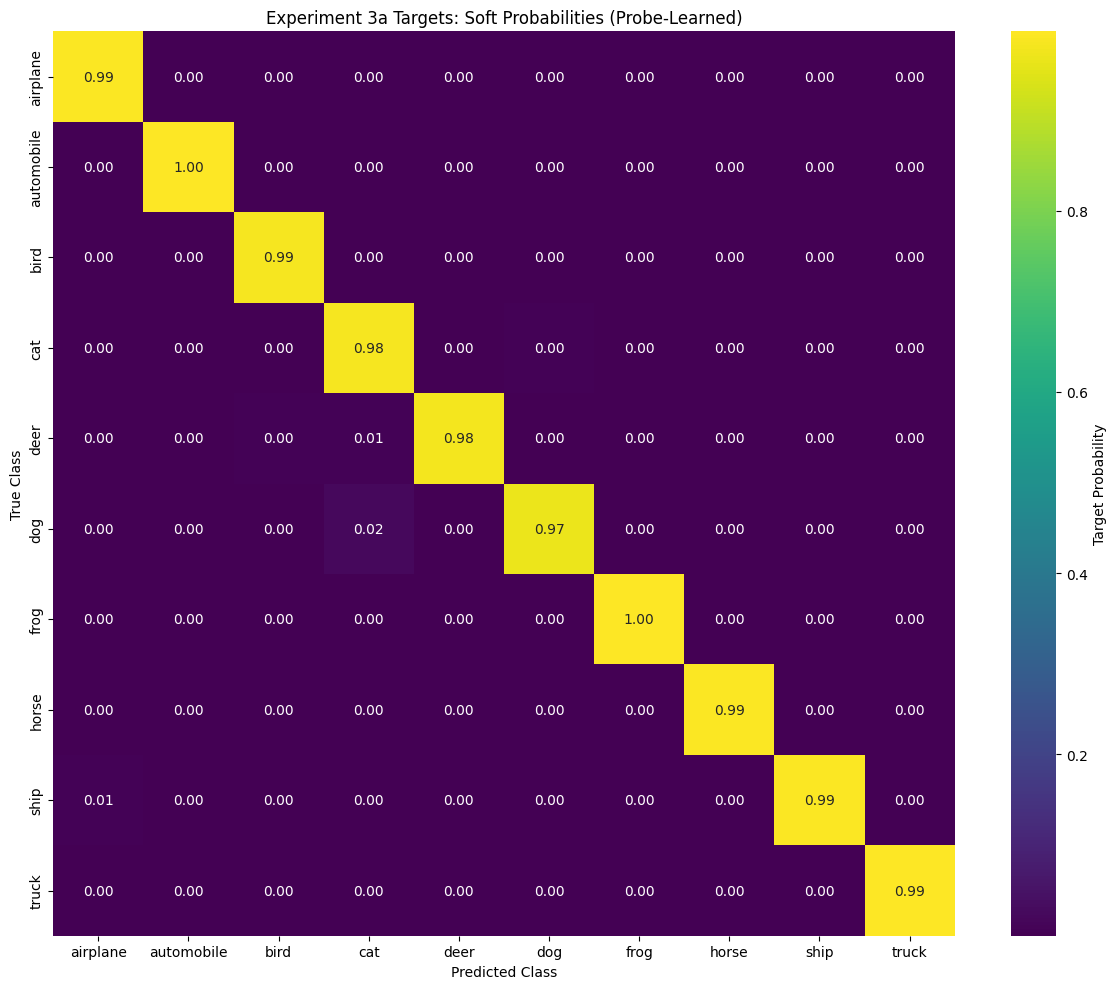


  STARTER KJØRING: 50 EPOKER


/tmp/ipykernel_44655/2332330834.py:234: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Ep 001 | Loss: 1.2688 | TrAcc: 0.520 | TeAcc1: 0.484 | Rank: 2.24 | T: 11s
Ep 010 | Loss: 0.2948 | TrAcc: 0.892 | TeAcc1: 0.859 | Rank: 1.23 | T: 99s
Ep 020 | Loss: 0.1391 | TrAcc: 0.951 | TeAcc1: 0.892 | Rank: 1.17 | T: 196s
Ep 030 | Loss: 0.0765 | TrAcc: 0.974 | TeAcc1: 0.904 | Rank: 1.15 | T: 294s
Ep 040 | Loss: 0.0487 | TrAcc: 0.983 | TeAcc1: 0.914 | Rank: 1.14 | T: 393s
Ep 050 | Loss: 0.0384 | TrAcc: 0.987 | TeAcc1: 0.917 | Rank: 1.14 | T: 488s
Ferdig med 50 epoker. Beste Acc: 0.9189. Data lagret i artifacts/04_exp3a_static_probs/run_50ep

  STARTER KJØRING: 300 EPOKER
Ep 001 | Loss: 1.2802 | TrAcc: 0.509 | TeAcc1: 0.484 | Rank: 2.35 | T: 10s
Ep 010 | Loss: 0.2824 | TrAcc: 0.898 | TeAcc1: 0.878 | Rank: 1.21 | T: 101s
Ep 020 | Loss: 0.1362 | TrAcc: 0.952 | TeAcc1: 0.902 | Rank: 1.16 | T: 201s
Ep 030 | Loss: 0.0788 | TrAcc: 0.971 | TeAcc1: 0.917 | Rank: 1.13 | T: 298s
Ep 040 | Loss: 0.0488 | TrAcc: 0.983 | TeAcc1: 0.911 | Rank: 1.15 | T: 395s
Ep 050 | Loss: 0.0353 | TrAcc: 0.988 | T

In [7]:
# === CELL 1 (Imports) ===
import os
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# === CELL 2 (Configuration) ===
# --- Konfigurasjon ---
EXPERIMENT_NAME = "04_exp3a_static_probs"
DATA_DIR = Path("./data")
BASE_ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Sti til Teacher Targets (fra 01_setup_probe)
TARGETS_PATH = Path("./artifacts/01_probe_baseline/probe_targets.pt")

# Opprett mapper
BASE_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparametere
RUNS = [50, 300]  # Vi skal kjøre to varianter: 50 epoker og 300 epoker
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True

# Exp 3a Spesifikke parametere (fra gammel kode)
KL_EPS = 1e-8           # Gulv for numerisk stabilitet
ONEHOT_MIX_EPS = 0.10   # Hvor mye "hard" one-hot vi blander inn i soft-targets (0.10 = 10%)
CE_ANCHOR = 0.0         # Lite anker mot standard CE loss (0.0 = kun KL)

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {BASE_ARTIFACTS_DIR}")

if not TARGETS_PATH.exists():
    raise FileNotFoundError(f"Fant ikke teacher targets på {TARGETS_PATH}. Har du kjørt 01_setup_probe.ipynb?")

# === CELL 3 (Reproducibility) ===
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# === CELL 4 (Data Loading) ===
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# === CELL 5 (Model Definition) ===
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# === CELL 6 (Custom Loss Function - KL Divergence) ===
class ProbabilityTargetLoss(nn.Module):
    """
    KLDivLoss mellom lærte klasse-gjennomsnittlige soft targets (T) og modellens prediksjoner (P).
    Inkluderer mulighet for å blande inn one-hot (mix_eps) og et CE-anker.
    """
    def __init__(self, class_avg_probs: torch.Tensor, onehot_mix_eps: float = 0.0, ce_anchor: float = 0.0):
        super().__init__()
        # T er en matrise [NumClasses, NumClasses] hvor rad 'c' er target-fordelingen for klasse 'c'.
        self.register_buffer("T", class_avg_probs)
        self.onehot_mix_eps = float(onehot_mix_eps)
        self.ce_anchor = float(ce_anchor)
        self.kldiv = nn.KLDivLoss(reduction="batchmean")
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, y):
        # 1. Hent targets basert på sann klasse y
        targets = self.T[y]  # (B, C)

        # 2. Bland inn One-Hot hvis ønsket (Stabilisering)
        if self.onehot_mix_eps > 0.0:
            one_hot = torch.zeros_like(targets)
            one_hot.scatter_(1, y.view(-1, 1), 1.0)
            targets = (1.0 - self.onehot_mix_eps) * targets + self.onehot_mix_eps * one_hot
            
            # Normaliser og clamp
            targets = torch.clamp(targets, min=KL_EPS)
            targets = targets / targets.sum(dim=1, keepdim=True)

        # 3. Beregn KL Divergens
        # PyTorch KLDiv krever log-probabilities som input, og probabilities som target
        log_probs = F.log_softmax(logits, dim=1)
        loss = self.kldiv(log_probs, targets)

        # 4. Legg til CE Anker hvis ønsket
        if self.ce_anchor > 0.0:
            loss += self.ce_anchor * self.ce(logits, y)

        return loss

# === CELL 7 (Load & Visualize Targets) ===
# Last inn data generert av Sonde-modellen
payload = torch.load(TARGETS_PATH, map_location=device)
class_avg_probs = payload["class_avg_probs"] # Dette er soft targets

print(f"Lastet targets med form: {class_avg_probs.shape}")

# Visualiser hva modellen skal prøve å lære (Target Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(
    class_avg_probs.cpu().numpy(),
    xticklabels=CIFAR10_CLASSES,
    yticklabels=CIFAR10_CLASSES,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': 'Target Probability'}
)
plt.title(f"Experiment 3a Targets: Soft Probabilities (Probe-Learned)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()

heatmap_path = BASE_ARTIFACTS_DIR / "target_distribution_heatmap.png"
plt.savefig(heatmap_path)
print(f"Heatmap lagret til: {heatmap_path}")
plt.show()

# === CELL 8 (Training & Eval Functions) ===
def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.autocast(device_type="cuda" if device.type == "cuda" else "cpu", enabled=USE_AMP):
            logits = model(x)
            loss = criterion(logits, y)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
        
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct_top1 = 0
    correct_top2 = 0
    ranks_sum = 0.0
    total = 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        
        # Top-k metrics
        top2 = probs.topk(2, dim=1).indices
        pred_top1 = top2[:, 0]
        correct_top1 += (pred_top1 == y).sum().item()
        correct_top2 += ((top2[:, 0] == y) | (top2[:, 1] == y)).sum().item()
        
        # Mean Rank
        sorted_indices = logits.argsort(dim=1, descending=True)
        ranks = (sorted_indices == y.view(-1, 1)).nonzero()[:, 1] + 1
        ranks_sum += ranks.float().sum().item()
        
        total += x.size(0)
        
    return {
        "acc1": correct_top1 / total,
        "acc2": correct_top2 / total,
        "mean_rank": ranks_sum / total
    }

# === CELL 9 (Main Experiment Runner) ===
# Vi kjører loopen for både 50 og 300 epoker som forespurt
for max_epochs in RUNS:
    print(f"\n{'='*40}")
    print(f"  STARTER KJØRING: {max_epochs} EPOKER")
    print(f"{'='*40}")
    
    # Initier for denne kjøringen
    run_dir = BASE_ARTIFACTS_DIR / f"run_{max_epochs}ep"
    run_dir.mkdir(exist_ok=True)
    
    model = make_cifar_resnet18(NUM_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    
    # Sett opp KL-tapsfunksjonen med våre loaded targets
    criterion = ProbabilityTargetLoss(
        class_avg_probs=class_avg_probs, 
        onehot_mix_eps=ONEHOT_MIX_EPS, 
        ce_anchor=CE_ANCHOR
    )
    
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "test_acc1": [], "test_acc2": [], "mean_rank": []}
    start_time = time.time()
    
    for epoch in range(1, max_epochs + 1):
        t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, scaler, criterion)
        metrics = evaluate(model, test_loader)
        
        history["train_loss"].append(t_loss)
        history["train_acc"].append(t_acc)
        history["test_acc1"].append(metrics["acc1"])
        history["test_acc2"].append(metrics["acc2"])
        history["mean_rank"].append(metrics["mean_rank"])
        
        if metrics["acc1"] > best_acc:
            best_acc = metrics["acc1"]
            torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_{max_epochs}ep_best.pth")
            
        if epoch % 10 == 0 or epoch == 1:
            elapsed = time.time() - start_time
            print(f"Ep {epoch:03d} | Loss: {t_loss:.4f} | TrAcc: {t_acc:.3f} | "
                  f"TeAcc1: {metrics['acc1']:.3f} | Rank: {metrics['mean_rank']:.2f} | T: {elapsed:.0f}s")
            
    # Lagre resultater for denne kjøringen
    res_file = run_dir / "results.json"
    with open(res_file, "w") as f:
        json.dump({
            "config": {
                "epochs": max_epochs,
                "onehot_mix_eps": ONEHOT_MIX_EPS,
                "ce_anchor": CE_ANCHOR
            },
            "best_acc": best_acc,
            "history": history
        }, f, indent=2)
        
    # Lagre plott av trening
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.title(f"Training Loss ({max_epochs} epochs)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(run_dir / "loss_curve.png")
    plt.close()
    
    print(f"Ferdig med {max_epochs} epoker. Beste Acc: {best_acc:.4f}. Data lagret i {run_dir}")

print(f"\nAlle kjøringer fullført for {EXPERIMENT_NAME}!")

In [8]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


Konfigurasjon satt for 05_exp3b_static_logits.
Artefakter lagres til: artifacts/05_exp3b_static_logits
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_44655/963210759.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)


Lastet logit-targets med form: torch.Size([10, 10])
Heatmap lagret til: artifacts/05_exp3b_static_logits/target_logits_heatmap.png


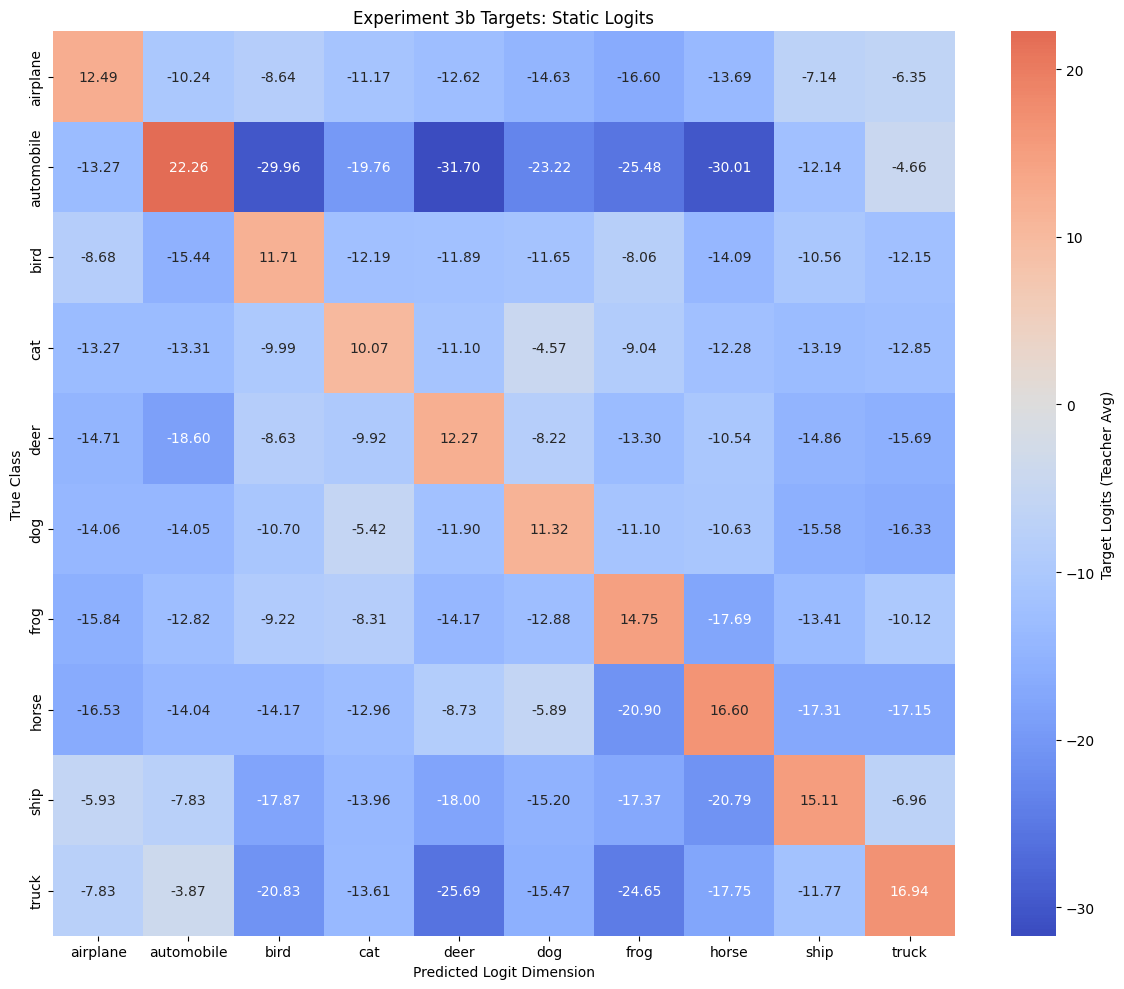


  STARTER KJØRING: 50 EPOKER


/tmp/ipykernel_44655/963210759.py:315: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Ep 001 | Loss: 57.3858 | TrAcc: 0.424 | TeAcc1: 0.509 | Rank: 2.08 | W_mean: 1.00 | T: 10s
Ep 010 | Loss: 13.1179 | TrAcc: 0.855 | TeAcc1: 0.832 | Rank: 1.33 | W_mean: 1.00 | T: 146s
Ep 020 | Loss: 7.0534 | TrAcc: 0.922 | TeAcc1: 0.888 | Rank: 1.21 | W_mean: 1.00 | T: 301s
Ep 030 | Loss: 4.4310 | TrAcc: 0.951 | TeAcc1: 0.899 | Rank: 1.21 | W_mean: 1.00 | T: 453s
Ep 040 | Loss: 3.0347 | TrAcc: 0.967 | TeAcc1: 0.908 | Rank: 1.19 | W_mean: 1.00 | T: 609s
Ep 050 | Loss: 2.2226 | TrAcc: 0.977 | TeAcc1: 0.916 | Rank: 1.17 | W_mean: 1.00 | T: 766s
Ferdig med 50 epoker. Beste Acc: 0.9185. Data lagret i artifacts/05_exp3b_static_logits/run_50ep

  STARTER KJØRING: 300 EPOKER
Ep 001 | Loss: 58.0936 | TrAcc: 0.407 | TeAcc1: 0.539 | Rank: 2.08 | W_mean: 1.00 | T: 11s
Ep 010 | Loss: 13.0465 | TrAcc: 0.856 | TeAcc1: 0.842 | Rank: 1.30 | W_mean: 1.00 | T: 149s
Ep 020 | Loss: 6.9604 | TrAcc: 0.923 | TeAcc1: 0.886 | Rank: 1.23 | W_mean: 1.00 | T: 302s
Ep 030 | Loss: 4.3631 | TrAcc: 0.951 | TeAcc1: 0.90

In [9]:
# === CELL 1 (Complete Experiment 3b Code) ===
import os
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON & OPPSETT
# ==========================================
EXPERIMENT_NAME = "05_exp3b_static_logits"
DATA_DIR = Path("./data")
BASE_ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Sti til Teacher Targets (fra 01_setup_probe)
# Denne filen inneholder "class_avg_logits" som vi trenger her
TARGETS_PATH = Path("./artifacts/01_probe_baseline/probe_targets.pt")

# Opprett mapper
BASE_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparametere
RUNS = [50, 300]        # Kjører både 50 og 300 epoker
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True
GRAD_CLIP_NORM = 1.0    # Hindrer gradient explosion ved WMSE

# Exp 3b Spesifikke parametere (fra gammel kode)
# WMSE weighting from per-class accuracy
WEIGHT_GAMMA = 1.0      # >1 emphasizes strong classes even more
WEIGHT_EPS = 1e-6       # numerical floor before normalization
REWEIGHT_EVERY_EPOCH = True # update weights once per epoch based on validation acc

# Stabilizers
CE_ANCHOR = 0.05        # small CE anchor (5%) for stability
LOGIT_L2 = 0.001        # small L2 on logits to avoid value drift/explosion
CENTER_INPUTS = False   # Keep False as per original best runs

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {BASE_ARTIFACTS_DIR}")

if not TARGETS_PATH.exists():
    raise FileNotFoundError(f"Fant ikke teacher targets på {TARGETS_PATH}. Har du kjørt 01_setup_probe.ipynb?")

# ==========================================
# 2. REPRODUSERBARHET
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# ==========================================
# 3. DATA LOADING
# ==========================================
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
# Vi trenger train_ds_eval (uten aug) for å måle per-class accuracy presist for vekting
train_ds_eval = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=eval_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_eval_loader = DataLoader(train_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ==========================================
# 4. MODELL DEFINISJON
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# ==========================================
# 5. CUSTOM LOSS: LOGIT WMSE (Exp 3b)
# ==========================================
class LogitTargetWMSENLoss(nn.Module):
    """
    Weighted MSE between model logits and class-conditional average logit targets.
    
    Given:
      - target_table: (C, C) average logits from probe (row = true class, col = logit-dim)
      - weights: (C,) per-dimension weights (one per class/logit dimension), updated externally
    """
    def __init__(self, target_table: torch.Tensor, 
                 center_inputs: bool = False, 
                 ce_anchor: float = 0.0, 
                 logit_l2: float = 0.0):
        super().__init__()
        self.register_buffer("T", target_table)  # C x C
        self.center_inputs = bool(center_inputs)
        self.ce_anchor = float(ce_anchor)
        self.logit_l2 = float(logit_l2)
        self._weights = None  # device tensor (C,)
        self.ce_loss_fn = nn.CrossEntropyLoss()

    def set_weights(self, w: torch.Tensor):
        # Normalize weights to mean 1 (keeps scale consistent across epochs)
        w = w / w.mean().clamp_min(1e-8)
        self._weights = w.detach()

    def forward(self, logits, y):
        assert self._weights is not None, "Call set_weights(w) before forward."
        
        # 1. Hent targets for batchen
        targets = self.T[y]  # (B, C)
        x = logits
        
        if self.center_inputs:
            x = x - x.mean(dim=1, keepdim=True)

        # 2. Weighted MSE across dimensions (classes)
        # loss_i = mean_c w_c * (x_ic - t_ic)^2
        diff2 = (x - targets) ** 2
        weighted = diff2 * self._weights.view(1, -1)
        wmse = weighted.mean()

        # 3. Logit L2 Regularization (hindrer eksplosjon)
        if self.logit_l2 > 0.0:
            wmse = wmse + self.logit_l2 * (x.pow(2).mean())

        # 4. CE Anchor (Stabilisering)
        if self.ce_anchor > 0.0:
            wmse = wmse + self.ce_anchor * self.ce_loss_fn(logits, y)

        return wmse

# ==========================================
# 6. HJELPEFUNKSJONER (Vekting & Metrics)
# ==========================================
@torch.no_grad()
def per_class_accuracy(model, loader, num_classes=NUM_CLASSES):
    """Beregner accuracy per klasse. Brukes for å vekte WMSE."""
    model.eval()
    correct = torch.zeros(num_classes, device=device)
    counts  = torch.zeros(num_classes, device=device)
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        
        for c in range(num_classes):
            mask = (y == c)
            if mask.any():
                counts[c] += mask.sum()
                correct[c] += (pred[mask] == c).sum()
                
    acc = correct.float() / counts.clamp_min(1)
    return acc

@torch.no_grad()
def weights_from_acc(acc: torch.Tensor, gamma: float = 1.0, eps: float = 1e-6):
    """
    Konverterer accuracy til vekter. Høyere accuracy -> Høyere vekt.
    Dette gjør at vi stoler mer på logit-verdier for klasser modellen mestrer.
    """
    base = (acc.clamp_min(0.0) + eps).pow(gamma)
    w = base / base.mean().clamp_min(1e-8)
    return w

@torch.no_grad()
def uniform_weights(num_classes=NUM_CLASSES):
    return torch.ones(num_classes, dtype=torch.float32, device=device)

# ==========================================
# 7. LAST INN OG VISUALISER TARGETS
# ==========================================
payload = torch.load(TARGETS_PATH, map_location=device)
# VIKTIG: Exp 3b bruker LOGITS, ikke PROBS
class_avg_logits = payload["class_avg_logits"] 

print(f"Lastet logit-targets med form: {class_avg_logits.shape}")

# Visualiser Logits (OBS: Logits kan være negative)
plt.figure(figsize=(12, 10))
sns.heatmap(
    class_avg_logits.cpu().numpy(),
    xticklabels=CIFAR10_CLASSES,
    yticklabels=CIFAR10_CLASSES,
    annot=True,
    fmt=".2f",
    cmap="coolwarm", # Coolwarm er bra for positive/negative verdier
    center=0.0,
    cbar_kws={'label': 'Target Logits (Teacher Avg)'}
)
plt.title(f"Experiment 3b Targets: Static Logits")
plt.xlabel("Predicted Logit Dimension")
plt.ylabel("True Class")
plt.tight_layout()

heatmap_path = BASE_ARTIFACTS_DIR / "target_logits_heatmap.png"
plt.savefig(heatmap_path)
print(f"Heatmap lagret til: {heatmap_path}")
plt.show()

# ==========================================
# 8. TRENINGSFUNKSJONER
# ==========================================
def train_one_epoch(model, loader, optimizer, scaler, criterion, grad_clip=0.0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.autocast(device_type="cuda" if device.type == "cuda" else "cpu", enabled=USE_AMP):
            logits = model(x)
            loss = criterion(logits, y)
            
        scaler.scale(loss).backward()
        
        if grad_clip > 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
        
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct_top1 = 0
    correct_top2 = 0
    ranks_sum = 0.0
    total = 0
    
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        
        # Top-k
        top2 = probs.topk(2, dim=1).indices
        pred_top1 = top2[:, 0]
        correct_top1 += (pred_top1 == y).sum().item()
        correct_top2 += ((top2[:, 0] == y) | (top2[:, 1] == y)).sum().item()
        
        # Mean Rank
        sorted_indices = logits.argsort(dim=1, descending=True)
        ranks = (sorted_indices == y.view(-1, 1)).nonzero()[:, 1] + 1
        ranks_sum += ranks.float().sum().item()
        
        total += x.size(0)
        
    return {
        "acc1": correct_top1 / total,
        "acc2": correct_top2 / total,
        "mean_rank": ranks_sum / total
    }

# ==========================================
# 9. HOVEDLØKKE (RUNNER)
# ==========================================
for max_epochs in RUNS:
    print(f"\n{'='*40}")
    print(f"  STARTER KJØRING: {max_epochs} EPOKER")
    print(f"{'='*40}")
    
    # Initier for denne kjøringen
    run_dir = BASE_ARTIFACTS_DIR / f"run_{max_epochs}ep"
    run_dir.mkdir(exist_ok=True)
    
    model = make_cifar_resnet18(NUM_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    
    # Initialiser Criterion med target-tabellen
    criterion = LogitTargetWMSENLoss(
        target_table=class_avg_logits,
        center_inputs=CENTER_INPUTS,
        ce_anchor=CE_ANCHOR,
        logit_l2=LOGIT_L2
    )
    
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "test_acc1": [], "test_acc2": [], "mean_rank": []}
    weights_history = []
    
    start_time = time.time()
    
    for epoch in range(1, max_epochs + 1):
        # 1. Oppdater vekter basert på presisjon
        if REWEIGHT_EVERY_EPOCH and epoch > 1:
            # Vi bruker train_eval_loader for å se hva modellen faktisk kan på treningsdataene uten støy
            acc_c = per_class_accuracy(model, train_eval_loader, NUM_CLASSES)
            w = weights_from_acc(acc_c, gamma=WEIGHT_GAMMA, eps=WEIGHT_EPS)
        else:
            w = uniform_weights(NUM_CLASSES)
            
        criterion.set_weights(w)
        weights_history.append(w.detach().cpu().tolist())
        
        # 2. Tren
        t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, scaler, criterion, grad_clip=GRAD_CLIP_NORM)
        
        # 3. Evaluer
        metrics = evaluate(model, test_loader)
        
        history["train_loss"].append(t_loss)
        history["train_acc"].append(t_acc)
        history["test_acc1"].append(metrics["acc1"])
        history["test_acc2"].append(metrics["acc2"])
        history["mean_rank"].append(metrics["mean_rank"])
        
        if metrics["acc1"] > best_acc:
            best_acc = metrics["acc1"]
            torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_{max_epochs}ep_best.pth")
            
        if epoch % 10 == 0 or epoch == 1:
            elapsed = time.time() - start_time
            # Logg også gjennomsnittsvekten for å se at systemet lever
            mean_w = w.mean().item()
            print(f"Ep {epoch:03d} | Loss: {t_loss:.4f} | TrAcc: {t_acc:.3f} | "
                  f"TeAcc1: {metrics['acc1']:.3f} | Rank: {metrics['mean_rank']:.2f} | "
                  f"W_mean: {mean_w:.2f} | T: {elapsed:.0f}s")
            
    # Lagre resultater
    res_file = run_dir / "results.json"
    with open(res_file, "w") as f:
        json.dump({
            "config": {
                "epochs": max_epochs,
                "weight_gamma": WEIGHT_GAMMA,
                "ce_anchor": CE_ANCHOR,
                "logit_l2": LOGIT_L2
            },
            "best_acc": best_acc,
            "history": history,
            "final_weights": weights_history[-1] # Lagre siste vekting
        }, f, indent=2)
        
    # Lagre vekthistorikk separat
    with open(run_dir / "weights_history.json", "w") as f:
        json.dump(weights_history, f)
        
    # Lagre plott
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss (WMSE)")
    plt.title(f"Training Loss ({max_epochs} epochs) - Exp 3b")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(run_dir / "loss_curve.png")
    plt.close()
    
    print(f"Ferdig med {max_epochs} epoker. Beste Acc: {best_acc:.4f}. Data lagret i {run_dir}")

print(f"\nAlle kjøringer fullført for {EXPERIMENT_NAME}!")

In [10]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


In [11]:
# === CELL 1 (Complete Experiment 4a Code) ===
import os
import json
import random
import time
from pathlib import Path
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON & OPPSETT
# ==========================================
EXPERIMENT_NAME = "06_exp4a_dynamic_basic"
DATA_DIR = Path("./data")
BASE_ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Startpunkt: Vi bruker Logits lært av Proben (Eksperiment 1 / 01_setup_probe)
# Dette tilsvarer logikken i eks4_2 hvor man lastet "3b" targets som start.
TARGETS_PATH = Path("./artifacts/01_probe_baseline/probe_targets.pt")

# Opprett mapper
BASE_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparametere (Generelt)
RUNS = [50, 300]        # Kjører både 50 og 300 epoker
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True
GRAD_CLIP_NORM = 1.0

# Hyperparametere (Fra eks4_2.ipynb - Dynamic Logic)
MIN_ACC_DIFF = 0.05         # Minimum forskjell i presisjon for at dynamikken skal slå inn
AUTH_BETA = 10.0            # Sigmoid-skarphet for autoritet
TARGET_UPDATE_LR = 0.10     # Steglengde for target-oppdatering (eta)
KAPPA_PUSHBACK = 0.10       # "Push" på eksperten (repulsjon)
TARGET_ANCHOR_GAMMA = 0.01  # Anker mot probe-targets per epoke (hindrer total drift)
TARGET_CLAMP_M = 10.0       # Clamp targets til [-M, M]

# Hyperparametere (Vekting fra 3b som brukes i 4a)
WEIGHT_GAMMA = 1.0
WEIGHT_EPS = 1e-6
CE_ANCHOR = 0.05            # Lite anker for stabilitet
LOGIT_L2 = 0.001            # L2 på logits for å hindre eksplosjon

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {BASE_ARTIFACTS_DIR}")

if not TARGETS_PATH.exists():
    raise FileNotFoundError(f"Fant ikke teacher targets på {TARGETS_PATH}. Har du kjørt 01_setup_probe.ipynb?")

# ==========================================
# 2. REPRODUSERBARHET
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# ==========================================
# 3. DATA LOADING
# ==========================================
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
# Vi trenger eval-loader for training set for å måle presisjon ("Autoritet") før hver epoke
train_ds_eval = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=eval_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_eval_loader = DataLoader(train_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ==========================================
# 4. MODELL DEFINISJON
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# ==========================================
# 5. KJERNE-LOGIKK FOR EKS 4 (Dynamisk Oppdatering)
# ==========================================
# Kopiert og tilpasset fra eks4_2.ipynb

@torch.no_grad()
def update_target_logits(
    T,
    acc,
    T0=None,
    beta=10.0,
    lr=0.10,
    kappa=0.10,
    min_diff=0.05,
    anchor_gamma=0.01,
    clamp_M=10.0
):
    """
    Oppdaterer mål-matrisen T basert på asymmetrisk autoritet (sigmoid).
    - Novise (i) flyttes mot ekspertens syn T[j,i] på relasjonen.
    - (Valgfritt) Ekspert (j) skyves svakt vekk (repulsjon) via kappa.
    - (Valgfritt) Anker mot probe-targets T0 via anchor_gamma.
    - (Valgfritt) Clamp for å hindre drift/eksplosjon.
    """
    C = T.shape[0]
    T_new = T.clone()
    updates_made = 0

    # Iterer alle par
    for i in range(C):          # i = novise
        for j in range(C):      # j = ekspert
            if i == j:
                continue

            diff = acc[j] - acc[i]
            if diff <= min_diff:
                continue

            # Autoritet: p in (0,1)
            p = torch.sigmoid(beta * diff)

            # Ekspertens syn på relasjonen: T[j, i]
            expert_view = T[j, i]
            novice_view = T[i, j]

            # Trekk novisen mot eksperten
            change = lr * p * (expert_view - novice_view)
            T_new[i, j] += change

            # (Valgfritt) pushback: skyv eksperten svakt vekk fra novisen (repulsjon)
            if kappa > 0:
                T_new[j, i] -= kappa * change

            updates_made += 1

    # (Valgfritt) Anker mot probe-targets (hindrer total drift bort fra læreren)
    if T0 is not None and anchor_gamma > 0:
        T_new = (1.0 - anchor_gamma) * T_new + anchor_gamma * T0

    # (Valgfritt) Clamp for stabilitet
    if clamp_M is not None and clamp_M > 0:
        T_new = T_new.clamp(min=-clamp_M, max=clamp_M)

    return T_new, updates_made

# ==========================================
# 6. CUSTOM LOSS & HJELPEFUNKSJONER
# ==========================================

class DynamicTargetWMSE(nn.Module):
    def __init__(self, ce_anchor=0.0, logit_l2=0.0):
        super().__init__()
        self.ce_anchor = ce_anchor
        self.logit_l2 = logit_l2
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, y, current_targets, current_weights):
        # current_targets: (C, C) matrix used for lookup
        # current_weights: (C) vector
        
        # 1. Hent targets for batchen
        batch_targets = current_targets[y] # (B, C)
        
        # 2. WMSE Loss
        # (Logits - Targets)^2 * Weight
        diff = (logits - batch_targets) ** 2
        
        # Expand weights to batch: (1, C) -> (B, C) (broadcasting)
        w_expanded = current_weights.view(1, -1)
        
        # Apply weights: Vi straffer feil hardere på dimensjoner (kolonner) 
        # som modellen er god på (høy vekt).
        weighted_mse = (diff * w_expanded).mean()
        loss = weighted_mse
        
        # 3. Stabilisering
        if self.ce_anchor > 0:
            loss += self.ce_anchor * self.ce(logits, y)
            
        if self.logit_l2 > 0:
            loss += self.logit_l2 * (logits ** 2).mean()
            
        return loss

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
    return correct / total

@torch.no_grad()
def per_class_accuracy(model, loader, num_classes=10):
    model.eval()
    correct = torch.zeros(num_classes, device=device)
    counts = torch.zeros(num_classes, device=device)
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        pred = model(x).argmax(dim=1)
        for c in range(num_classes):
            mask = (y == c)
            if mask.any():
                counts[c] += mask.sum()
                correct[c] += (pred[mask] == c).sum()
    # Unngå divisjon på null
    acc = correct / counts.clamp_min(1)
    return acc

@torch.no_grad()
def weights_from_acc(acc, gamma=1.0, eps=1e-6):
    # Higher accuracy -> Higher weight
    w = (acc.clamp_min(0.0) + eps).pow(gamma)
    w = w / w.mean().clamp_min(1e-8) # Normalize
    return w

def save_target_heatmap(logits_matrix, classes, filename, title_suffix=""):
    """Lager og lagrer en heatmap av mål-matrisen (konvertert til sannsynligheter)."""
    probs = torch.softmax(logits_matrix, dim=1).cpu().numpy()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        probs, 
        xticklabels=classes, 
        yticklabels=classes, 
        annot=True, 
        fmt=".2f", 
        cmap="viridis",
        cbar_kws={'label': 'Target Probability'}
    )
    plt.title(f"Dynamic Targets {title_suffix}")
    plt.xlabel("Predicted Class (Target)")
    plt.ylabel("True Class (Source)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Heatmap lagret til: {filename}")

# ==========================================
# 7. HOVEDLØKKE (RUNNER)
# ==========================================
for max_epochs in RUNS:
    print(f"\n{'='*40}")
    print(f"  STARTER KJØRING: {max_epochs} EPOKER (Exp 4a)")
    print(f"{'='*40}")
    
    # Initier for denne kjøringen
    run_dir = BASE_ARTIFACTS_DIR / f"run_{max_epochs}ep"
    run_dir.mkdir(exist_ok=True)
    
    # Last inn start-punktene fra Proben (T0)
    payload = torch.load(TARGETS_PATH, map_location=device)
    # Start med Probe logits
    target_logits_matrix = payload["class_avg_logits"].to(device)
    # Lagre ankeret (T0)
    target_logits_matrix_0 = target_logits_matrix.clone()
    
    print(f"Start-targets lastet. Form: {target_logits_matrix.shape}")

    # Modell oppsett
    model = make_cifar_resnet18(NUM_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    
    # Kriterium
    criterion = DynamicTargetWMSE(ce_anchor=CE_ANCHOR, logit_l2=LOGIT_L2)
    
    best_acc = 0.0
    history = {"train_loss": [], "test_acc": [], "target_updates": []}
    start_time = time.time()
    
    for ep in range(1, max_epochs + 1):
        # --- STEG 1: Evaluer Presisjon & Oppdater Mål ---
        if ep == 1:
            # Epoke 1: Start "kaldt" med uniform presisjon (ingen endring)
            current_acc = torch.ones(NUM_CLASSES, device=device) * 0.5
            updates_count = 0
        else:
            # Mål faktisk nøyaktighet på eval-settet
            current_acc = per_class_accuracy(model, train_eval_loader, NUM_CLASSES)
            
            # Oppdater Mål-matrisen (Eksperiment 4 Magien)
            target_logits_matrix, updates_count = update_target_logits(
                T=target_logits_matrix,
                acc=current_acc,
                T0=target_logits_matrix_0,
                beta=AUTH_BETA,
                lr=TARGET_UPDATE_LR,
                kappa=KAPPA_PUSHBACK,
                min_diff=MIN_ACC_DIFF,
                anchor_gamma=TARGET_ANCHOR_GAMMA,
                clamp_M=TARGET_CLAMP_M
            )
        
        history["target_updates"].append(updates_count)
        
        # Beregn vekter for WMSE basert på presisjon
        weights = weights_from_acc(current_acc, gamma=WEIGHT_GAMMA, eps=WEIGHT_EPS)
        
        # --- STEG 2: Trening ---
        model.train()
        total_loss = 0
        count = 0
        
        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.autocast(device_type="cuda" if device.type=="cuda" else "cpu", enabled=USE_AMP):
                logits = model(x)
                # Send inn NÅVÆRENDE (dynamiske) targets og vekter
                loss = criterion(logits, y, target_logits_matrix, weights)
                
            scaler.scale(loss).backward()
            
            # Gradient clipping er viktig når målene flytter seg
            if GRAD_CLIP_NORM > 0:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
                
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            count += 1
            
        avg_loss = total_loss / count
        
        # --- STEG 3: Evaluering ---
        val_acc = evaluate(model, test_loader)
        
        history["train_loss"].append(avg_loss)
        history["test_acc"].append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_{max_epochs}ep_best.pth")
            
        # Logging
        if ep % 10 == 0 or ep == 1:
            elapsed = time.time() - start_time
            print(f"Ep {ep:03d} | Loss: {avg_loss:.4f} | Test Acc: {val_acc:.4f} | "
                  f"Updates: {updates_count} | T: {elapsed:.0f}s")
            
            # Vis topp/bunn klasse for å se dynamikken
            if ep > 1:
                top_cls = CIFAR10_CLASSES[current_acc.argmax()]
                bot_cls = CIFAR10_CLASSES[current_acc.argmin()]
                print(f"   -> Top: {top_cls} ({current_acc.max():.2f}), Bot: {bot_cls} ({current_acc.min():.2f})")

    # Lagre resultater
    res_file = run_dir / "results.json"
    with open(res_file, "w") as f:
        json.dump({
            "config": {
                "epochs": max_epochs,
                "auth_beta": AUTH_BETA,
                "target_update_lr": TARGET_UPDATE_LR,
                "min_acc_diff": MIN_ACC_DIFF,
                "ce_anchor": CE_ANCHOR
            },
            "best_acc": best_acc,
            "history": history
        }, f, indent=2)
        
    # Lagre Final Target Heatmap
    save_target_heatmap(
        target_logits_matrix, 
        CIFAR10_CLASSES, 
        run_dir / "final_learned_distribution.png",
        title_suffix=f"(Run {max_epochs} eps)"
    )
    
    # Lagre matrisen
    torch.save(target_logits_matrix, run_dir / "final_target_matrix.pt")
    
    # Lagre plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Loss")
    plt.title("Train Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history["test_acc"], label="Test Acc", color="orange")
    plt.title("Test Accuracy")
    plt.tight_layout()
    plt.savefig(run_dir / "training_metrics.png")
    plt.close()

    print(f"Ferdig med {max_epochs} epoker. Beste Acc: {best_acc:.4f}. Data lagret i {run_dir}")

print(f"\nAlle kjøringer fullført for {EXPERIMENT_NAME}!")

Konfigurasjon satt for 06_exp4a_dynamic_basic.
Artefakter lagres til: artifacts/06_exp4a_dynamic_basic
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

  STARTER KJØRING: 50 EPOKER (Exp 4a)
Start-targets lastet. Form: torch.Size([10, 10])


/tmp/ipykernel_44655/1268901998.py:294: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1268901998

Ep 001 | Loss: 57.3397 | Test Acc: 0.5005 | Updates: 0 | T: 10s
Ep 010 | Loss: 6.4580 | Test Acc: 0.8652 | Updates: 27 | T: 148s
   -> Top: truck (0.98), Bot: dog (0.79)
Ep 020 | Loss: 3.4940 | Test Acc: 0.8835 | Updates: 17 | T: 294s
   -> Top: ship (0.98), Bot: cat (0.88)
Ep 030 | Loss: 2.2205 | Test Acc: 0.9050 | Updates: 5 | T: 440s
   -> Top: automobile (0.99), Bot: cat (0.92)
Ep 040 | Loss: 1.5530 | Test Acc: 0.9159 | Updates: 0 | T: 585s
   -> Top: ship (1.00), Bot: dog (0.95)
Ep 050 | Loss: 1.1334 | Test Acc: 0.9113 | Updates: 4 | T: 735s
   -> Top: automobile (1.00), Bot: cat (0.94)
Heatmap lagret til: artifacts/06_exp4a_dynamic_basic/run_50ep/final_learned_distribution.png
Ferdig med 50 epoker. Beste Acc: 0.9161. Data lagret i artifacts/06_exp4a_dynamic_basic/run_50ep

  STARTER KJØRING: 300 EPOKER (Exp 4a)
Start-targets lastet. Form: torch.Size([10, 10])


/tmp/ipykernel_44655/1268901998.py:294: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1268901998

Ep 001 | Loss: 58.1381 | Test Acc: 0.4929 | Updates: 0 | T: 10s
Ep 010 | Loss: 6.4494 | Test Acc: 0.8468 | Updates: 30 | T: 145s
   -> Top: automobile (0.98), Bot: cat (0.73)
Ep 020 | Loss: 3.5237 | Test Acc: 0.8917 | Updates: 13 | T: 300s
   -> Top: automobile (0.98), Bot: cat (0.86)
Ep 030 | Loss: 2.1573 | Test Acc: 0.9068 | Updates: 8 | T: 451s
   -> Top: ship (0.99), Bot: cat (0.91)
Ep 040 | Loss: 1.4639 | Test Acc: 0.9160 | Updates: 0 | T: 599s
   -> Top: automobile (0.99), Bot: cat (0.94)
Ep 050 | Loss: 1.1139 | Test Acc: 0.9190 | Updates: 0 | T: 747s
   -> Top: ship (0.99), Bot: cat (0.97)
Ep 060 | Loss: 0.8661 | Test Acc: 0.9144 | Updates: 0 | T: 895s
   -> Top: automobile (1.00), Bot: dog (0.97)
Ep 070 | Loss: 0.7250 | Test Acc: 0.9217 | Updates: 0 | T: 1042s
   -> Top: automobile (1.00), Bot: cat (0.98)
Ep 080 | Loss: 0.6521 | Test Acc: 0.9229 | Updates: 0 | T: 1192s
   -> Top: automobile (1.00), Bot: dog (0.99)
Ep 090 | Loss: 0.5569 | Test Acc: 0.9273 | Updates: 0 | T: 1344s

In [12]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


In [13]:
# === CELL 1 (Complete Experiment 4b Code) ===
import os
import json
import random
import time
from pathlib import Path
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON & OPPSETT
# ==========================================
EXPERIMENT_NAME = "07_exp4b_dynamic_boost"
DATA_DIR = Path("./data")
BASE_ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Startpunkt: Vi bruker Logits lært av Proben (fra 01_setup_probe)
TARGETS_PATH = Path("./artifacts/01_probe_baseline/probe_targets.pt")

# Opprett mapper
BASE_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparametere (Generelt)
RUNS = [50, 300]        # Kjører både 50 og 300 epoker
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True
GRAD_CLIP_NORM = 1.0

# Hyperparametere (Dynamikk - Fra eks4_3)
MIN_ACC_DIFF = 0.05         # Minimum forskjell i presisjon for at dynamikken skal slå inn
AUTH_BETA = 10.0            # Sigmoid-skarphet for autoritet
TARGET_UPDATE_LR = 0.10     # Steglengde for target-oppdatering
KAPPA_PUSHBACK = 0.10       # "Push" på eksperten (repulsjon)
TARGET_ANCHOR_GAMMA = 0.0   # VIKTIG: 0.0 i eks4_3 (ingen anker mot probe, lar targets flyte)
TARGET_CLAMP_M = 10.0       # Clamp targets til [-M, M]

# Hyperparametere (Vekting & Boost)
WEIGHT_GAMMA = 1.0
WEIGHT_EPS = 1e-6
TRUE_CLASS_BOOST = 8.0      # VIKTIG: Korrekt klasse vektes 8x mer i Loss
CE_ANCHOR = 0.05            # Lite anker for stabilitet
LOGIT_L2 = 0.001            # L2 på logits for å hindre eksplosjon

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {BASE_ARTIFACTS_DIR}")

if not TARGETS_PATH.exists():
    raise FileNotFoundError(f"Fant ikke teacher targets på {TARGETS_PATH}. Har du kjørt 01_setup_probe.ipynb?")

# ==========================================
# 2. REPRODUSERBARHET
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# ==========================================
# 3. DATA LOADING
# ==========================================
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
# Eval-loader for training set (uten aug) for å måle presisjon ("Autoritet")
train_ds_eval = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=eval_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_eval_loader = DataLoader(train_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ==========================================
# 4. MODELL DEFINISJON
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# ==========================================
# 5. KJERNE-LOGIKK: DYNAMISK OPPDATERING
# ==========================================
@torch.no_grad()
def update_target_logits(
    T, acc, T0=None, beta=10.0, lr=0.10, kappa=0.10, 
    min_diff=0.05, anchor_gamma=0.0, clamp_M=10.0
):
    """
    Oppdaterer mål-matrisen T basert på asymmetrisk autoritet.
    Identisk logikk som i 06_exp4a / eks4_2 / eks4_3.
    """
    C = T.shape[0]
    T_new = T.clone()
    updates_made = 0

    for i in range(C):          # i = novise
        for j in range(C):      # j = ekspert
            if i == j: continue

            diff = acc[j] - acc[i]
            if diff <= min_diff: continue

            # Autoritet
            p = torch.sigmoid(beta * diff)

            # Ekspertens syn på relasjonen
            expert_view = T[j, i]
            novice_view = T[i, j]

            # Trekk novisen mot eksperten
            change = lr * p * (expert_view - novice_view)
            T_new[i, j] += change

            # Pushback (repulsjon) på eksperten
            if kappa > 0:
                T_new[j, i] -= kappa * change

            updates_made += 1

    # Anker (Her satt til 0.0 i dette eksperimentet for å la ting flyte)
    if T0 is not None and anchor_gamma > 0:
        T_new = (1.0 - anchor_gamma) * T_new + anchor_gamma * T0

    # Clamp
    if clamp_M is not None and clamp_M > 0:
        T_new = T_new.clamp(min=-clamp_M, max=clamp_M)

    return T_new, updates_made

# ==========================================
# 6. CUSTOM LOSS: BOOSTED DYNAMIC WMSE
# ==========================================
class DynamicTargetWMSE(nn.Module):
    def __init__(self, ce_anchor=0.0, logit_l2=0.0, true_class_boost=1.0):
        super().__init__()
        self.ce_anchor = ce_anchor
        self.logit_l2 = logit_l2
        self.true_class_boost = float(true_class_boost)
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, y, current_targets, current_weights):
        # 1. Hent targets for batchen basert på y
        batch_targets = current_targets[y] # (B, C)
        
        # 2. WMSE Loss
        diff = (logits - batch_targets) ** 2
        
        # Expand weights to batch: (1, C) -> (B, C)
        B, C = logits.shape
        w_batch = current_weights.view(1, -1).expand(B, -1).clone()
        
        # --- TRUE CLASS BOOST LOGIC ---
        # Hvis boost er aktivert, øk vekten for den sanne klassen i hver sample
        if self.true_class_boost != 1.0:
            idx = torch.arange(B, device=logits.device)
            w_batch[idx, y] *= self.true_class_boost
        
        weighted_mse = (diff * w_batch).mean()
        loss = weighted_mse
        
        # 3. Stabilisering
        if self.ce_anchor > 0:
            loss += self.ce_anchor * self.ce(logits, y)
            
        if self.logit_l2 > 0:
            loss += self.logit_l2 * (logits ** 2).mean()
            
        return loss

# ==========================================
# 7. HJELPEFUNKSJONER (Metrics & Viz)
# ==========================================
@torch.no_grad()
def per_class_accuracy(model, loader, num_classes=10):
    model.eval()
    correct = torch.zeros(num_classes, device=device)
    counts = torch.zeros(num_classes, device=device)
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        pred = model(x).argmax(dim=1)
        for c in range(num_classes):
            mask = (y == c)
            if mask.any():
                counts[c] += mask.sum()
                correct[c] += (pred[mask] == c).sum()
    acc = correct / counts.clamp_min(1)
    return acc

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
    return correct / total

@torch.no_grad()
def weights_from_acc(acc, gamma=1.0, eps=1e-6):
    w = (acc.clamp_min(0.0) + eps).pow(gamma)
    w = w / w.mean().clamp_min(1e-8)
    return w

def save_target_heatmap(logits_matrix, classes, filename, title_suffix=""):
    probs = torch.softmax(logits_matrix, dim=1).cpu().numpy()
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        probs, xticklabels=classes, yticklabels=classes,
        annot=True, fmt=".2f", cmap="viridis",
        cbar_kws={'label': 'Target Probability'}
    )
    plt.title(f"Dynamic Targets {title_suffix}")
    plt.xlabel("Predicted Class (Target)")
    plt.ylabel("True Class (Source)")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Heatmap lagret til: {filename}")

# ==========================================
# 8. HOVEDLØKKE (RUNNER)
# ==========================================
for max_epochs in RUNS:
    print(f"\n{'='*40}")
    print(f"  STARTER KJØRING: {max_epochs} EPOKER (Exp 4b - Boosted)")
    print(f"{'='*40}")
    
    # Initier for denne kjøringen
    run_dir = BASE_ARTIFACTS_DIR / f"run_{max_epochs}ep"
    run_dir.mkdir(exist_ok=True)
    
    # Last inn start-punktene (Probe)
    payload = torch.load(TARGETS_PATH, map_location=device)
    target_logits_matrix = payload["class_avg_logits"].to(device)
    target_logits_matrix_0 = target_logits_matrix.clone()
    
    print(f"Start-targets lastet. Form: {target_logits_matrix.shape}")

    # Modell
    model = make_cifar_resnet18(NUM_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    
    # Kriterium med TRUE CLASS BOOST
    criterion = DynamicTargetWMSE(
        ce_anchor=CE_ANCHOR, 
        logit_l2=LOGIT_L2, 
        true_class_boost=TRUE_CLASS_BOOST
    )
    
    best_acc = 0.0
    history = {"train_loss": [], "test_acc": [], "target_updates": []}
    start_time = time.time()
    
    for ep in range(1, max_epochs + 1):
        # --- STEG 1: Evaluer Presisjon & Oppdater Mål ---
        if ep == 1:
            current_acc = torch.ones(NUM_CLASSES, device=device) * 0.5
            updates_count = 0
        else:
            current_acc = per_class_accuracy(model, train_eval_loader, NUM_CLASSES)
            
            # Oppdater Mål-matrisen
            target_logits_matrix, updates_count = update_target_logits(
                T=target_logits_matrix,
                acc=current_acc,
                T0=target_logits_matrix_0,
                beta=AUTH_BETA,
                lr=TARGET_UPDATE_LR,
                kappa=KAPPA_PUSHBACK,
                min_diff=MIN_ACC_DIFF,
                anchor_gamma=TARGET_ANCHOR_GAMMA, # Her er denne 0.0
                clamp_M=TARGET_CLAMP_M
            )
        
        history["target_updates"].append(updates_count)
        
        # Beregn vekter
        weights = weights_from_acc(current_acc, gamma=WEIGHT_GAMMA, eps=WEIGHT_EPS)
        
        # --- STEG 2: Trening ---
        model.train()
        total_loss = 0
        count = 0
        
        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.autocast(device_type="cuda" if device.type=="cuda" else "cpu", enabled=USE_AMP):
                logits = model(x)
                # Loss med boost
                loss = criterion(logits, y, target_logits_matrix, weights)
                
            scaler.scale(loss).backward()
            
            if GRAD_CLIP_NORM > 0:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
                
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            count += 1
            
        avg_loss = total_loss / count
        
        # --- STEG 3: Evaluering ---
        val_acc = evaluate(model, test_loader)
        
        history["train_loss"].append(avg_loss)
        history["test_acc"].append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_{max_epochs}ep_best.pth")
            
        # Logging
        if ep % 10 == 0 or ep == 1:
            elapsed = time.time() - start_time
            print(f"Ep {ep:03d} | Loss: {avg_loss:.4f} | Test Acc: {val_acc:.4f} | "
                  f"Updates: {updates_count} | T: {elapsed:.0f}s")
            
            # Vis dynamikk (Top vs Bunn)
            if ep > 1:
                top_cls = CIFAR10_CLASSES[current_acc.argmax()]
                bot_cls = CIFAR10_CLASSES[current_acc.argmin()]
                print(f"   -> Top: {top_cls} ({current_acc.max():.2f}), Bot: {bot_cls} ({current_acc.min():.2f})")

    # Lagre resultater
    res_file = run_dir / "results.json"
    with open(res_file, "w") as f:
        json.dump({
            "config": {
                "epochs": max_epochs,
                "auth_beta": AUTH_BETA,
                "target_update_lr": TARGET_UPDATE_LR,
                "true_class_boost": TRUE_CLASS_BOOST,
                "anchor_gamma": TARGET_ANCHOR_GAMMA
            },
            "best_acc": best_acc,
            "history": history
        }, f, indent=2)
        
    # Heatmap av slutt-tilstand
    save_target_heatmap(
        target_logits_matrix, 
        CIFAR10_CLASSES, 
        run_dir / "final_learned_distribution.png",
        title_suffix=f"(Run {max_epochs} eps - Boost {TRUE_CLASS_BOOST}x)"
    )
    
    # Lagre matrisen
    torch.save(target_logits_matrix, run_dir / "final_target_matrix.pt")
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(history["test_acc"], label="Test Acc")
    plt.title(f"Training Progress (Boost={TRUE_CLASS_BOOST})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.savefig(run_dir / "training_metrics.png")
    plt.close()

    print(f"Ferdig med {max_epochs} epoker. Beste Acc: {best_acc:.4f}. Data lagret i {run_dir}")

print(f"\nAlle kjøringer fullført for {EXPERIMENT_NAME}!")

Konfigurasjon satt for 07_exp4b_dynamic_boost.
Artefakter lagres til: artifacts/07_exp4b_dynamic_boost
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

  STARTER KJØRING: 50 EPOKER (Exp 4b - Boosted)
Start-targets lastet. Form: torch.Size([10, 10])


/tmp/ipykernel_44655/3619041757.py:274: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/3619041757

Ep 001 | Loss: 178.5949 | Test Acc: 0.4528 | Updates: 0 | T: 11s
Ep 010 | Loss: 19.4191 | Test Acc: 0.8404 | Updates: 35 | T: 146s
   -> Top: truck (0.99), Bot: cat (0.76)
Ep 020 | Loss: 9.4860 | Test Acc: 0.8932 | Updates: 14 | T: 298s
   -> Top: ship (0.99), Bot: cat (0.82)
Ep 030 | Loss: 5.3374 | Test Acc: 0.9125 | Updates: 9 | T: 446s
   -> Top: horse (1.00), Bot: cat (0.89)
Ep 040 | Loss: 3.5299 | Test Acc: 0.9120 | Updates: 9 | T: 600s
   -> Top: automobile (1.00), Bot: cat (0.90)
Ep 050 | Loss: 2.5627 | Test Acc: 0.9125 | Updates: 0 | T: 751s
   -> Top: automobile (1.00), Bot: cat (0.96)
Heatmap lagret til: artifacts/07_exp4b_dynamic_boost/run_50ep/final_learned_distribution.png
Ferdig med 50 epoker. Beste Acc: 0.9160. Data lagret i artifacts/07_exp4b_dynamic_boost/run_50ep

  STARTER KJØRING: 300 EPOKER (Exp 4b - Boosted)
Start-targets lastet. Form: torch.Size([10, 10])


/tmp/ipykernel_44655/3619041757.py:274: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/3619041757

Ep 001 | Loss: 179.1906 | Test Acc: 0.5202 | Updates: 0 | T: 10s
Ep 010 | Loss: 19.3265 | Test Acc: 0.8329 | Updates: 35 | T: 147s
   -> Top: automobile (0.99), Bot: cat (0.73)
Ep 020 | Loss: 9.1421 | Test Acc: 0.8867 | Updates: 23 | T: 297s
   -> Top: automobile (0.98), Bot: bird (0.88)
Ep 030 | Loss: 5.1356 | Test Acc: 0.9066 | Updates: 13 | T: 447s
   -> Top: ship (0.99), Bot: cat (0.93)
Ep 040 | Loss: 3.3931 | Test Acc: 0.9154 | Updates: 0 | T: 599s
   -> Top: ship (1.00), Bot: bird (0.96)
Ep 050 | Loss: 2.4077 | Test Acc: 0.9159 | Updates: 0 | T: 755s
   -> Top: automobile (1.00), Bot: dog (0.97)
Ep 060 | Loss: 2.0056 | Test Acc: 0.9158 | Updates: 0 | T: 906s
   -> Top: deer (1.00), Bot: horse (0.97)
Ep 070 | Loss: 1.6222 | Test Acc: 0.9170 | Updates: 0 | T: 1053s
   -> Top: automobile (1.00), Bot: cat (0.97)
Ep 080 | Loss: 1.4343 | Test Acc: 0.9146 | Updates: 0 | T: 1201s
   -> Top: frog (1.00), Bot: dog (0.98)
Ep 090 | Loss: 1.3304 | Test Acc: 0.9179 | Updates: 0 | T: 1354s
   -

In [14]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


In [15]:
# === CELL 1 (Complete Experiment 5a Code) ===
import os
import json
import random
import time
from pathlib import Path
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON & OPPSETT
# ==========================================
EXPERIMENT_NAME = "08_exp5a_capped"
DATA_DIR = Path("./data")
BASE_ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Startpunkt: Vi bruker Logits lært av Proben (fra 01_setup_probe)
TARGETS_PATH = Path("./artifacts/01_probe_baseline/probe_targets.pt")

# Opprett mapper
BASE_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# --- Hyperparametere for Eksperimentet ---
# Loop 1: Treningslengde
RUNS_EPOCHS = [50, 300]

# Loop 2: Probability Caps (Hvor sikker får modellen lov til å være på seg selv?)
# 0.60 = Veldig usikker (myk), 0.80 = Balansert (original exp 5), 0.95 = Nesten One-Hot
CAP_SETTINGS = [0.60, 0.80, 0.95] 

# Generelle treningsparametre
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True
GRAD_CLIP_NORM = 1.0

# Parametere for Dynamikk (Arvet fra Exp 4b)
MIN_ACC_DIFF = 0.05         # Min forskjell for autoritet
AUTH_BETA = 10.0            # Sigmoid skarphet
TARGET_UPDATE_LR = 0.10     # Steglengde for targets
KAPPA_PUSHBACK = 0.10       # Repulsjon
TARGET_ANCHOR_GAMMA = 0.0   # Ingen anker, la targets flyte (men begrenses av Cap)
TARGET_CLAMP_M = 10.0       # Numerisk stabilitet

# Parametere for Vekting & Boost (Arvet fra Exp 4b)
WEIGHT_GAMMA = 1.0
WEIGHT_EPS = 1e-6
TRUE_CLASS_BOOST = 8.0      # Korrekt klasse vektes 8x mer i Loss
CE_ANCHOR = 0.05            # Lite anker for stabilitet
LOGIT_L2 = 0.001            # L2 på logits

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {BASE_ARTIFACTS_DIR}")

if not TARGETS_PATH.exists():
    raise FileNotFoundError(f"Fant ikke teacher targets på {TARGETS_PATH}. Har du kjørt 01_setup_probe.ipynb?")

# ==========================================
# 2. REPRODUSERBARHET
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# ==========================================
# 3. DATA LOADING
# ==========================================
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
# Eval-loader for training set (uten aug) for å måle presisjon ("Autoritet")
train_ds_eval = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=eval_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_eval_loader = DataLoader(train_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ==========================================
# 4. MODELL DEFINISJON
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# ==========================================
# 5. KJERNE-LOGIKK: CAPPING OG DYNAMIKK
# ==========================================

@torch.no_grad()
def apply_probability_cap(logits_matrix, max_p=0.80):
    """
    Tvinger diagonalen (seg selv) til å være maks 'max_p'.
    Overskytende sannsynlighet fordeles proporsjonalt på de andre klassene (off-diagonal).
    Returnerer logits (samme skala/magnitude som input).
    """
    C = logits_matrix.shape[0]
    probs = torch.softmax(logits_matrix, dim=1)
    
    for i in range(C):
        p_self = probs[i, i]
        
        if p_self > max_p:
            # 1. Sett taket
            probs[i, i] = max_p
            
            # 2. Finn resten (off-diagonal)
            others_mask = torch.ones(C, dtype=torch.bool, device=logits_matrix.device)
            others_mask[i] = False
            
            current_others_sum = probs[i, others_mask].sum()
            target_others_sum = 1.0 - max_p
            
            # 3. Skaler resten opp proporsjonalt
            if current_others_sum > 1e-9:
                scale = target_others_sum / current_others_sum
                probs[i, others_mask] *= scale
            else:
                # Hvis de andre var 0, fordel uniformt
                fill_val = target_others_sum / (C - 1)
                probs[i, others_mask] = fill_val

    # Konverter tilbake til logits, bevar dynamisk range
    new_logits = torch.log(probs + 1e-9)
    old_max_vals = logits_matrix.max(dim=1, keepdim=True).values
    new_max_vals = new_logits.max(dim=1, keepdim=True).values
    final_logits = new_logits - new_max_vals + old_max_vals
    
    return final_logits

@torch.no_grad()
def update_target_logits(
    T, acc, T0=None, beta=10.0, lr=0.10, kappa=0.10, 
    min_diff=0.05, anchor_gamma=0.0, clamp_M=10.0
):
    """Dynamisk oppdatering av logits basert på presisjon."""
    C = T.shape[0]
    T_new = T.clone()
    updates_made = 0

    for i in range(C):          # i = novise
        for j in range(C):      # j = ekspert
            if i == j: continue

            diff = acc[j] - acc[i]
            if diff <= min_diff: continue

            p = torch.sigmoid(beta * diff)
            expert_view = T[j, i]
            novice_view = T[i, j]

            change = lr * p * (expert_view - novice_view)
            T_new[i, j] += change

            if kappa > 0:
                T_new[j, i] -= kappa * change # Pushback

            updates_made += 1

    if T0 is not None and anchor_gamma > 0:
        T_new = (1.0 - anchor_gamma) * T_new + anchor_gamma * T0

    if clamp_M is not None and clamp_M > 0:
        T_new = T_new.clamp(min=-clamp_M, max=clamp_M)

    return T_new, updates_made

# ==========================================
# 6. CUSTOM LOSS
# ==========================================
class DynamicTargetWMSE(nn.Module):
    def __init__(self, ce_anchor=0.0, logit_l2=0.0, true_class_boost=1.0):
        super().__init__()
        self.ce_anchor = ce_anchor
        self.logit_l2 = logit_l2
        self.true_class_boost = float(true_class_boost)
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, y, current_targets, current_weights):
        # Hent targets
        batch_targets = current_targets[y]
        
        # WMSE
        diff = (logits - batch_targets) ** 2
        B, C = logits.shape
        w_batch = current_weights.view(1, -1).expand(B, -1).clone()

        # True Class Boost
        if self.true_class_boost != 1.0:
            idx = torch.arange(B, device=logits.device)
            w_batch[idx, y] *= self.true_class_boost

        weighted_mse = (diff * w_batch).mean()
        loss = weighted_mse

        # Stabilisering
        if self.ce_anchor > 0:
            loss += self.ce_anchor * self.ce(logits, y)
        if self.logit_l2 > 0:
            loss += self.logit_l2 * (logits ** 2).mean()

        return loss

# ==========================================
# 7. HJELPEFUNKSJONER (Metrics & Viz)
# ==========================================
@torch.no_grad()
def per_class_accuracy(model, loader, num_classes=10):
    model.eval()
    correct = torch.zeros(num_classes, device=device)
    counts = torch.zeros(num_classes, device=device)
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        pred = model(x).argmax(dim=1)
        for c in range(num_classes):
            mask = (y == c)
            if mask.any():
                counts[c] += mask.sum()
                correct[c] += (pred[mask] == c).sum()
    acc = correct / counts.clamp_min(1)
    return acc

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
    return correct / total

@torch.no_grad()
def weights_from_acc(acc, gamma=1.0, eps=1e-6):
    w = (acc.clamp_min(0.0) + eps).pow(gamma)
    w = w / w.mean().clamp_min(1e-8)
    return w

def save_target_heatmap(logits_matrix, classes, filename, title_suffix=""):
    probs = torch.softmax(logits_matrix, dim=1).cpu().numpy()
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        probs, xticklabels=classes, yticklabels=classes,
        annot=True, fmt=".2f", cmap="viridis",
        cbar_kws={'label': 'Target Probability'}
    )
    plt.title(f"Final Targets {title_suffix}")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Heatmap lagret til: {filename}")

# ==========================================
# 8. HOVEDLØKKE (RUNNER)
# ==========================================
# Vi itererer over både Epoker og Probability Caps
for max_epochs in RUNS_EPOCHS:
    for cap in CAP_SETTINGS:
        
        run_name = f"run_{max_epochs}ep_cap{cap}"
        print(f"\n{'='*60}")
        print(f"  STARTER KJØRING: {max_epochs} EPOKER | CAP: {cap} (Max Self-Prob)")
        print(f"{'='*60}")
        
        # Initier mappe for denne spesifikke kombinasjonen
        run_dir = BASE_ARTIFACTS_DIR / run_name
        run_dir.mkdir(exist_ok=True, parents=True)
        
        # 1. Last inn start-targets (Probe)
        payload = torch.load(TARGETS_PATH, map_location=device)
        target_logits_matrix = payload["class_avg_logits"].to(device)
        
        # 2. PÅFØR CAP PÅ START-MATRISEN
        # Dette er viktig for at utgangspunktet skal være "gyldig" iht reglene i eksperimentet
        print(f"Applierer Probability Cap ({cap}) på start-matrisen...")
        target_logits_matrix = apply_probability_cap(target_logits_matrix, max_p=cap)
        target_logits_matrix_0 = target_logits_matrix.clone() # Anker (hvis aktivert, her 0.0)

        # Modell & Optimizer
        model = make_cifar_resnet18(NUM_CLASSES).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
        
        # Kriterium
        criterion = DynamicTargetWMSE(
            ce_anchor=CE_ANCHOR, 
            logit_l2=LOGIT_L2, 
            true_class_boost=TRUE_CLASS_BOOST
        )
        
        best_acc = 0.0
        history = {"train_loss": [], "test_acc": [], "target_updates": []}
        start_time = time.time()
        
        for ep in range(1, max_epochs + 1):
            # --- FØR EPOKE: Evaluer & Oppdater Mål ---
            if ep == 1:
                current_acc = torch.ones(NUM_CLASSES, device=device) * 0.5
                updates_count = 0
            else:
                current_acc = per_class_accuracy(model, train_eval_loader, NUM_CLASSES)
                
                # A. Dynamisk Oppdatering (Basert på presisjon)
                target_logits_matrix, updates_count = update_target_logits(
                    T=target_logits_matrix,
                    acc=current_acc,
                    T0=target_logits_matrix_0,
                    beta=AUTH_BETA,
                    lr=TARGET_UPDATE_LR,
                    kappa=KAPPA_PUSHBACK,
                    min_diff=MIN_ACC_DIFF,
                    anchor_gamma=TARGET_ANCHOR_GAMMA,
                    clamp_M=TARGET_CLAMP_M
                )
                
                # B. Tvungen Capping (Etter dynamikken kan ting ha endret seg, tving cap på nytt)
                target_logits_matrix = apply_probability_cap(target_logits_matrix, max_p=cap)
            
            history["target_updates"].append(updates_count)
            
            # Beregn vekter for WMSE
            weights = weights_from_acc(current_acc, gamma=WEIGHT_GAMMA, eps=WEIGHT_EPS)
            
            # --- TRENING ---
            model.train()
            total_loss = 0
            count = 0
            
            for x, y in train_loader:
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                
                with torch.autocast(device_type="cuda" if device.type=="cuda" else "cpu", enabled=USE_AMP):
                    logits = model(x)
                    loss = criterion(logits, y, target_logits_matrix, weights)
                
                scaler.scale(loss).backward()
                
                if GRAD_CLIP_NORM > 0:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
                
                scaler.step(optimizer)
                scaler.update()
                
                total_loss += loss.item()
                count += 1
            
            avg_loss = total_loss / count
            
            # --- EVALUERING ---
            val_acc = evaluate(model, test_loader)
            history["train_loss"].append(avg_loss)
            history["test_acc"].append(val_acc)
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_{run_name}_best.pth")
            
            # Logging
            if ep % 10 == 0 or ep == 1:
                elapsed = time.time() - start_time
                print(f"Ep {ep:03d} | Loss: {avg_loss:.4f} | Test Acc: {val_acc:.4f} | Upd: {updates_count} | T: {elapsed:.0f}s")
                
                # Sjekk at Capping faktisk virker (print max self-prob)
                if ep % 20 == 0:
                    probs = torch.softmax(target_logits_matrix, dim=1)
                    max_observed = probs.diagonal().max().item()
                    print(f"   -> Max Observed Self-Prob: {max_observed:.4f} (Cap: {cap})")

        # --- ETTER KJØRING: LAGRE ALT ---
        
        # 1. Resultater JSON
        res_file = run_dir / "results.json"
        with open(res_file, "w") as f:
            json.dump({
                "config": {
                    "epochs": max_epochs,
                    "max_self_prob": cap,
                    "auth_beta": AUTH_BETA,
                    "true_class_boost": TRUE_CLASS_BOOST,
                    "lr": LR
                },
                "best_acc": best_acc,
                "history": history
            }, f, indent=2)
        
        # 2. Heatmap av slutt-distribusjon
        save_target_heatmap(
            target_logits_matrix, 
            CIFAR10_CLASSES, 
            run_dir / "final_learned_distribution.png",
            title_suffix=f"(Run {max_epochs}ep, Cap {cap})"
        )
        
        # 3. Lagre selve matrisen
        torch.save(target_logits_matrix, run_dir / "final_target_matrix.pt")
        
        # 4. Treningsplot
        plt.figure(figsize=(10, 5))
        plt.plot(history["test_acc"], label=f"Test Acc (Cap {cap})")
        plt.title(f"Training Progress ({max_epochs} epochs)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.savefig(run_dir / "training_metrics.png")
        plt.close()
        
        print(f"Ferdig med {run_name}. Beste Acc: {best_acc:.4f}. Resultater i {run_dir}")

print(f"\nAlle kjøringer fullført for {EXPERIMENT_NAME}!")

Konfigurasjon satt for 08_exp5a_capped.
Artefakter lagres til: artifacts/08_exp5a_capped
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

  STARTER KJØRING: 50 EPOKER | CAP: 0.6 (Max Self-Prob)
Applierer Probability Cap (0.6) på start-matrisen...


/tmp/ipykernel_44655/1239442938.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1239442938

Ep 001 | Loss: 31.3095 | Test Acc: 0.4367 | Upd: 0 | T: 11s
Ep 010 | Loss: 1.8199 | Test Acc: 0.4995 | Upd: 42 | T: 147s
Ep 020 | Loss: 0.8435 | Test Acc: 0.6544 | Upd: 40 | T: 300s
   -> Max Observed Self-Prob: 0.4808 (Cap: 0.6)
Ep 030 | Loss: 0.5277 | Test Acc: 0.6019 | Upd: 29 | T: 449s
Ep 040 | Loss: 0.3841 | Test Acc: 0.6122 | Upd: 20 | T: 597s
   -> Max Observed Self-Prob: 0.4656 (Cap: 0.6)
Ep 050 | Loss: 0.3028 | Test Acc: 0.6374 | Upd: 28 | T: 748s
Heatmap lagret til: artifacts/08_exp5a_capped/run_50ep_cap0.6/final_learned_distribution.png
Ferdig med run_50ep_cap0.6. Beste Acc: 0.8771. Resultater i artifacts/08_exp5a_capped/run_50ep_cap0.6

  STARTER KJØRING: 50 EPOKER | CAP: 0.8 (Max Self-Prob)
Applierer Probability Cap (0.8) på start-matrisen...


/tmp/ipykernel_44655/1239442938.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1239442938

Ep 001 | Loss: 33.5708 | Test Acc: 0.4032 | Upd: 0 | T: 10s
Ep 010 | Loss: 2.1527 | Test Acc: 0.5396 | Upd: 40 | T: 142s
Ep 020 | Loss: 1.1103 | Test Acc: 0.5800 | Upd: 40 | T: 291s
   -> Max Observed Self-Prob: 0.6738 (Cap: 0.8)
Ep 030 | Loss: 0.6169 | Test Acc: 0.8498 | Upd: 38 | T: 441s
Ep 040 | Loss: 0.4480 | Test Acc: 0.7580 | Upd: 33 | T: 590s
   -> Max Observed Self-Prob: 0.6270 (Cap: 0.8)
Ep 050 | Loss: 0.3381 | Test Acc: 0.8535 | Upd: 29 | T: 739s
Heatmap lagret til: artifacts/08_exp5a_capped/run_50ep_cap0.8/final_learned_distribution.png
Ferdig med run_50ep_cap0.8. Beste Acc: 0.8824. Resultater i artifacts/08_exp5a_capped/run_50ep_cap0.8

  STARTER KJØRING: 50 EPOKER | CAP: 0.95 (Max Self-Prob)
Applierer Probability Cap (0.95) på start-matrisen...


/tmp/ipykernel_44655/1239442938.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1239442938

Ep 001 | Loss: 37.1744 | Test Acc: 0.4445 | Upd: 0 | T: 10s
Ep 010 | Loss: 2.9014 | Test Acc: 0.6582 | Upd: 41 | T: 142s
Ep 020 | Loss: 1.3312 | Test Acc: 0.7382 | Upd: 38 | T: 290s
   -> Max Observed Self-Prob: 0.8675 (Cap: 0.95)
Ep 030 | Loss: 0.7273 | Test Acc: 0.8543 | Upd: 26 | T: 439s
Ep 040 | Loss: 0.5335 | Test Acc: 0.8849 | Upd: 31 | T: 590s
   -> Max Observed Self-Prob: 0.8278 (Cap: 0.95)
Ep 050 | Loss: 0.3845 | Test Acc: 0.8477 | Upd: 24 | T: 740s
Heatmap lagret til: artifacts/08_exp5a_capped/run_50ep_cap0.95/final_learned_distribution.png
Ferdig med run_50ep_cap0.95. Beste Acc: 0.8966. Resultater i artifacts/08_exp5a_capped/run_50ep_cap0.95

  STARTER KJØRING: 300 EPOKER | CAP: 0.6 (Max Self-Prob)
Applierer Probability Cap (0.6) på start-matrisen...


/tmp/ipykernel_44655/1239442938.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1239442938

Ep 001 | Loss: 33.6922 | Test Acc: 0.3677 | Upd: 0 | T: 9s
Ep 010 | Loss: 1.6511 | Test Acc: 0.5828 | Upd: 41 | T: 145s
Ep 020 | Loss: 0.8384 | Test Acc: 0.5928 | Upd: 22 | T: 292s
   -> Max Observed Self-Prob: 0.4893 (Cap: 0.6)
Ep 030 | Loss: 0.5287 | Test Acc: 0.5928 | Upd: 37 | T: 442s
Ep 040 | Loss: 0.3722 | Test Acc: 0.6801 | Upd: 36 | T: 590s
   -> Max Observed Self-Prob: 0.4683 (Cap: 0.6)
Ep 050 | Loss: 0.3154 | Test Acc: 0.6942 | Upd: 33 | T: 736s
Ep 060 | Loss: 0.2605 | Test Acc: 0.7830 | Upd: 20 | T: 882s
   -> Max Observed Self-Prob: 0.4643 (Cap: 0.6)
Ep 070 | Loss: 0.2276 | Test Acc: 0.8003 | Upd: 34 | T: 1028s
Ep 080 | Loss: 0.2044 | Test Acc: 0.8590 | Upd: 27 | T: 1178s
   -> Max Observed Self-Prob: 0.4629 (Cap: 0.6)
Ep 090 | Loss: 0.1836 | Test Acc: 0.8824 | Upd: 35 | T: 1328s
Ep 100 | Loss: 0.1869 | Test Acc: 0.7960 | Upd: 26 | T: 1477s
   -> Max Observed Self-Prob: 0.4629 (Cap: 0.6)
Ep 110 | Loss: 0.1763 | Test Acc: 0.8988 | Upd: 24 | T: 1627s
Ep 120 | Loss: 0.1690 | T

/tmp/ipykernel_44655/1239442938.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1239442938

Ep 001 | Loss: 33.6137 | Test Acc: 0.4046 | Upd: 0 | T: 10s
Ep 010 | Loss: 2.1521 | Test Acc: 0.5895 | Upd: 41 | T: 144s
Ep 020 | Loss: 1.0640 | Test Acc: 0.6656 | Upd: 40 | T: 295s
   -> Max Observed Self-Prob: 0.6472 (Cap: 0.8)
Ep 030 | Loss: 0.6676 | Test Acc: 0.6652 | Upd: 31 | T: 451s
Ep 040 | Loss: 0.4813 | Test Acc: 0.6587 | Upd: 38 | T: 599s
   -> Max Observed Self-Prob: 0.6161 (Cap: 0.8)
Ep 050 | Loss: 0.3704 | Test Acc: 0.6847 | Upd: 24 | T: 746s
Ep 060 | Loss: 0.2916 | Test Acc: 0.7235 | Upd: 28 | T: 897s
   -> Max Observed Self-Prob: 0.6117 (Cap: 0.8)
Ep 070 | Loss: 0.2546 | Test Acc: 0.8779 | Upd: 24 | T: 1045s
Ep 080 | Loss: 0.2196 | Test Acc: 0.8404 | Upd: 26 | T: 1195s
   -> Max Observed Self-Prob: 0.6117 (Cap: 0.8)
Ep 090 | Loss: 0.2003 | Test Acc: 0.7906 | Upd: 25 | T: 1343s
Ep 100 | Loss: 0.1905 | Test Acc: 0.8858 | Upd: 33 | T: 1493s
   -> Max Observed Self-Prob: 0.6118 (Cap: 0.8)
Ep 110 | Loss: 0.1837 | Test Acc: 0.7623 | Upd: 18 | T: 1642s
Ep 120 | Loss: 0.1819 | 

/tmp/ipykernel_44655/1239442938.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1239442938

Ep 001 | Loss: 37.1856 | Test Acc: 0.4454 | Upd: 0 | T: 10s
Ep 010 | Loss: 3.1030 | Test Acc: 0.5801 | Upd: 38 | T: 143s
Ep 020 | Loss: 1.3830 | Test Acc: 0.7392 | Upd: 31 | T: 292s
   -> Max Observed Self-Prob: 0.8885 (Cap: 0.95)
Ep 030 | Loss: 0.7853 | Test Acc: 0.7457 | Upd: 31 | T: 443s
Ep 040 | Loss: 0.5185 | Test Acc: 0.7706 | Upd: 37 | T: 592s
   -> Max Observed Self-Prob: 0.8633 (Cap: 0.95)
Ep 050 | Loss: 0.3998 | Test Acc: 0.8404 | Upd: 13 | T: 743s
Ep 060 | Loss: 0.3019 | Test Acc: 0.8273 | Upd: 33 | T: 892s
   -> Max Observed Self-Prob: 0.8622 (Cap: 0.95)
Ep 070 | Loss: 0.2749 | Test Acc: 0.7176 | Upd: 9 | T: 1042s
Ep 080 | Loss: 0.2320 | Test Acc: 0.8086 | Upd: 0 | T: 1191s
   -> Max Observed Self-Prob: 0.8613 (Cap: 0.95)
Ep 090 | Loss: 0.2136 | Test Acc: 0.8884 | Upd: 15 | T: 1342s
Ep 100 | Loss: 0.1836 | Test Acc: 0.8513 | Upd: 4 | T: 1493s
   -> Max Observed Self-Prob: 0.8613 (Cap: 0.95)
Ep 110 | Loss: 0.1800 | Test Acc: 0.7674 | Upd: 8 | T: 1640s
Ep 120 | Loss: 0.1597 |

In [16]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


In [17]:
# === CELL 1 (Complete Experiment 5b Code) ===
import os
import json
import random
import time
from pathlib import Path
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON & OPPSETT
# ==========================================
EXPERIMENT_NAME = "09_exp5b_capped_swap"
DATA_DIR = Path("./data")
BASE_ARTIFACTS_DIR = Path(f"./artifacts/{EXPERIMENT_NAME}")
CKPT_DIR = Path("./checkpoints")

# Startpunkt: Vi bruker Logits lært av Proben (fra 01_setup_probe)
TARGETS_PATH = Path("./artifacts/01_probe_baseline/probe_targets.pt")

# Opprett mapper
BASE_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# --- Hyperparametere for Eksperimentet ---
# Loop 1: Treningslengde
RUNS_EPOCHS = [50, 300]

# Loop 2: Probability Caps (Hvor sikker får modellen lov til å være på seg selv?)
# Tester forskjellige nivåer av "mykhet"
CAP_SETTINGS = [0.60, 0.80, 0.95] 

# Generelle treningsparametre
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
NUM_WORKERS = 2
USE_AMP = True
GRAD_CLIP_NORM = 1.0

# Parametere for Dynamikk (Arvet fra Exp 4/5)
MIN_ACC_DIFF = 0.05         # Min forskjell for autoritet
AUTH_BETA = 10.0            # Sigmoid skarphet
TARGET_UPDATE_LR = 0.10     # Steglengde for targets
KAPPA_PUSHBACK = 0.10       # Repulsjon
TARGET_ANCHOR_GAMMA = 0.0   # Ingen anker, la targets flyte (men begrenses av Cap/Swap)
TARGET_CLAMP_M = 10.0       # Numerisk stabilitet

# Parametere for Vekting & Boost (Arvet fra Exp 4b)
WEIGHT_GAMMA = 1.0
WEIGHT_EPS = 1e-6
TRUE_CLASS_BOOST = 8.0      # Korrekt klasse vektes 8x mer i Loss
CE_ANCHOR = 0.05            # Lite anker for stabilitet
LOGIT_L2 = 0.001            # L2 på logits

# Data & Klasser
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Konfigurasjon satt for {EXPERIMENT_NAME}.")
print(f"Artefakter lagres til: {BASE_ARTIFACTS_DIR}")

if not TARGETS_PATH.exists():
    raise FileNotFoundError(f"Fant ikke teacher targets på {TARGETS_PATH}. Har du kjørt 01_setup_probe.ipynb?")

# ==========================================
# 2. REPRODUSERBARHET
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kjører på: {device}")

# ==========================================
# 3. DATA LOADING
# ==========================================
train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

eval_tf = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_ds_aug = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
# Eval-loader for training set (uten aug) for å måle presisjon ("Autoritet")
train_ds_eval = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=eval_tf)
test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=eval_tf)

train_loader = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_eval_loader = DataLoader(train_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ==========================================
# 4. MODELL DEFINISJON
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# ==========================================
# 5. KJERNE-LOGIKK: SWAP, CAP OG DYNAMIKK
# ==========================================

@torch.no_grad()
def enforce_target_dominance(logits_matrix):
    """
    DOMINANCE SWAP (Eksperiment 5b Unik funksjon):
    Sjekker hver rad (sann klasse). Hvis en annen klasse (rival) har høyere verdi 
    enn den sanne klassen (diagonalen), så bytter vi verdier mellom dem.
    Dette sikrer at riktig klasse alltid har den høyeste verdien i target-vektoren.
    """
    C = logits_matrix.shape[0]
    swaps_count = 0
    
    for i in range(C):
        # i er den sanne klassen for denne raden
        row = logits_matrix[i]
        
        # Finn hvem som er størst i denne raden
        val_max, idx_max = torch.max(row, dim=0)
        
        # Hvis den største IKKE er seg selv (i)
        if idx_max != i:
            val_self = row[i].clone()
            
            # Utfør bytte (Swap)
            logits_matrix[i, i] = val_max       # Sett 'self' til den høye verdien
            logits_matrix[i, idx_max] = val_self # Sett rivalen til den lavere verdien
            
            swaps_count += 1

    return logits_matrix, swaps_count

@torch.no_grad()
def apply_probability_cap(logits_matrix, max_p=0.80):
    """
    Tvinger diagonalen (seg selv) til å være maks 'max_p'.
    Overskytende sannsynlighet fordeles proporsjonalt på de andre klassene (off-diagonal).
    Returnerer logits (samme skala/magnitude som input).
    """
    C = logits_matrix.shape[0]
    probs = torch.softmax(logits_matrix, dim=1)
    
    for i in range(C):
        p_self = probs[i, i]
        
        if p_self > max_p:
            # 1. Sett taket
            probs[i, i] = max_p
            
            # 2. Finn resten (off-diagonal)
            others_mask = torch.ones(C, dtype=torch.bool, device=logits_matrix.device)
            others_mask[i] = False
            
            current_others_sum = probs[i, others_mask].sum()
            target_others_sum = 1.0 - max_p
            
            # 3. Skaler resten opp proporsjonalt
            if current_others_sum > 1e-9:
                scale = target_others_sum / current_others_sum
                probs[i, others_mask] *= scale
            else:
                # Hvis de andre var 0, fordel uniformt
                fill_val = target_others_sum / (C - 1)
                probs[i, others_mask] = fill_val

    # Konverter tilbake til logits, bevar dynamisk range
    new_logits = torch.log(probs + 1e-9)
    old_max_vals = logits_matrix.max(dim=1, keepdim=True).values
    new_max_vals = new_logits.max(dim=1, keepdim=True).values
    final_logits = new_logits - new_max_vals + old_max_vals
    
    return final_logits

@torch.no_grad()
def update_target_logits(
    T, acc, T0=None, beta=10.0, lr=0.10, kappa=0.10, 
    min_diff=0.05, anchor_gamma=0.0, clamp_M=10.0
):
    """Dynamisk oppdatering av logits basert på presisjon."""
    C = T.shape[0]
    T_new = T.clone()
    updates_made = 0

    for i in range(C):          # i = novise
        for j in range(C):      # j = ekspert
            if i == j: continue

            diff = acc[j] - acc[i]
            if diff <= min_diff: continue

            p = torch.sigmoid(beta * diff)
            expert_view = T[j, i]
            novice_view = T[i, j]

            change = lr * p * (expert_view - novice_view)
            T_new[i, j] += change

            if kappa > 0:
                T_new[j, i] -= kappa * change # Pushback

            updates_made += 1

    if T0 is not None and anchor_gamma > 0:
        T_new = (1.0 - anchor_gamma) * T_new + anchor_gamma * T0

    if clamp_M is not None and clamp_M > 0:
        T_new = T_new.clamp(min=-clamp_M, max=clamp_M)

    return T_new, updates_made

# ==========================================
# 6. CUSTOM LOSS
# ==========================================
class DynamicTargetWMSE(nn.Module):
    def __init__(self, ce_anchor=0.0, logit_l2=0.0, true_class_boost=1.0):
        super().__init__()
        self.ce_anchor = ce_anchor
        self.logit_l2 = logit_l2
        self.true_class_boost = float(true_class_boost)
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, y, current_targets, current_weights):
        # Hent targets
        batch_targets = current_targets[y]
        
        # WMSE
        diff = (logits - batch_targets) ** 2
        B, C = logits.shape
        w_batch = current_weights.view(1, -1).expand(B, -1).clone()

        # True Class Boost
        if self.true_class_boost != 1.0:
            idx = torch.arange(B, device=logits.device)
            w_batch[idx, y] *= self.true_class_boost

        weighted_mse = (diff * w_batch).mean()
        loss = weighted_mse

        # Stabilisering
        if self.ce_anchor > 0:
            loss += self.ce_anchor * self.ce(logits, y)
        if self.logit_l2 > 0:
            loss += self.logit_l2 * (logits ** 2).mean()

        return loss

# ==========================================
# 7. HJELPEFUNKSJONER (Metrics & Viz)
# ==========================================
@torch.no_grad()
def per_class_accuracy(model, loader, num_classes=10):
    model.eval()
    correct = torch.zeros(num_classes, device=device)
    counts = torch.zeros(num_classes, device=device)
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        pred = model(x).argmax(dim=1)
        for c in range(num_classes):
            mask = (y == c)
            if mask.any():
                counts[c] += mask.sum()
                correct[c] += (pred[mask] == c).sum()
    acc = correct / counts.clamp_min(1)
    return acc

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
    return correct / total

@torch.no_grad()
def weights_from_acc(acc, gamma=1.0, eps=1e-6):
    w = (acc.clamp_min(0.0) + eps).pow(gamma)
    w = w / w.mean().clamp_min(1e-8)
    return w

def save_target_heatmap(logits_matrix, classes, filename, title_suffix=""):
    probs = torch.softmax(logits_matrix, dim=1).cpu().numpy()
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        probs, xticklabels=classes, yticklabels=classes,
        annot=True, fmt=".2f", cmap="viridis",
        cbar_kws={'label': 'Target Probability'}
    )
    plt.title(f"Final Targets (Swapped & Capped) {title_suffix}")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Heatmap lagret til: {filename}")

# ==========================================
# 8. HOVEDLØKKE (RUNNER)
# ==========================================
# Vi itererer over både Epoker og Probability Caps
for max_epochs in RUNS_EPOCHS:
    for cap in CAP_SETTINGS:
        
        run_name = f"run_{max_epochs}ep_cap{cap}"
        print(f"\n{'='*60}")
        print(f"  STARTER KJØRING: {max_epochs} EPOKER | CAP: {cap} | SWAP: ON")
        print(f"{'='*60}")
        
        # Initier mappe for denne spesifikke kombinasjonen
        run_dir = BASE_ARTIFACTS_DIR / run_name
        run_dir.mkdir(exist_ok=True, parents=True)
        
        # 1. Last inn start-targets (Probe)
        payload = torch.load(TARGETS_PATH, map_location=device)
        target_logits_matrix = payload["class_avg_logits"].to(device)
        
        # 2. INITIELL PRE-PROSESSERING (VIKTIG for 5b)
        print(f"Forbereder målmatrise: 1) Swap Dominance, 2) Cap {cap}")
        
        # Steg A: Sikre at sann klasse er størst (Swap)
        target_logits_matrix, init_swaps = enforce_target_dominance(target_logits_matrix)
        if init_swaps > 0:
            print(f"   -> Initielt byttet (swapped) {init_swaps} klasser for å sikre dominans.")
            
        # Steg B: Påfør Probability Cap
        target_logits_matrix = apply_probability_cap(target_logits_matrix, max_p=cap)
        
        target_logits_matrix_0 = target_logits_matrix.clone() # Anker

        # Modell & Optimizer
        model = make_cifar_resnet18(NUM_CLASSES).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
        
        # Kriterium
        criterion = DynamicTargetWMSE(
            ce_anchor=CE_ANCHOR, 
            logit_l2=LOGIT_L2, 
            true_class_boost=TRUE_CLASS_BOOST
        )
        
        best_acc = 0.0
        history = {"train_loss": [], "test_acc": [], "target_updates": [], "swaps_history": []}
        start_time = time.time()
        
        for ep in range(1, max_epochs + 1):
            # --- FØR EPOKE: Evaluer & Oppdater Mål ---
            if ep == 1:
                current_acc = torch.ones(NUM_CLASSES, device=device) * 0.5
                updates_count = 0
                swaps_count = 0
            else:
                current_acc = per_class_accuracy(model, train_eval_loader, NUM_CLASSES)
                
                # A. Dynamisk Oppdatering (Basert på presisjon)
                target_logits_matrix, updates_count = update_target_logits(
                    T=target_logits_matrix,
                    acc=current_acc,
                    T0=target_logits_matrix_0,
                    beta=AUTH_BETA,
                    lr=TARGET_UPDATE_LR,
                    kappa=KAPPA_PUSHBACK,
                    min_diff=MIN_ACC_DIFF,
                    anchor_gamma=TARGET_ANCHOR_GAMMA,
                    clamp_M=TARGET_CLAMP_M
                )
                
                # B. DOMINANCE SWAP (Sikre at sann klasse leder) - Unikt for 5b
                target_logits_matrix, swaps_count = enforce_target_dominance(target_logits_matrix)
                
                # C. Tvungen Capping (Tilpass til maks self-prob)
                target_logits_matrix = apply_probability_cap(target_logits_matrix, max_p=cap)
            
            history["target_updates"].append(updates_count)
            history["swaps_history"].append(swaps_count)
            
            # Beregn vekter for WMSE
            weights = weights_from_acc(current_acc, gamma=WEIGHT_GAMMA, eps=WEIGHT_EPS)
            
            # --- TRENING ---
            model.train()
            total_loss = 0
            count = 0
            
            for x, y in train_loader:
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                
                with torch.autocast(device_type="cuda" if device.type=="cuda" else "cpu", enabled=USE_AMP):
                    logits = model(x)
                    loss = criterion(logits, y, target_logits_matrix, weights)
                
                scaler.scale(loss).backward()
                
                if GRAD_CLIP_NORM > 0:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
                
                scaler.step(optimizer)
                scaler.update()
                
                total_loss += loss.item()
                count += 1
            
            avg_loss = total_loss / count
            
            # --- EVALUERING ---
            val_acc = evaluate(model, test_loader)
            history["train_loss"].append(avg_loss)
            history["test_acc"].append(val_acc)
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), CKPT_DIR / f"{EXPERIMENT_NAME}_{run_name}_best.pth")
            
            # Logging
            if ep % 10 == 0 or ep == 1:
                elapsed = time.time() - start_time
                print(f"Ep {ep:03d} | Loss: {avg_loss:.4f} | Test Acc: {val_acc:.4f} | "
                      f"Upd: {updates_count} | Swaps: {swaps_count} | T: {elapsed:.0f}s")
                
                # Sjekk at Capping faktisk virker (print max self-prob)
                if ep % 20 == 0:
                    probs = torch.softmax(target_logits_matrix, dim=1)
                    max_observed = probs.diagonal().max().item()
                    print(f"   -> Max Observed Self-Prob: {max_observed:.4f} (Cap: {cap})")

        # --- ETTER KJØRING: LAGRE ALT ---
        
        # 1. Resultater JSON
        res_file = run_dir / "results.json"
        with open(res_file, "w") as f:
            json.dump({
                "config": {
                    "epochs": max_epochs,
                    "max_self_prob": cap,
                    "swap_enabled": True,
                    "auth_beta": AUTH_BETA,
                    "true_class_boost": TRUE_CLASS_BOOST,
                    "lr": LR
                },
                "best_acc": best_acc,
                "history": history
            }, f, indent=2)
        
        # 2. Heatmap av slutt-distribusjon
        save_target_heatmap(
            target_logits_matrix, 
            CIFAR10_CLASSES, 
            run_dir / "final_learned_distribution.png",
            title_suffix=f"(Run {max_epochs}ep, Cap {cap}, Swapped)"
        )
        
        # 3. Lagre selve matrisen
        torch.save(target_logits_matrix, run_dir / "final_target_matrix.pt")
        
        # 4. Treningsplot
        plt.figure(figsize=(10, 5))
        plt.plot(history["test_acc"], label=f"Test Acc (Cap {cap}, Swap)")
        plt.title(f"Training Progress ({max_epochs} epochs)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.savefig(run_dir / "training_metrics.png")
        plt.close()
        
        print(f"Ferdig med {run_name}. Beste Acc: {best_acc:.4f}. Resultater i {run_dir}")

print(f"\nAlle kjøringer fullført for {EXPERIMENT_NAME}!")

Konfigurasjon satt for 09_exp5b_capped_swap.
Artefakter lagres til: artifacts/09_exp5b_capped_swap
Kjører på: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

  STARTER KJØRING: 50 EPOKER | CAP: 0.6 | SWAP: ON
Forbereder målmatrise: 1) Swap Dominance, 2) Cap 0.6


/tmp/ipykernel_44655/1105965878.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1105965878

Ep 001 | Loss: 31.3095 | Test Acc: 0.4367 | Upd: 0 | Swaps: 0 | T: 12s
Ep 010 | Loss: 1.8199 | Test Acc: 0.4995 | Upd: 42 | Swaps: 4 | T: 151s
Ep 020 | Loss: 0.8435 | Test Acc: 0.6544 | Upd: 40 | Swaps: 4 | T: 299s
   -> Max Observed Self-Prob: 0.4808 (Cap: 0.6)
Ep 030 | Loss: 0.5277 | Test Acc: 0.6019 | Upd: 29 | Swaps: 4 | T: 447s
Ep 040 | Loss: 0.3841 | Test Acc: 0.6122 | Upd: 20 | Swaps: 4 | T: 595s
   -> Max Observed Self-Prob: 0.4656 (Cap: 0.6)
Ep 050 | Loss: 0.3028 | Test Acc: 0.6374 | Upd: 28 | Swaps: 4 | T: 745s
Heatmap lagret til: artifacts/09_exp5b_capped_swap/run_50ep_cap0.6/final_learned_distribution.png
Ferdig med run_50ep_cap0.6. Beste Acc: 0.8771. Resultater i artifacts/09_exp5b_capped_swap/run_50ep_cap0.6

  STARTER KJØRING: 50 EPOKER | CAP: 0.8 | SWAP: ON
Forbereder målmatrise: 1) Swap Dominance, 2) Cap 0.8


/tmp/ipykernel_44655/1105965878.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1105965878

Ep 001 | Loss: 33.5708 | Test Acc: 0.4032 | Upd: 0 | Swaps: 0 | T: 9s
Ep 010 | Loss: 2.1527 | Test Acc: 0.5396 | Upd: 40 | Swaps: 4 | T: 143s
Ep 020 | Loss: 1.1103 | Test Acc: 0.5800 | Upd: 40 | Swaps: 4 | T: 306s
   -> Max Observed Self-Prob: 0.6738 (Cap: 0.8)
Ep 030 | Loss: 0.6169 | Test Acc: 0.8498 | Upd: 38 | Swaps: 4 | T: 461s
Ep 040 | Loss: 0.4480 | Test Acc: 0.7580 | Upd: 33 | Swaps: 4 | T: 608s
   -> Max Observed Self-Prob: 0.6270 (Cap: 0.8)
Ep 050 | Loss: 0.3381 | Test Acc: 0.8535 | Upd: 29 | Swaps: 4 | T: 763s
Heatmap lagret til: artifacts/09_exp5b_capped_swap/run_50ep_cap0.8/final_learned_distribution.png
Ferdig med run_50ep_cap0.8. Beste Acc: 0.8824. Resultater i artifacts/09_exp5b_capped_swap/run_50ep_cap0.8

  STARTER KJØRING: 50 EPOKER | CAP: 0.95 | SWAP: ON
Forbereder målmatrise: 1) Swap Dominance, 2) Cap 0.95


/tmp/ipykernel_44655/1105965878.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1105965878

Ep 001 | Loss: 37.1744 | Test Acc: 0.4445 | Upd: 0 | Swaps: 0 | T: 11s
Ep 010 | Loss: 2.9014 | Test Acc: 0.6582 | Upd: 41 | Swaps: 3 | T: 165s
Ep 020 | Loss: 1.3312 | Test Acc: 0.7382 | Upd: 38 | Swaps: 3 | T: 331s
   -> Max Observed Self-Prob: 0.8675 (Cap: 0.95)
Ep 030 | Loss: 0.7273 | Test Acc: 0.8543 | Upd: 26 | Swaps: 3 | T: 486s
Ep 040 | Loss: 0.5335 | Test Acc: 0.8849 | Upd: 31 | Swaps: 3 | T: 641s
   -> Max Observed Self-Prob: 0.8278 (Cap: 0.95)
Ep 050 | Loss: 0.3845 | Test Acc: 0.8477 | Upd: 24 | Swaps: 3 | T: 795s
Heatmap lagret til: artifacts/09_exp5b_capped_swap/run_50ep_cap0.95/final_learned_distribution.png
Ferdig med run_50ep_cap0.95. Beste Acc: 0.8966. Resultater i artifacts/09_exp5b_capped_swap/run_50ep_cap0.95

  STARTER KJØRING: 300 EPOKER | CAP: 0.6 | SWAP: ON
Forbereder målmatrise: 1) Swap Dominance, 2) Cap 0.6


/tmp/ipykernel_44655/1105965878.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1105965878

Ep 001 | Loss: 33.6922 | Test Acc: 0.3677 | Upd: 0 | Swaps: 0 | T: 10s
Ep 010 | Loss: 1.6511 | Test Acc: 0.5828 | Upd: 41 | Swaps: 4 | T: 153s
Ep 020 | Loss: 0.8384 | Test Acc: 0.5928 | Upd: 22 | Swaps: 4 | T: 309s
   -> Max Observed Self-Prob: 0.4893 (Cap: 0.6)
Ep 030 | Loss: 0.5287 | Test Acc: 0.5928 | Upd: 37 | Swaps: 4 | T: 468s
Ep 040 | Loss: 0.3722 | Test Acc: 0.6801 | Upd: 36 | Swaps: 4 | T: 623s
   -> Max Observed Self-Prob: 0.4683 (Cap: 0.6)
Ep 050 | Loss: 0.3154 | Test Acc: 0.6942 | Upd: 33 | Swaps: 4 | T: 777s
Ep 060 | Loss: 0.2605 | Test Acc: 0.7830 | Upd: 20 | Swaps: 4 | T: 936s
   -> Max Observed Self-Prob: 0.4643 (Cap: 0.6)
Ep 070 | Loss: 0.2276 | Test Acc: 0.8003 | Upd: 34 | Swaps: 4 | T: 1107s
Ep 080 | Loss: 0.2044 | Test Acc: 0.8590 | Upd: 27 | Swaps: 4 | T: 1278s
   -> Max Observed Self-Prob: 0.4629 (Cap: 0.6)
Ep 090 | Loss: 0.1836 | Test Acc: 0.8824 | Upd: 35 | Swaps: 4 | T: 1444s
Ep 100 | Loss: 0.1869 | Test Acc: 0.7960 | Upd: 26 | Swaps: 4 | T: 1611s
   -> Max Obs

/tmp/ipykernel_44655/1105965878.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1105965878

Ep 001 | Loss: 33.6137 | Test Acc: 0.4046 | Upd: 0 | Swaps: 0 | T: 10s
Ep 010 | Loss: 2.1521 | Test Acc: 0.5895 | Upd: 41 | Swaps: 4 | T: 145s
Ep 020 | Loss: 1.0640 | Test Acc: 0.6656 | Upd: 40 | Swaps: 4 | T: 296s
   -> Max Observed Self-Prob: 0.6472 (Cap: 0.8)
Ep 030 | Loss: 0.6676 | Test Acc: 0.6652 | Upd: 31 | Swaps: 4 | T: 452s
Ep 040 | Loss: 0.4813 | Test Acc: 0.6587 | Upd: 38 | Swaps: 4 | T: 609s
   -> Max Observed Self-Prob: 0.6161 (Cap: 0.8)
Ep 050 | Loss: 0.3704 | Test Acc: 0.6847 | Upd: 24 | Swaps: 4 | T: 762s
Ep 060 | Loss: 0.2916 | Test Acc: 0.7235 | Upd: 28 | Swaps: 4 | T: 913s
   -> Max Observed Self-Prob: 0.6117 (Cap: 0.8)
Ep 070 | Loss: 0.2546 | Test Acc: 0.8779 | Upd: 24 | Swaps: 4 | T: 1072s
Ep 080 | Loss: 0.2196 | Test Acc: 0.8404 | Upd: 26 | Swaps: 4 | T: 1238s
   -> Max Observed Self-Prob: 0.6117 (Cap: 0.8)
Ep 090 | Loss: 0.2003 | Test Acc: 0.7906 | Upd: 25 | Swaps: 4 | T: 1395s
Ep 100 | Loss: 0.1905 | Test Acc: 0.8858 | Upd: 33 | Swaps: 4 | T: 1549s
   -> Max Obs

/tmp/ipykernel_44655/1105965878.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(TARGETS_PATH, map_location=device)
/tmp/ipykernel_44655/1105965878

Ep 001 | Loss: 37.1856 | Test Acc: 0.4454 | Upd: 0 | Swaps: 0 | T: 10s
Ep 010 | Loss: 3.1030 | Test Acc: 0.5801 | Upd: 38 | Swaps: 4 | T: 143s
Ep 020 | Loss: 1.3830 | Test Acc: 0.7392 | Upd: 31 | Swaps: 4 | T: 291s
   -> Max Observed Self-Prob: 0.8885 (Cap: 0.95)
Ep 030 | Loss: 0.7853 | Test Acc: 0.7457 | Upd: 31 | Swaps: 4 | T: 441s
Ep 040 | Loss: 0.5185 | Test Acc: 0.7706 | Upd: 37 | Swaps: 4 | T: 589s
   -> Max Observed Self-Prob: 0.8633 (Cap: 0.95)
Ep 050 | Loss: 0.3998 | Test Acc: 0.8404 | Upd: 13 | Swaps: 4 | T: 738s
Ep 060 | Loss: 0.3019 | Test Acc: 0.8273 | Upd: 33 | Swaps: 4 | T: 886s
   -> Max Observed Self-Prob: 0.8622 (Cap: 0.95)
Ep 070 | Loss: 0.2749 | Test Acc: 0.7176 | Upd: 9 | Swaps: 4 | T: 1033s
Ep 080 | Loss: 0.2320 | Test Acc: 0.8086 | Upd: 0 | Swaps: 4 | T: 1181s
   -> Max Observed Self-Prob: 0.8613 (Cap: 0.95)
Ep 090 | Loss: 0.2136 | Test Acc: 0.8884 | Upd: 15 | Swaps: 4 | T: 1331s
Ep 100 | Loss: 0.1836 | Test Acc: 0.8513 | Upd: 4 | Swaps: 4 | T: 1480s
   -> Max Ob

In [26]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.


Human Similarity Matrix lastet fra human_similarity_ranking.json.
Files already downloaded and verified
Laster testdata...

Starter inferens på alle modeller...


Modeller:   0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_44655/3167532334.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_pa


[1/2] Beregner Generell Ytelse (Alle feil)...

[2/2] Beregner Fair Comparison (Common Failures)...
Antall bilder der ALLE 9 modeller tok feil: 114

RESULTAT: GENERELL YTELSE
Forklaring: Accuracy = Hvor ofte rett? Human Score = Når den tar feil, hvor 'forståelig' er feilen?
--------------------------------------------------------------------------------
                      Model  Accuracy (%)  Avg Human Score (on Error)  Total Errors
     8. Capped 0.8 (Exp 5a)         92.22                        6.02           778
9. Swap+Capped 0.8 (Exp 5b)         92.22                        6.02           778
      4. Static KL (Exp 3a)         93.48                        6.01           652
        2. Baseline (Exp 1)         93.33                        5.96           667
            3. SBLS (Exp 2)         93.81                        5.95           619
  6. Dynamic Basic (Exp 4a)         93.31                        5.92           669
    5. Static WMSE (Exp 3b)         93.36               

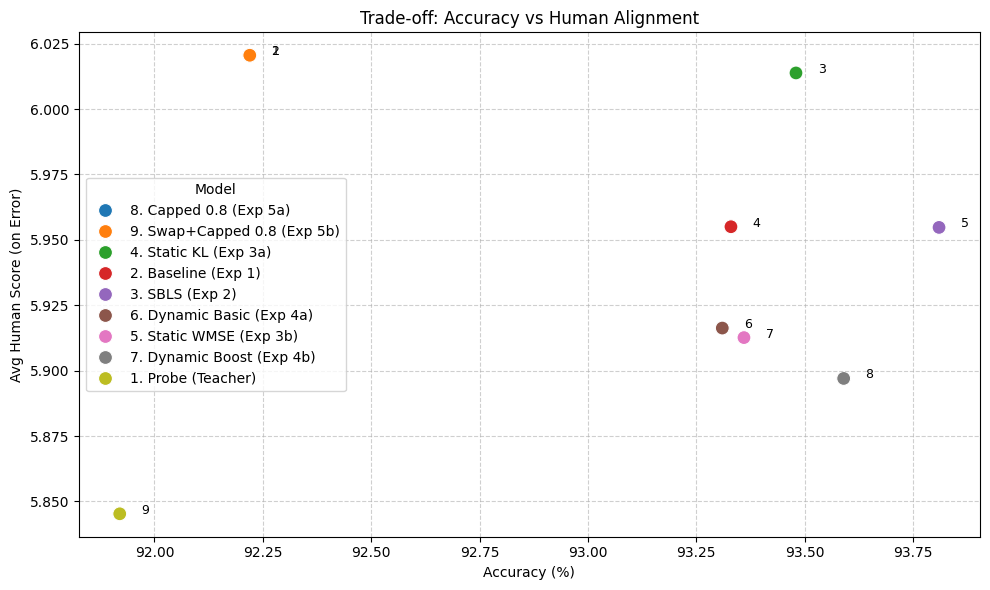

In [21]:
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns  # La til seaborn import da den brukes i plottet nederst

# ==========================================
# 1. KONFIGURASJON
# ==========================================
DATA_DIR = Path("./data")
ARTIFACTS_DIR = Path("./artifacts/analysis")
CKPT_DIR = Path("./checkpoints")
JSON_PATH = Path("human_similarity_ranking.json")

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Liste over modeller vi ser etter.
# MERK: Filnavnet for Exp 1 er korrigert for å matche mappestrukturen din.
POSSIBLE_MODELS = {
    "1. Probe (Teacher)":           "probe_best.pth",
    "2. Baseline (Exp 1)":          "02_exp1_baseline_best.pth",  # Korrigert filnavn
    "3. SBLS (Exp 2)":              "03_exp2_sbls_300ep_best.pth",
    "4. Static KL (Exp 3a)":        "04_exp3a_static_probs_300ep_best.pth",
    "5. Static WMSE (Exp 3b)":      "05_exp3b_static_logits_300ep_best.pth",
    "6. Dynamic Basic (Exp 4a)":    "06_exp4a_dynamic_basic_300ep_best.pth",
    "7. Dynamic Boost (Exp 4b)":    "07_exp4b_dynamic_boost_300ep_best.pth",
    "8. Capped 0.8 (Exp 5a)":       "08_exp5a_capped_run_300ep_cap0.8_best.pth",
    "9. Swap+Capped 0.8 (Exp 5b)":  "09_exp5b_capped_swap_run_300ep_cap0.8_best.pth"
}

# ==========================================
# 2. DATA & MODELL DEFINISJONER
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def get_test_loader():
    test_tf = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)
    # Shuffle=False er KRITISK for "Fair Comparison" (indeks-matching)
    return DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==========================================
# 3. HUMAN SIMILARITY MATRIX LOADER
# ==========================================
def load_human_similarity_matrix(json_path):
    """
    Laster inn JSON-filen og konverterer 'wins' til en tensor-matrise.
    score_matrix[true_idx, pred_idx] = antall poeng
    """
    if not json_path.exists():
        # HER VAR FEILEN: Manglet anførselstegn før ADVARSEL
        print(f"⚠️  ADVARSEL: Fant ikke {json_path}. Lager dummy-matrise (0 poeng).")
        return torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    with open(json_path, "r") as f:
        data = json.load(f)
    
    wins_data = data.get("wins", {})
    score_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    for true_idx, true_name in enumerate(CIFAR10_CLASSES):
        if true_name not in wins_data: continue
        for pred_idx, pred_name in enumerate(CIFAR10_CLASSES):
            if true_idx == pred_idx: continue # Ignorer diagonalen (korrekt svar)
            
            # Hent poeng
            points = wins_data[true_name].get(pred_name, 0)
            score_matrix[true_idx, pred_idx] = points

    print(f"Human Similarity Matrix lastet fra {json_path}.")
    return score_matrix

# ==========================================
# 4. PREDICTION COLLECTOR
# ==========================================
def collect_predictions(models_dict, loader):
    """
    Kjører alle modellene og returnerer:
    - all_preds: Dict {model_name: tensor_of_predictions}
    - all_logits: Dict {model_name: tensor_of_logits} (for ev. analyse)
    - targets: Tensor med fasit
    """
    all_preds = {}
    all_logits = {}
    targets = []
    
    # Hent targets først
    print("Laster testdata...")
    for _, y in loader:
        targets.append(y.to(DEVICE))
    targets = torch.cat(targets)
    
    # Iterer over modeller
    print("\nStarter inferens på alle modeller...")
    for name, filename in tqdm(models_dict.items(), desc="Modeller"):
        ckpt_path = CKPT_DIR / filename
        
        if not ckpt_path.exists():
            # Prøv å se om filen finnes uten path-prefix hvis bruker la inn full sti
            if Path(filename).exists():
                ckpt_path = Path(filename)
            else:
                print(f"⚠️  Hopper over {name}: Fant ikke {ckpt_path}")
                continue
        
        # Last modell
        model = make_cifar_resnet18(NUM_CLASSES).to(DEVICE)
        try:
            model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
        except Exception as e:
            print(f"⚠️  Kunne ikke laste {name}: {e}")
            continue
            
        model.eval()
        
        preds_list = []
        logits_list = []
        
        with torch.no_grad():
            for x, _ in loader:
                x = x.to(DEVICE)
                out = model(x)
                logits_list.append(out)
                preds_list.append(out.argmax(dim=1))
        
        all_preds[name] = torch.cat(preds_list)
        all_logits[name] = torch.cat(logits_list)
        
    return all_preds, all_logits, targets

# ==========================================
# 5. ANALYSE-LOGIKK
# ==========================================
def run_full_analysis():
    # 1. Oppsett
    score_matrix = load_human_similarity_matrix(JSON_PATH)
    loader = get_test_loader()
    
    # 2. Samle data
    model_preds, _, targets = collect_predictions(POSSIBLE_MODELS, loader)
    
    if not model_preds:
        print("Ingen modeller ble evaluert. Sjekk filstier.")
        return

    # --- ANALYSE 1: GENERELL YTELSE ---
    print("\n[1/2] Beregner Generell Ytelse (Alle feil)...")
    general_results = []
    
    for name, preds in model_preds.items():
        # Accuracy
        correct_mask = (preds == targets)
        acc = correct_mask.float().mean().item() * 100
        
        # Human Score på FEIL
        error_mask = ~correct_mask
        num_errors = error_mask.sum().item()
        
        if num_errors > 0:
            error_true = targets[error_mask]
            error_pred = preds[error_mask]
            scores = score_matrix[error_true, error_pred]
            avg_human_score = scores.mean().item()
            total_human_points = scores.sum().item()
        else:
            avg_human_score = 0.0
            total_human_points = 0
            
        general_results.append({
            "Model": name,
            "Accuracy (%)": acc,
            "Avg Human Score (on Error)": avg_human_score,
            "Total Errors": num_errors
        })
        
    df_general = pd.DataFrame(general_results).sort_values(by="Avg Human Score (on Error)", ascending=False)
    
    # --- ANALYSE 2: FAIR COMPARISON (COMMON FAILURES) ---
    print("\n[2/2] Beregner Fair Comparison (Common Failures)...")
    
    # Finn maske der ALLE modeller tar feil
    n_samples = targets.size(0)
    common_failure_mask = torch.ones(n_samples, dtype=torch.bool, device=DEVICE)
    
    for name, preds in model_preds.items():
        incorrect_mask = (preds != targets)
        common_failure_mask = common_failure_mask & incorrect_mask
        
    num_common = common_failure_mask.sum().item()
    print(f"Antall bilder der ALLE {len(model_preds)} modeller tok feil: {num_common}")
    
    fair_results = []
    
    if num_common > 0:
        hard_targets = targets[common_failure_mask]
        
        for name, preds in model_preds.items():
            hard_preds = preds[common_failure_mask]
            
            # Accuracy er 0% her per definisjon, så vi måler kun Human Score
            scores = score_matrix[hard_targets, hard_preds]
            avg_score = scores.mean().item()
            total_score = scores.sum().item()
            
            fair_results.append({
                "Model": name,
                "Fair Human Score (Avg)": avg_score,
                "Total Human Points (Fair)": total_score
            })
            
        df_fair = pd.DataFrame(fair_results).sort_values(by="Fair Human Score (Avg)", ascending=False)
    else:
        print("Ingen felles feil funnet! Kan ikke kjøre fair comparison.")
        df_fair = pd.DataFrame()

    # --- UTSKRIFT OG LAGRING ---
    print("\n" + "="*80)
    print("RESULTAT: GENERELL YTELSE")
    print("Forklaring: Accuracy = Hvor ofte rett? Human Score = Når den tar feil, hvor 'forståelig' er feilen?")
    print("-" * 80)
    print(df_general.to_string(index=False, float_format="%.2f"))
    print("="*80)
    
    if not df_fair.empty:
        print("\n" + "="*80)
        print("RESULTAT: FAIR COMPARISON (VANSKELIGE BILDER)")
        print(f"Basert på {num_common} bilder som INGEN klarte å gjette riktig.")
        print("Dette viser hvem som feiler mest 'elegant' når oppgaven er umulig.")
        print("-" * 80)
        print(df_fair.to_string(index=False, float_format="%.2f"))
        print("="*80)

    # Lagre til CSV
    df_general.to_csv(ARTIFACTS_DIR / "analysis_general.csv", index=False)
    df_fair.to_csv(ARTIFACTS_DIR / "analysis_fair.csv", index=False)
    print(f"\nResultater lagret til {ARTIFACTS_DIR}")
    
    # Plotting: Accuracy vs Human Score
    if not df_general.empty:
        plt.figure(figsize=(10, 6))
        # Scatter plot
        sns.scatterplot(data=df_general, x="Accuracy (%)", y="Avg Human Score (on Error)", s=100, hue="Model")
        
        # Annoter punkter
        for i in range(df_general.shape[0]):
            plt.text(
                df_general["Accuracy (%)"].iloc[i]+0.05, 
                df_general["Avg Human Score (on Error)"].iloc[i], 
                str(i+1), # Rank ID
                fontsize=9
            )
            
        plt.title("Trade-off: Accuracy vs Human Alignment")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.savefig(ARTIFACTS_DIR / "acc_vs_humanscore.png")
        print("Plot lagret.")

if __name__ == "__main__":
    run_full_analysis()

Human Similarity Matrix lastet fra human_similarity_ranking.json.
Files already downloaded and verified
Laster testdata (fasit)...

Starter inferens på alle modeller...


Modeller:   0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_44655/1979304674.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_p


Antall bilder der ALLE 17 modeller tok feil: 76

RESULTAT: ACCURACY VS FAIR HUMAN SCORE
--------------------------------------------------------------------------------
                       Full Name  Accuracy  Fair Human Score
  Dynamic Basic (Exp 4a) - 300ep     93.31              5.80
   Dynamic Boost (Exp 4b) - 50ep     91.60              5.79
     Capped 0.8 (Exp 5a) - 300ep     92.22              5.78
Swap+Capped 0.8 (Exp 5b) - 300ep     92.22              5.78
                 Probe (Teacher)     91.92              5.75
         Baseline (Exp 1) - 50ep     91.92              5.75
   Dynamic Basic (Exp 4a) - 50ep     91.61              5.72
      Capped 0.8 (Exp 5a) - 50ep     88.24              5.71
 Swap+Capped 0.8 (Exp 5b) - 50ep     88.24              5.71
             SBLS (Exp 2) - 50ep     91.79              5.63
     Static WMSE (Exp 3b) - 50ep     91.85              5.59
       Static KL (Exp 3a) - 50ep     91.89              5.55
  Dynamic Boost (Exp 4b) - 300ep     

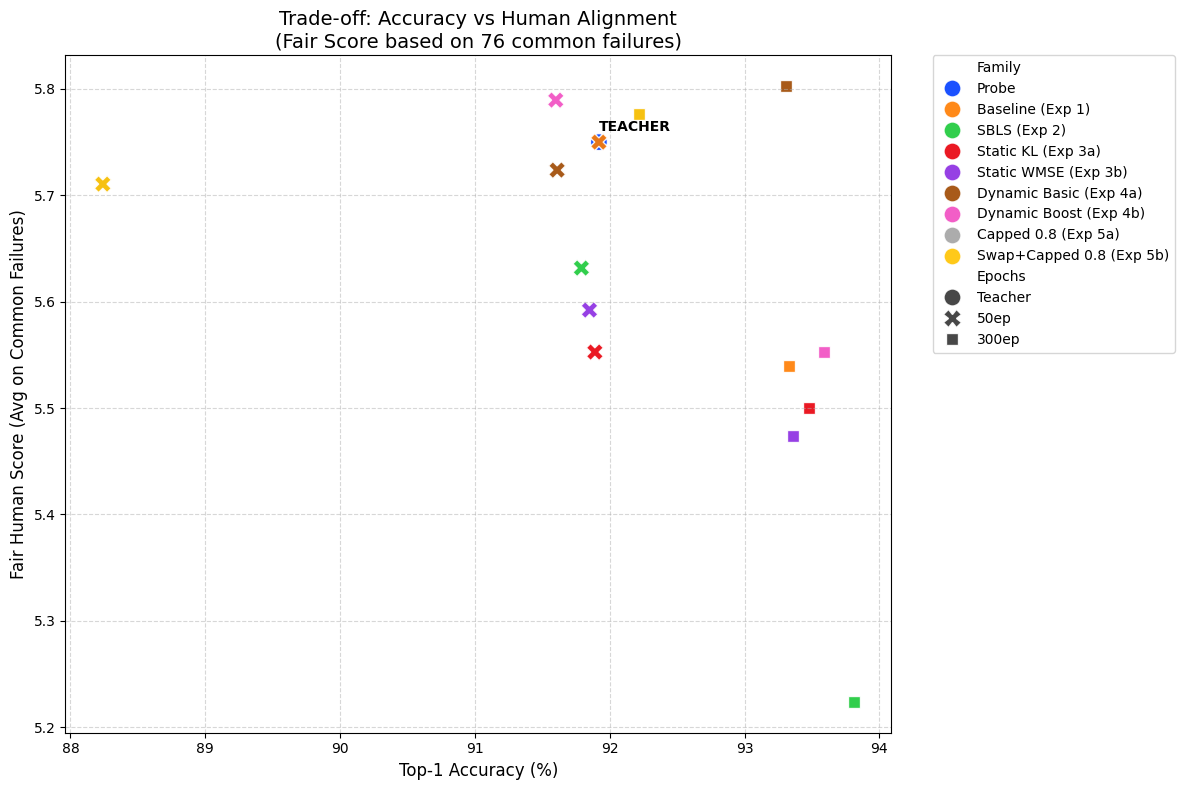

In [23]:
import os
import json
import re
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON
# ==========================================
DATA_DIR = Path("./data")
ARTIFACTS_DIR = Path("./artifacts/analysis")
CKPT_DIR = Path("./checkpoints")
JSON_PATH = Path("human_similarity_ranking.json")

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Liste over ALLE modeller (50ep og 300ep)
# Nøklene er formatert som "Navn - Epoker" for enklere parsing senere
POSSIBLE_MODELS = {
    "Probe (Teacher)":                    "probe_best.pth",
    
    "Baseline (Exp 1) - 50ep":            "02_exp1_baseline_epoch50.pth",
    "Baseline (Exp 1) - 300ep":           "02_exp1_baseline_best.pth",
    
    "SBLS (Exp 2) - 50ep":                "03_exp2_sbls_50ep_best.pth",
    "SBLS (Exp 2) - 300ep":               "03_exp2_sbls_300ep_best.pth",
    
    "Static KL (Exp 3a) - 50ep":          "04_exp3a_static_probs_50ep_best.pth",
    "Static KL (Exp 3a) - 300ep":         "04_exp3a_static_probs_300ep_best.pth",
    
    "Static WMSE (Exp 3b) - 50ep":        "05_exp3b_static_logits_50ep_best.pth",
    "Static WMSE (Exp 3b) - 300ep":       "05_exp3b_static_logits_300ep_best.pth",
    
    "Dynamic Basic (Exp 4a) - 50ep":      "06_exp4a_dynamic_basic_50ep_best.pth",
    "Dynamic Basic (Exp 4a) - 300ep":     "06_exp4a_dynamic_basic_300ep_best.pth",
    
    "Dynamic Boost (Exp 4b) - 50ep":      "07_exp4b_dynamic_boost_50ep_best.pth",
    "Dynamic Boost (Exp 4b) - 300ep":     "07_exp4b_dynamic_boost_300ep_best.pth",
    
    "Capped 0.8 (Exp 5a) - 50ep":         "08_exp5a_capped_run_50ep_cap0.8_best.pth",
    "Capped 0.8 (Exp 5a) - 300ep":        "08_exp5a_capped_run_300ep_cap0.8_best.pth",
    
    "Swap+Capped 0.8 (Exp 5b) - 50ep":    "09_exp5b_capped_swap_run_50ep_cap0.8_best.pth",
    "Swap+Capped 0.8 (Exp 5b) - 300ep":   "09_exp5b_capped_swap_run_300ep_cap0.8_best.pth"
}

# ==========================================
# 2. DATA & MODELL DEFINISJONER
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def get_test_loader():
    test_tf = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)
    # Shuffle=False er KRITISK for "Fair Comparison" (indeks-matching)
    return DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==========================================
# 3. HUMAN SIMILARITY MATRIX LOADER
# ==========================================
def load_human_similarity_matrix(json_path):
    if not json_path.exists():
        print(f"⚠️  ADVARSEL: Fant ikke {json_path}. Lager dummy-matrise (0 poeng).")
        return torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    with open(json_path, "r") as f:
        data = json.load(f)
    
    wins_data = data.get("wins", {})
    score_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    for true_idx, true_name in enumerate(CIFAR10_CLASSES):
        if true_name not in wins_data: continue
        for pred_idx, pred_name in enumerate(CIFAR10_CLASSES):
            if true_idx == pred_idx: continue # Ignorer diagonalen (korrekt svar)
            
            # Hent poeng
            points = wins_data[true_name].get(pred_name, 0)
            score_matrix[true_idx, pred_idx] = points

    print(f"Human Similarity Matrix lastet fra {json_path}.")
    return score_matrix

# ==========================================
# 4. PREDICTION COLLECTOR
# ==========================================
def collect_predictions(models_dict, loader):
    all_preds = {}
    targets = []
    
    # Hent targets først
    print("Laster testdata (fasit)...")
    for _, y in loader:
        targets.append(y.to(DEVICE))
    targets = torch.cat(targets)
    
    # Iterer over modeller
    print("\nStarter inferens på alle modeller...")
    for name, filename in tqdm(models_dict.items(), desc="Modeller"):
        ckpt_path = CKPT_DIR / filename
        
        if not ckpt_path.exists():
            # Fallback hvis stien er litt annerledes eller bruker la inn full path
            if Path(filename).exists():
                ckpt_path = Path(filename)
            else:
                print(f"⚠️  Hopper over {name}: Fant ikke {ckpt_path}")
                continue
        
        # Last modell
        model = make_cifar_resnet18(NUM_CLASSES).to(DEVICE)
        try:
            model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
        except Exception as e:
            print(f"⚠️  Kunne ikke laste {name}: {e}")
            continue
            
        model.eval()
        preds_list = []
        
        with torch.no_grad():
            for x, _ in loader:
                x = x.to(DEVICE)
                logits = model(x)
                preds_list.append(logits.argmax(dim=1))
        
        all_preds[name] = torch.cat(preds_list)
        
    return all_preds, targets

# ==========================================
# 5. ANALYSE-LOGIKK
# ==========================================
def run_full_analysis():
    # 1. Oppsett
    score_matrix = load_human_similarity_matrix(JSON_PATH)
    loader = get_test_loader()
    
    # 2. Samle data
    model_preds, targets = collect_predictions(POSSIBLE_MODELS, loader)
    
    if not model_preds:
        print("Ingen modeller ble evaluert. Sjekk filstier.")
        return

    # --- 3. BEREGN FAIR COMPARISON MASK (FELLESMENGDE AV FEIL) ---
    # Vi finner bildene der ALLE modellene tok feil.
    # Dette sikrer at vi sammenligner "epler med epler" på vanskelige bilder.
    n_samples = targets.size(0)
    common_failure_mask = torch.ones(n_samples, dtype=torch.bool, device=DEVICE)
    
    for name, preds in model_preds.items():
        incorrect_mask = (preds != targets)
        common_failure_mask = common_failure_mask & incorrect_mask
        
    num_common = common_failure_mask.sum().item()
    print(f"\nAntall bilder der ALLE {len(model_preds)} modeller tok feil: {num_common}")
    
    hard_targets = None
    if num_common > 0:
        hard_targets = targets[common_failure_mask]
    else:
        print("⚠️ Ingen felles feil funnet! 'Fair Score' vil være tom.")

    # --- 4. SAMLE RESULTATER ---
    results_list = []

    for name, preds in model_preds.items():
        # A. Generell Accuracy
        acc = (preds == targets).float().mean().item() * 100
        
        # B. Fair Human Score (Kun på felles feil)
        fair_score = 0.0
        if num_common > 0:
            hard_preds = preds[common_failure_mask]
            # Hent poeng fra matrisen for disse vanskelige tilfellene
            scores = score_matrix[hard_targets, hard_preds]
            fair_score = scores.mean().item()
            
        # Parse navn for plotting (Family vs Epochs)
        if "Probe" in name:
            family = "Probe"
            epochs = "Teacher"
        else:
            # Eks: "Baseline (Exp 1) - 300ep"
            parts = name.split(" - ")
            family = parts[0]
            epochs = parts[1] if len(parts) > 1 else "Unknown"

        results_list.append({
            "Full Name": name,
            "Family": family,
            "Epochs": epochs,
            "Accuracy": acc,
            "Fair Human Score": fair_score
        })

    df = pd.DataFrame(results_list)
    
    # Sorter etter Fair Human Score (høyest er best)
    df_sorted = df.sort_values(by="Fair Human Score", ascending=False)

    # --- 5. UTSKRIFT ---
    print("\n" + "="*80)
    print("RESULTAT: ACCURACY VS FAIR HUMAN SCORE")
    print("-" * 80)
    # Vis relevante kolonner
    print(df_sorted[["Full Name", "Accuracy", "Fair Human Score"]].to_string(index=False, float_format="%.2f"))
    print("="*80)
    
    # Lagre til CSV
    df_sorted.to_csv(ARTIFACTS_DIR / "analysis_full_comparison.csv", index=False)
    print(f"Data lagret til {ARTIFACTS_DIR / 'analysis_full_comparison.csv'}")

    # --- 6. PLOTTING: ACCURACY VS FAIR HUMAN SCORE ---
    if not df.empty and num_common > 0:
        plt.figure(figsize=(12, 8))
        
        # Vi bruker Seaborn for å håndtere farger (Hue) og former (Style) automatisk
        sns.scatterplot(
            data=df, 
            x="Accuracy", 
            y="Fair Human Score", 
            hue="Family",       # Farge basert på modell-familie (Baseline, SBLS, etc.)
            style="Epochs",     # Form basert på 50ep vs 300ep
            s=150,              # Størrelse på punkter
            alpha=0.9,
            palette="bright"
        )
        
        # Annoter Probe spesielt hvis den er med
        probe_row = df[df["Family"] == "Probe"]
        if not probe_row.empty:
            plt.text(
                probe_row["Accuracy"].values[0], 
                probe_row["Fair Human Score"].values[0] + 0.01, 
                "TEACHER", 
                fontweight='bold'
            )

        plt.title(f"Trade-off: Accuracy vs Human Alignment\n(Fair Score based on {num_common} common failures)", fontsize=14)
        plt.xlabel("Top-1 Accuracy (%)", fontsize=12)
        plt.ylabel("Fair Human Score (Avg on Common Failures)", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        
        plot_path = ARTIFACTS_DIR / "tradeoff_acc_vs_fairscore.png"
        plt.savefig(plot_path, dpi=150)
        print(f"Plot lagret til: {plot_path}")
        plt.show()
    else:
        print("Kan ikke plotte: Mangler data eller ingen felles feil.")

if __name__ == "__main__":
    run_full_analysis()

Human Similarity Matrix lastet fra human_similarity_ranking.json.
Files already downloaded and verified
Laster testdata (fasit)...

Starter inferens på alle modeller...


Modeller:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_44655/1291983402.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_p


Antall bilder der ALLE 25 modeller tok feil: 60

RESULTAT: ACCURACY VS FAIR HUMAN SCORE
Basert på 60 vanskelige bilder som ingen modeller klarte.
--------------------------------------------------------------------------------
                     Full Name  Accuracy  Fair Human Score
 Dynamic Boost (Exp 4b) - 50ep     91.60              5.65
Dynamic Basic (Exp 4a) - 300ep     93.31              5.50
               Probe (Teacher)     91.92              5.48
       Baseline (Exp 1) - 50ep     91.92              5.48
   Capped 0.8 (Exp 5a) - 300ep     92.22              5.45
     Swap 0.8 (Exp 5b) - 300ep     92.22              5.45
  Capped 0.95 (Exp 5a) - 300ep     92.37              5.43
    Swap 0.95 (Exp 5b) - 300ep     92.37              5.43
      Swap 0.6 (Exp 5b) - 50ep     87.71              5.40
    Capped 0.6 (Exp 5a) - 50ep     87.71              5.40
     Swap 0.6 (Exp 5b) - 300ep     92.37              5.38
   Capped 0.6 (Exp 5a) - 300ep     92.37              5.38
 Dyna

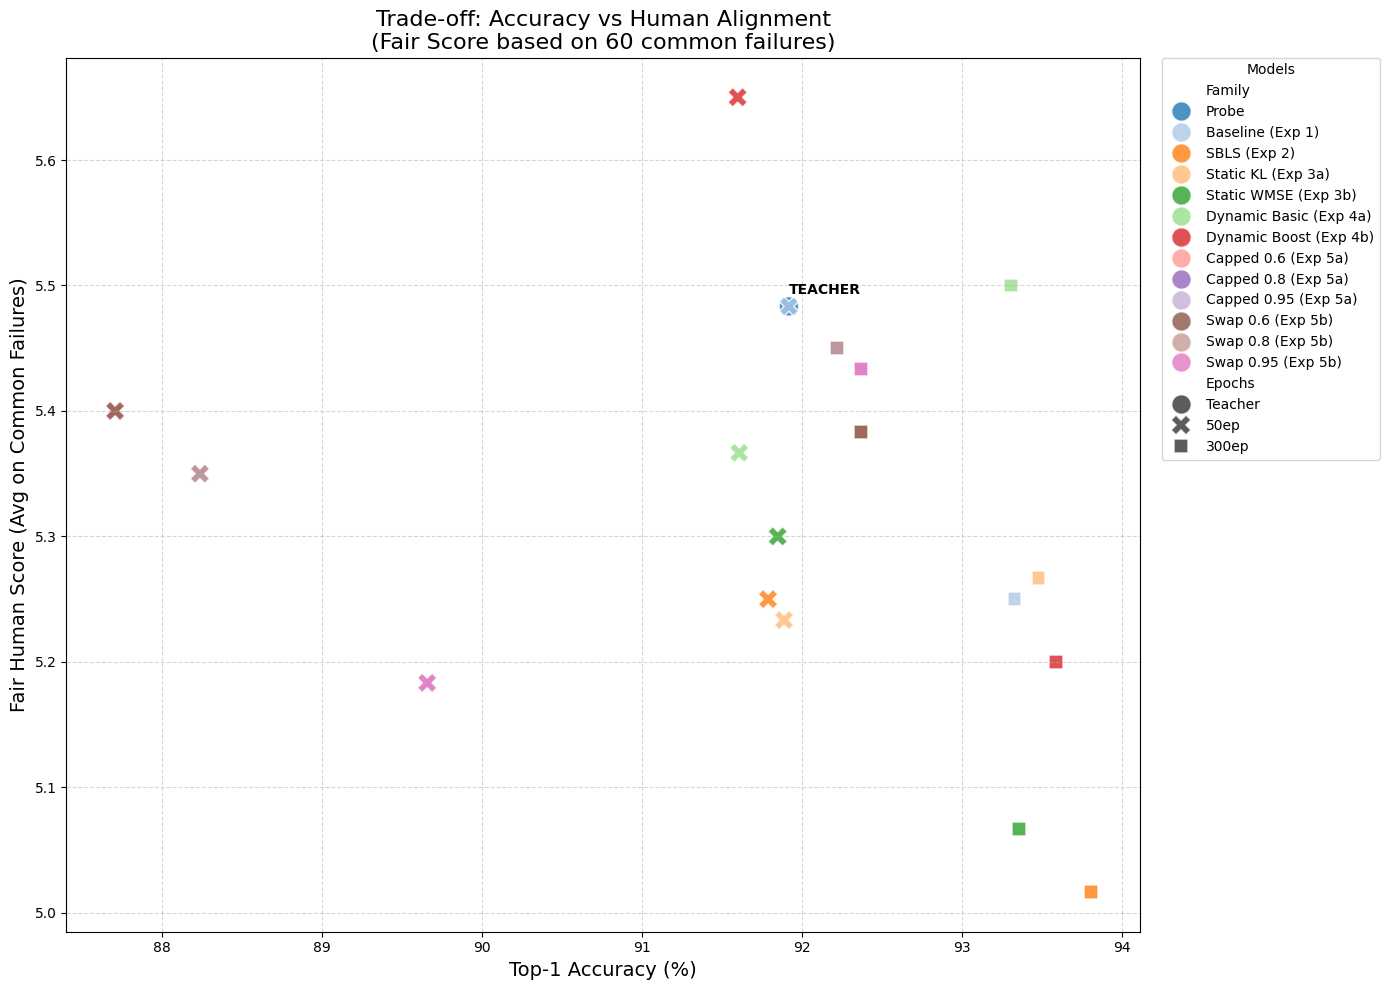

In [25]:
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON
# ==========================================
DATA_DIR = Path("./data")
ARTIFACTS_DIR = Path("./artifacts/analysis")
CKPT_DIR = Path("./checkpoints")
JSON_PATH = Path("human_similarity_ranking.json")

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# ==========================================
# DEFINISJON AV ALLE MODELLER
# ==========================================
# Format: "Visningsnavn - Epoker" : "Filnavn i checkpoints-mappen"
POSSIBLE_MODELS = {
    # --- Referanser ---
    "Probe (Teacher)":                    "probe_best.pth",
    
    # --- Exp 1: Baseline ---
    "Baseline (Exp 1) - 50ep":            "02_exp1_baseline_epoch50.pth",
    "Baseline (Exp 1) - 300ep":           "02_exp1_baseline_best.pth",
    
    # --- Exp 2: SBLS ---
    "SBLS (Exp 2) - 50ep":                "03_exp2_sbls_50ep_best.pth",
    "SBLS (Exp 2) - 300ep":               "03_exp2_sbls_300ep_best.pth",
    
    # --- Exp 3: Static Targets ---
    "Static KL (Exp 3a) - 50ep":          "04_exp3a_static_probs_50ep_best.pth",
    "Static KL (Exp 3a) - 300ep":         "04_exp3a_static_probs_300ep_best.pth",
    "Static WMSE (Exp 3b) - 50ep":        "05_exp3b_static_logits_50ep_best.pth",
    "Static WMSE (Exp 3b) - 300ep":       "05_exp3b_static_logits_300ep_best.pth",
    
    # --- Exp 4: Dynamic Targets ---
    "Dynamic Basic (Exp 4a) - 50ep":      "06_exp4a_dynamic_basic_50ep_best.pth",
    "Dynamic Basic (Exp 4a) - 300ep":     "06_exp4a_dynamic_basic_300ep_best.pth",
    "Dynamic Boost (Exp 4b) - 50ep":      "07_exp4b_dynamic_boost_50ep_best.pth",
    "Dynamic Boost (Exp 4b) - 300ep":     "07_exp4b_dynamic_boost_300ep_best.pth",
    
    # --- Exp 5a: Capped (Alle caps) ---
    "Capped 0.6 (Exp 5a) - 50ep":         "08_exp5a_capped_run_50ep_cap0.6_best.pth",
    "Capped 0.6 (Exp 5a) - 300ep":        "08_exp5a_capped_run_300ep_cap0.6_best.pth",
    
    "Capped 0.8 (Exp 5a) - 50ep":         "08_exp5a_capped_run_50ep_cap0.8_best.pth",
    "Capped 0.8 (Exp 5a) - 300ep":        "08_exp5a_capped_run_300ep_cap0.8_best.pth",
    
    "Capped 0.95 (Exp 5a) - 50ep":        "08_exp5a_capped_run_50ep_cap0.95_best.pth",
    "Capped 0.95 (Exp 5a) - 300ep":       "08_exp5a_capped_run_300ep_cap0.95_best.pth",
    
    # --- Exp 5b: Capped + Swap (Alle caps) ---
    "Swap 0.6 (Exp 5b) - 50ep":           "09_exp5b_capped_swap_run_50ep_cap0.6_best.pth",
    "Swap 0.6 (Exp 5b) - 300ep":          "09_exp5b_capped_swap_run_300ep_cap0.6_best.pth",
    
    "Swap 0.8 (Exp 5b) - 50ep":           "09_exp5b_capped_swap_run_50ep_cap0.8_best.pth",
    "Swap 0.8 (Exp 5b) - 300ep":          "09_exp5b_capped_swap_run_300ep_cap0.8_best.pth",
    
    "Swap 0.95 (Exp 5b) - 50ep":          "09_exp5b_capped_swap_run_50ep_cap0.95_best.pth",
    "Swap 0.95 (Exp 5b) - 300ep":         "09_exp5b_capped_swap_run_300ep_cap0.95_best.pth"
}

# ==========================================
# 2. DATA & MODELL DEFINISJONER
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def get_test_loader():
    test_tf = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)
    # Shuffle=False er KRITISK for "Fair Comparison" (indeks-matching)
    return DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==========================================
# 3. HUMAN SIMILARITY MATRIX LOADER
# ==========================================
def load_human_similarity_matrix(json_path):
    if not json_path.exists():
        print(f"⚠️  ADVARSEL: Fant ikke {json_path}. Lager dummy-matrise (0 poeng).")
        return torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    with open(json_path, "r") as f:
        data = json.load(f)
    
    wins_data = data.get("wins", {})
    score_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    for true_idx, true_name in enumerate(CIFAR10_CLASSES):
        if true_name not in wins_data: continue
        for pred_idx, pred_name in enumerate(CIFAR10_CLASSES):
            if true_idx == pred_idx: continue # Ignorer diagonalen (korrekt svar)
            
            # Hent poeng
            points = wins_data[true_name].get(pred_name, 0)
            score_matrix[true_idx, pred_idx] = points

    print(f"Human Similarity Matrix lastet fra {json_path}.")
    return score_matrix

# ==========================================
# 4. PREDICTION COLLECTOR
# ==========================================
def collect_predictions(models_dict, loader):
    all_preds = {}
    targets = []
    
    # Hent targets først
    print("Laster testdata (fasit)...")
    for _, y in loader:
        targets.append(y.to(DEVICE))
    targets = torch.cat(targets)
    
    # Iterer over modeller
    print("\nStarter inferens på alle modeller...")
    for name, filename in tqdm(models_dict.items(), desc="Modeller"):
        ckpt_path = CKPT_DIR / filename
        
        if not ckpt_path.exists():
            # Fallback hvis stien er litt annerledes eller bruker la inn full path
            if Path(filename).exists():
                ckpt_path = Path(filename)
            else:
                print(f"⚠️  Hopper over {name}: Fant ikke {ckpt_path}")
                continue
        
        # Last modell
        model = make_cifar_resnet18(NUM_CLASSES).to(DEVICE)
        try:
            model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
        except Exception as e:
            print(f"⚠️  Kunne ikke laste {name}: {e}")
            continue
            
        model.eval()
        preds_list = []
        
        with torch.no_grad():
            for x, _ in loader:
                x = x.to(DEVICE)
                logits = model(x)
                preds_list.append(logits.argmax(dim=1))
        
        all_preds[name] = torch.cat(preds_list)
        
    return all_preds, targets

# ==========================================
# 5. ANALYSE-LOGIKK
# ==========================================
def run_full_analysis():
    # 1. Oppsett
    score_matrix = load_human_similarity_matrix(JSON_PATH)
    loader = get_test_loader()
    
    # 2. Samle data
    model_preds, targets = collect_predictions(POSSIBLE_MODELS, loader)
    
    if not model_preds:
        print("Ingen modeller ble evaluert. Sjekk filstier.")
        return

    # --- 3. BEREGN FAIR COMPARISON MASK (FELLESMENGDE AV FEIL) ---
    # Vi finner bildene der ALLE modellene tok feil.
    n_samples = targets.size(0)
    common_failure_mask = torch.ones(n_samples, dtype=torch.bool, device=DEVICE)
    
    for name, preds in model_preds.items():
        incorrect_mask = (preds != targets)
        common_failure_mask = common_failure_mask & incorrect_mask
        
    num_common = common_failure_mask.sum().item()
    print(f"\nAntall bilder der ALLE {len(model_preds)} modeller tok feil: {num_common}")
    
    hard_targets = None
    if num_common > 0:
        hard_targets = targets[common_failure_mask]
    else:
        print("⚠️ Ingen felles feil funnet! 'Fair Score' vil være tom.")

    # --- 4. SAMLE RESULTATER ---
    results_list = []

    for name, preds in model_preds.items():
        # A. Generell Accuracy
        acc = (preds == targets).float().mean().item() * 100
        
        # B. Fair Human Score (Kun på felles feil)
        fair_score = 0.0
        if num_common > 0:
            hard_preds = preds[common_failure_mask]
            # Hent poeng fra matrisen for disse vanskelige tilfellene
            scores = score_matrix[hard_targets, hard_preds]
            fair_score = scores.mean().item()
            
        # Parse navn for plotting (Family vs Epochs)
        # Eks: "Capped 0.8 (Exp 5a) - 300ep"
        if "Probe" in name:
            family = "Probe"
            epochs = "Teacher"
        else:
            parts = name.split(" - ")
            family = parts[0]
            epochs = parts[1] if len(parts) > 1 else "Unknown"

        results_list.append({
            "Full Name": name,
            "Family": family,
            "Epochs": epochs,
            "Accuracy": acc,
            "Fair Human Score": fair_score
        })

    df = pd.DataFrame(results_list)
    
    # Sorter etter Fair Human Score (høyest er best)
    df_sorted = df.sort_values(by="Fair Human Score", ascending=False)

    # --- 5. UTSKRIFT ---
    print("\n" + "="*80)
    print("RESULTAT: ACCURACY VS FAIR HUMAN SCORE")
    print(f"Basert på {num_common} vanskelige bilder som ingen modeller klarte.")
    print("-" * 80)
    print(df_sorted[["Full Name", "Accuracy", "Fair Human Score"]].to_string(index=False, float_format="%.2f"))
    print("="*80)
    
    # Lagre til CSV
    df_sorted.to_csv(ARTIFACTS_DIR / "analysis_full_comparison.csv", index=False)
    print(f"Data lagret til {ARTIFACTS_DIR / 'analysis_full_comparison.csv'}")

    # --- 6. PLOTTING: ACCURACY VS FAIR HUMAN SCORE ---
    if not df.empty and num_common > 0:
        plt.figure(figsize=(14, 10)) # Større figur for å få plass til alt
        
        sns.scatterplot(
            data=df, 
            x="Accuracy", 
            y="Fair Human Score", 
            hue="Family",       # Farge = Modelltype
            style="Epochs",     # Form = 50ep vs 300ep
            s=200,              # Større punkter
            alpha=0.8,
            palette="tab20"     # Fargepalett med mange farger
        )
        
        # Annoter Probe
        probe_row = df[df["Family"] == "Probe"]
        if not probe_row.empty:
            plt.text(
                probe_row["Accuracy"].values[0], 
                probe_row["Fair Human Score"].values[0] + 0.01, 
                "TEACHER", 
                fontweight='bold',
                color='black'
            )

        plt.title(f"Trade-off: Accuracy vs Human Alignment\n(Fair Score based on {num_common} common failures)", fontsize=16)
        plt.xlabel("Top-1 Accuracy (%)", fontsize=14)
        plt.ylabel("Fair Human Score (Avg on Common Failures)", fontsize=14)
        plt.grid(True, linestyle="--", alpha=0.5)
        
        # Flytt legenden ut av plottet
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title="Models")
        plt.tight_layout()
        
        plot_path = ARTIFACTS_DIR / "tradeoff_acc_vs_fairscore_ALL.png"
        plt.savefig(plot_path, dpi=150)
        print(f"Plot lagret til: {plot_path}")
        plt.show()
    else:
        print("Kan ikke plotte: Mangler data eller ingen felles feil.")

if __name__ == "__main__":
    run_full_analysis()

✅ Weighted Score Matrix lastet. Rett svar = 10p, Feil svar = JSON poeng.
Files already downloaded and verified

Starter evaluering av 25 modeller...
Metrikk: Total Weighted Score (Avg per bilde, Max=10)


Evaluerer:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_44655/1068872632.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_


Resultater lagret til: artifacts/human_weighted_accuracy/weighted_human_accuracy.csv

RESULTAT: WEIGHTED HUMAN ACCURACY (Rett=10p, Feil=Likhetspoeng)
--------------------------------------------------------------------------------
                     Full Name  Standard Accuracy (%)  Weighted Human Score (0-10)
          SBLS (Exp 2) - 300ep                 93.810                        9.750
    Static KL (Exp 3a) - 300ep                 93.480                        9.740
Dynamic Boost (Exp 4b) - 300ep                 93.590                        9.737
      Baseline (Exp 1) - 300ep                 93.330                        9.730
  Static WMSE (Exp 3b) - 300ep                 93.360                        9.729
Dynamic Basic (Exp 4a) - 300ep                 93.310                        9.727
   Capped 0.6 (Exp 5a) - 300ep                 92.370                        9.703
     Swap 0.6 (Exp 5b) - 300ep                 92.370                        9.703
  Capped 0.95 (Exp 5a

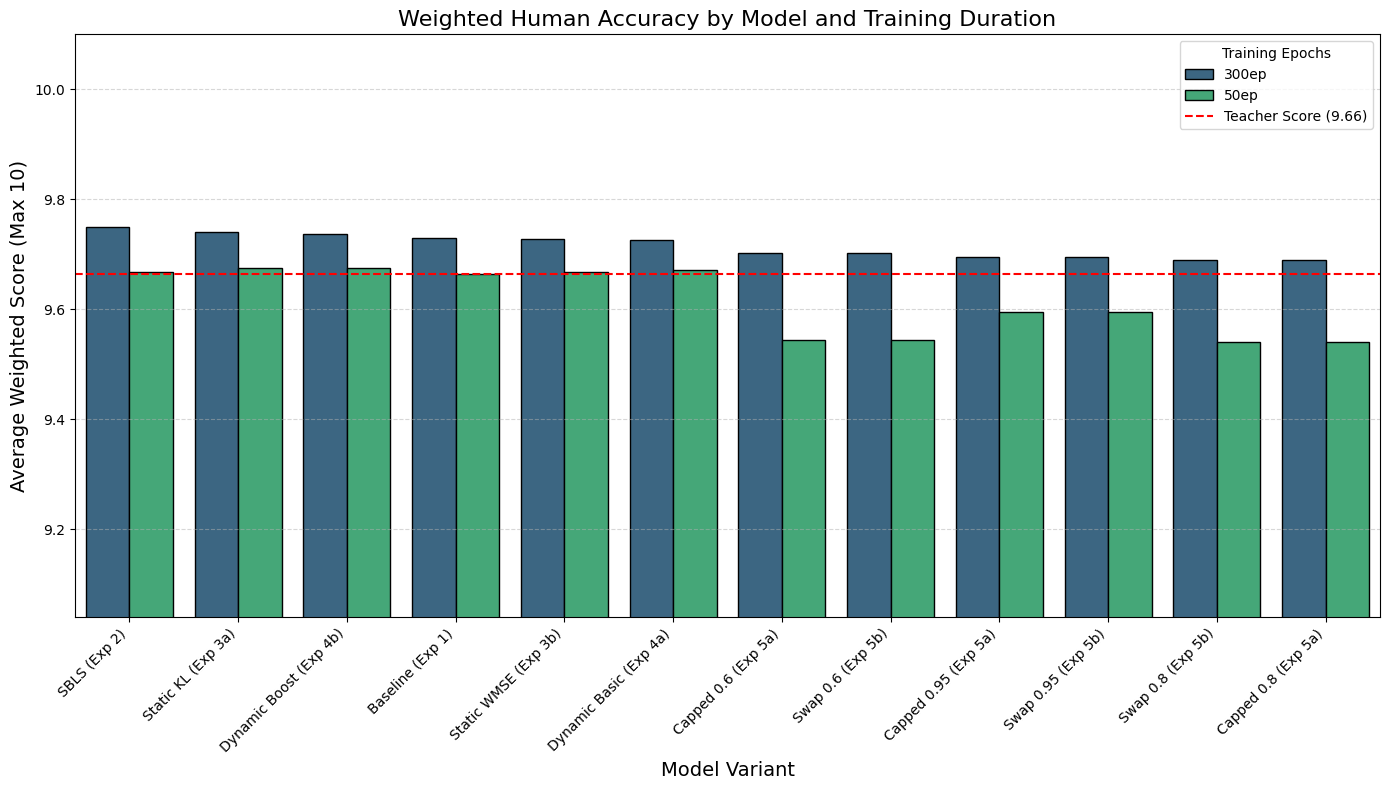

Scatterplot lagret til: artifacts/human_weighted_accuracy/acc_vs_weighted_score_scatter.png


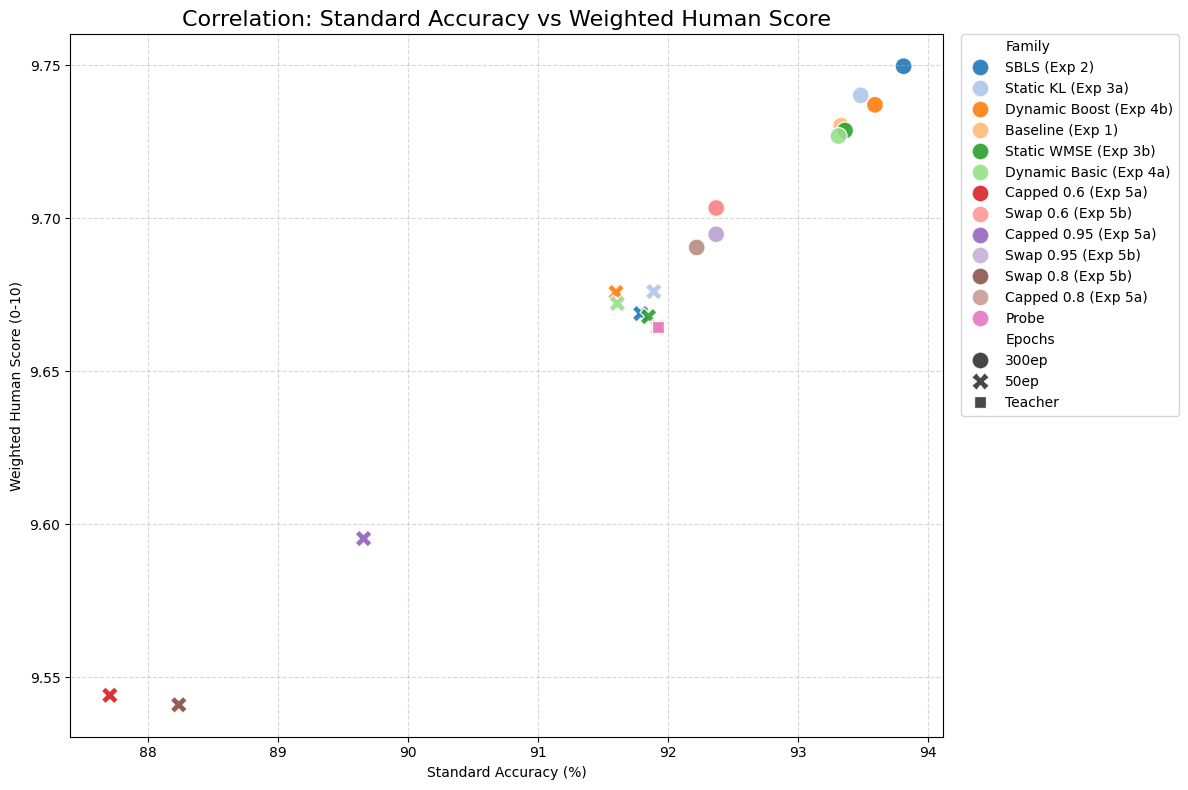

In [27]:
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON
# ==========================================
DATA_DIR = Path("./data")
# Ny mappe for denne spesifikke analysen
ARTIFACTS_DIR = Path("./artifacts/human_weighted_accuracy")
CKPT_DIR = Path("./checkpoints")
JSON_PATH = Path("human_similarity_ranking.json")

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# ==========================================
# 2. DEFINISJON AV ALLE MODELLER
# ==========================================
POSSIBLE_MODELS = {
    # --- Referanser ---
    "Probe (Teacher)":                    "probe_best.pth",
    
    # --- Exp 1: Baseline ---
    "Baseline (Exp 1) - 50ep":            "02_exp1_baseline_epoch50.pth",
    "Baseline (Exp 1) - 300ep":           "02_exp1_baseline_best.pth",
    
    # --- Exp 2: SBLS ---
    "SBLS (Exp 2) - 50ep":                "03_exp2_sbls_50ep_best.pth",
    "SBLS (Exp 2) - 300ep":               "03_exp2_sbls_300ep_best.pth",
    
    # --- Exp 3: Static Targets ---
    "Static KL (Exp 3a) - 50ep":          "04_exp3a_static_probs_50ep_best.pth",
    "Static KL (Exp 3a) - 300ep":         "04_exp3a_static_probs_300ep_best.pth",
    "Static WMSE (Exp 3b) - 50ep":        "05_exp3b_static_logits_50ep_best.pth",
    "Static WMSE (Exp 3b) - 300ep":       "05_exp3b_static_logits_300ep_best.pth",
    
    # --- Exp 4: Dynamic Targets ---
    "Dynamic Basic (Exp 4a) - 50ep":      "06_exp4a_dynamic_basic_50ep_best.pth",
    "Dynamic Basic (Exp 4a) - 300ep":     "06_exp4a_dynamic_basic_300ep_best.pth",
    "Dynamic Boost (Exp 4b) - 50ep":      "07_exp4b_dynamic_boost_50ep_best.pth",
    "Dynamic Boost (Exp 4b) - 300ep":     "07_exp4b_dynamic_boost_300ep_best.pth",
    
    # --- Exp 5a: Capped (Alle caps) ---
    "Capped 0.6 (Exp 5a) - 50ep":         "08_exp5a_capped_run_50ep_cap0.6_best.pth",
    "Capped 0.6 (Exp 5a) - 300ep":        "08_exp5a_capped_run_300ep_cap0.6_best.pth",
    
    "Capped 0.8 (Exp 5a) - 50ep":         "08_exp5a_capped_run_50ep_cap0.8_best.pth",
    "Capped 0.8 (Exp 5a) - 300ep":        "08_exp5a_capped_run_300ep_cap0.8_best.pth",
    
    "Capped 0.95 (Exp 5a) - 50ep":        "08_exp5a_capped_run_50ep_cap0.95_best.pth",
    "Capped 0.95 (Exp 5a) - 300ep":       "08_exp5a_capped_run_300ep_cap0.95_best.pth",
    
    # --- Exp 5b: Capped + Swap (Alle caps) ---
    "Swap 0.6 (Exp 5b) - 50ep":           "09_exp5b_capped_swap_run_50ep_cap0.6_best.pth",
    "Swap 0.6 (Exp 5b) - 300ep":          "09_exp5b_capped_swap_run_300ep_cap0.6_best.pth",
    
    "Swap 0.8 (Exp 5b) - 50ep":           "09_exp5b_capped_swap_run_50ep_cap0.8_best.pth",
    "Swap 0.8 (Exp 5b) - 300ep":          "09_exp5b_capped_swap_run_300ep_cap0.8_best.pth",
    
    "Swap 0.95 (Exp 5b) - 50ep":          "09_exp5b_capped_swap_run_50ep_cap0.95_best.pth",
    "Swap 0.95 (Exp 5b) - 300ep":         "09_exp5b_capped_swap_run_300ep_cap0.95_best.pth"
}

# ==========================================
# 3. OPPSETT AV DATA & MODELL
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def get_test_loader():
    test_tf = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)
    return DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==========================================
# 4. LASTE SCORINGSMATRISE (MED 10 POENG FOR RETT SVAR)
# ==========================================
def load_weighted_score_matrix(json_path):
    """
    Laster human_similarity_ranking.json.
    - Diagonalen (Rett svar) settes til 10.0 poeng.
    - Feil svar får poeng fra JSON-filen (0-10).
    """
    # Start med nuller
    score_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    # 1. Sett diagonalen til 10 (Max score for rett svar)
    for i in range(NUM_CLASSES):
        score_matrix[i, i] = 10.0
    
    # 2. Fyll inn poeng for feil svar fra JSON
    if not json_path.exists():
        print(f"⚠️  ADVARSEL: Fant ikke {json_path}. Bruker kun diagonal (Acc).")
        return score_matrix

    with open(json_path, "r") as f:
        data = json.load(f)
    
    wins_data = data.get("wins", {})
    
    for true_idx, true_name in enumerate(CIFAR10_CLASSES):
        if true_name not in wins_data: continue
        for pred_idx, pred_name in enumerate(CIFAR10_CLASSES):
            if true_idx == pred_idx: continue # Allerede satt til 10
            
            # Hent poeng for feilen
            points = wins_data[true_name].get(pred_name, 0)
            score_matrix[true_idx, pred_idx] = points

    print(f"✅ Weighted Score Matrix lastet. Rett svar = 10p, Feil svar = JSON poeng.")
    return score_matrix

# ==========================================
# 5. EVALUERINGSLØKKE
# ==========================================
def evaluate_models(models_dict, loader, score_matrix):
    results = []
    
    print(f"\nStarter evaluering av {len(models_dict)} modeller...")
    print("Metrikk: Total Weighted Score (Avg per bilde, Max=10)")
    
    # Hent targets (fasit) en gang for alle
    all_targets = []
    for _, y in loader:
        all_targets.append(y.to(DEVICE))
    all_targets = torch.cat(all_targets)
    
    for name, filename in tqdm(models_dict.items(), desc="Evaluerer"):
        ckpt_path = CKPT_DIR / filename
        
        # Sjekk om fil finnes
        if not ckpt_path.exists():
            if Path(filename).exists(): ckpt_path = Path(filename)
            else: continue
            
        # Last modell
        model = make_cifar_resnet18(NUM_CLASSES).to(DEVICE)
        try:
            model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
        except Exception:
            continue
            
        model.eval()
        all_preds = []
        
        with torch.no_grad():
            for x, _ in loader:
                x = x.to(DEVICE)
                logits = model(x)
                all_preds.append(logits.argmax(dim=1))
        
        all_preds = torch.cat(all_preds)
        
        # --- BEREGN SCORE ---
        # score_matrix[true_class, pred_class] gir poengene for hvert bilde
        scores = score_matrix[all_targets, all_preds]
        
        # Gjennomsnittlig score (Weighted Accuracy)
        avg_score = scores.mean().item()
        
        # Standard Accuracy (for referanse)
        acc = (all_preds == all_targets).float().mean().item() * 100
        
        # Parse navn for gruppering
        if "Probe" in name:
            family = "Probe"
            epochs = "Teacher"
        else:
            parts = name.split(" - ")
            family = parts[0]
            epochs = parts[1] if len(parts) > 1 else "Unknown"
            
        results.append({
            "Full Name": name,
            "Family": family,
            "Epochs": epochs,
            "Standard Accuracy (%)": acc,
            "Weighted Human Score (0-10)": avg_score
        })
        
    return pd.DataFrame(results)

# ==========================================
# 6. PLOTTING OG LAGRING
# ==========================================
def run_weighted_analysis():
    # Last data
    score_matrix = load_weighted_score_matrix(JSON_PATH)
    loader = get_test_loader()
    
    # Evaluer
    df = evaluate_models(POSSIBLE_MODELS, loader, score_matrix)
    
    if df.empty:
        print("Ingen resultater å vise.")
        return

    # Sorter
    df = df.sort_values(by="Weighted Human Score (0-10)", ascending=False)
    
    # Lagre CSV
    csv_path = ARTIFACTS_DIR / "weighted_human_accuracy.csv"
    df.to_csv(csv_path, index=False)
    print(f"\nResultater lagret til: {csv_path}")
    
    # Print tabell
    print("\n" + "="*80)
    print("RESULTAT: WEIGHTED HUMAN ACCURACY (Rett=10p, Feil=Likhetspoeng)")
    print("-" * 80)
    print(df[["Full Name", "Standard Accuracy (%)", "Weighted Human Score (0-10)"]].to_string(index=False, float_format="%.3f"))
    print("="*80)

    # --- PLOT 1: GROUPED BAR CHART (Epoch Comparison) ---
    plt.figure(figsize=(14, 8))
    
    # Filtrer vekk Probe for dette plottet for å sammenligne treningsmetoder renere
    plot_df = df[df["Family"] != "Probe"]
    
    sns.barplot(
        data=plot_df,
        x="Family",
        y="Weighted Human Score (0-10)",
        hue="Epochs",
        palette="viridis",
        edgecolor="black"
    )
    
    # Legg til linje for Probe (Teacher) Score hvis den finnes
    probe_row = df[df["Family"] == "Probe"]
    if not probe_row.empty:
        probe_score = probe_row["Weighted Human Score (0-10)"].values[0]
        plt.axhline(y=probe_score, color='red', linestyle='--', label=f'Teacher Score ({probe_score:.2f})')
    
    plt.title("Weighted Human Accuracy by Model and Training Duration", fontsize=16)
    plt.ylabel("Average Weighted Score (Max 10)", fontsize=14)
    plt.xlabel("Model Variant", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Training Epochs")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.ylim(bottom=df["Weighted Human Score (0-10)"].min() - 0.5, top=10.1) # Zoom inn på toppen
    plt.tight_layout()
    
    plot_path_bar = ARTIFACTS_DIR / "weighted_score_comparison_bar.png"
    plt.savefig(plot_path_bar, dpi=150)
    print(f"Barplot lagret til: {plot_path_bar}")
    plt.show()

    # --- PLOT 2: SCATTER (Acc vs Weighted Score) ---
    # Dette viser hvor mye ekstra "human points" man får utover ren accuracy
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x="Standard Accuracy (%)",
        y="Weighted Human Score (0-10)",
        hue="Family",
        style="Epochs",
        s=150,
        palette="tab20",
        alpha=0.9
    )
    
    plt.title("Correlation: Standard Accuracy vs Weighted Human Score", fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    
    plot_path_scatter = ARTIFACTS_DIR / "acc_vs_weighted_score_scatter.png"
    plt.savefig(plot_path_scatter, dpi=150)
    print(f"Scatterplot lagret til: {plot_path_scatter}")
    plt.show()

if __name__ == "__main__":
    run_weighted_analysis()

In [ ]:
# ==========================================
# 🧹 OPPRYDDING & RESTART 🧹
# ==========================================
import torch
import gc
from IPython import get_ipython

# 1. Prøv å slette store objekter manuelt først
try:
    del model, optimizer, scaler, train_loader, test_loader
except NameError:
    pass

# 2. Kjør Garbage Collection og tøm GPU-cache
gc.collect()
torch.cuda.empty_cache()

# 3. Nuke everything! (Dette sletter ALLE variabler i minnet)
# Dette sikrer at neste celle starter med blanke ark.
get_ipython().run_line_magic('reset', '-sf')

print("✅ Minne tømt og variabler nullstilt. Klar for neste eksperiment.")

✅ Weighted Score Matrix lastet. Rett svar = 9p, Feil svar = JSON poeng.
Files already downloaded and verified

Starter evaluering av 25 modeller...
Metrikk: Total Weighted Score (Avg per bilde, Max=9)


Evaluerer:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_44655/3400789952.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_


Resultater lagret til: artifacts/human_weighted_accuracy_9p/weighted_human_accuracy_9p.csv

RESULTAT: WEIGHTED HUMAN ACCURACY (Rett=9p, Feil=Likhetspoeng)
--------------------------------------------------------------------------------
                     Full Name  Standard Accuracy (%)  Weighted Human Score (Max 9)
          SBLS (Exp 2) - 300ep                 93.810                         8.811
    Static KL (Exp 3a) - 300ep                 93.480                         8.805
Dynamic Boost (Exp 4b) - 300ep                 93.590                         8.801
      Baseline (Exp 1) - 300ep                 93.330                         8.797
  Static WMSE (Exp 3b) - 300ep                 93.360                         8.795
Dynamic Basic (Exp 4a) - 300ep                 93.310                         8.794
   Capped 0.6 (Exp 5a) - 300ep                 92.370                         8.780
     Swap 0.6 (Exp 5b) - 300ep                 92.370                         8.780
  Cappe

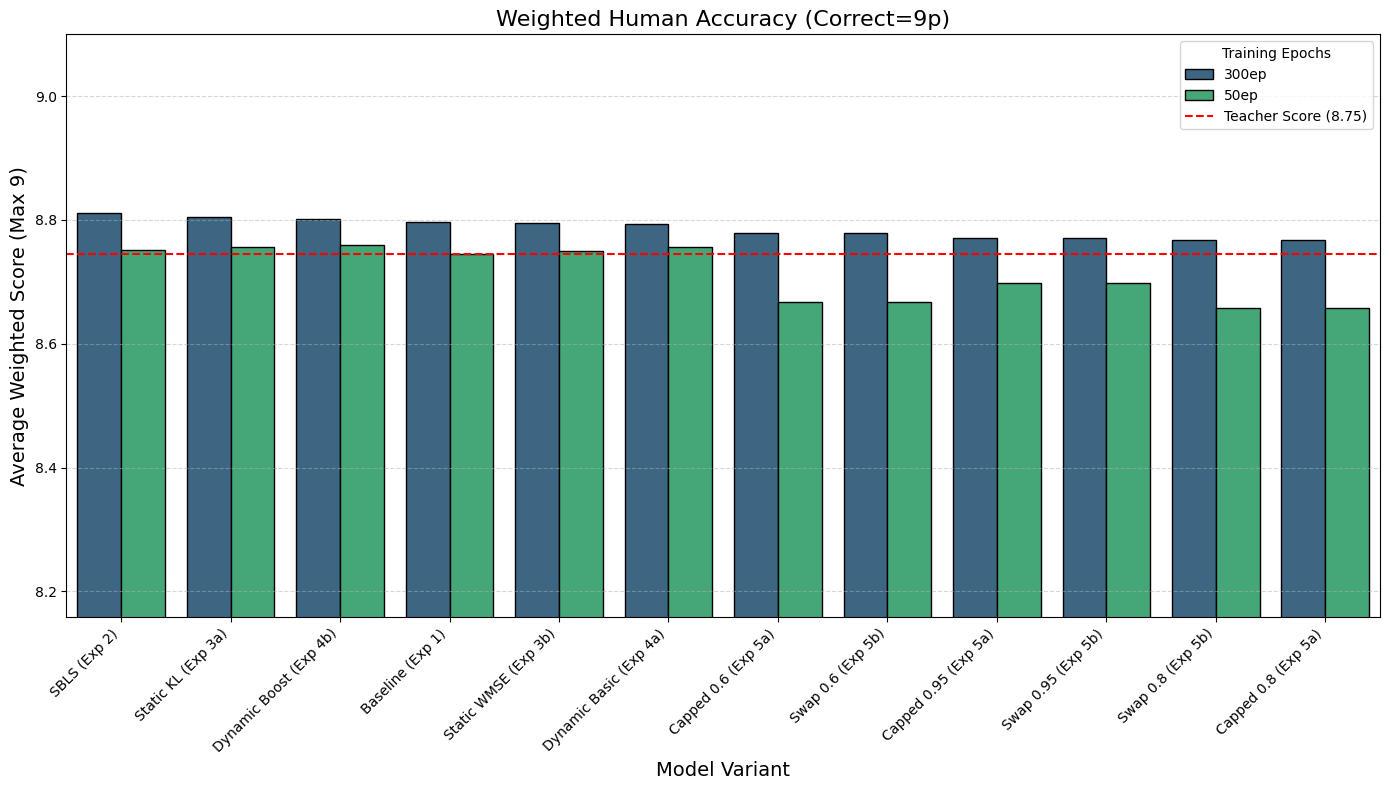

Scatterplot lagret til: artifacts/human_weighted_accuracy_9p/acc_vs_weighted_score_scatter.png


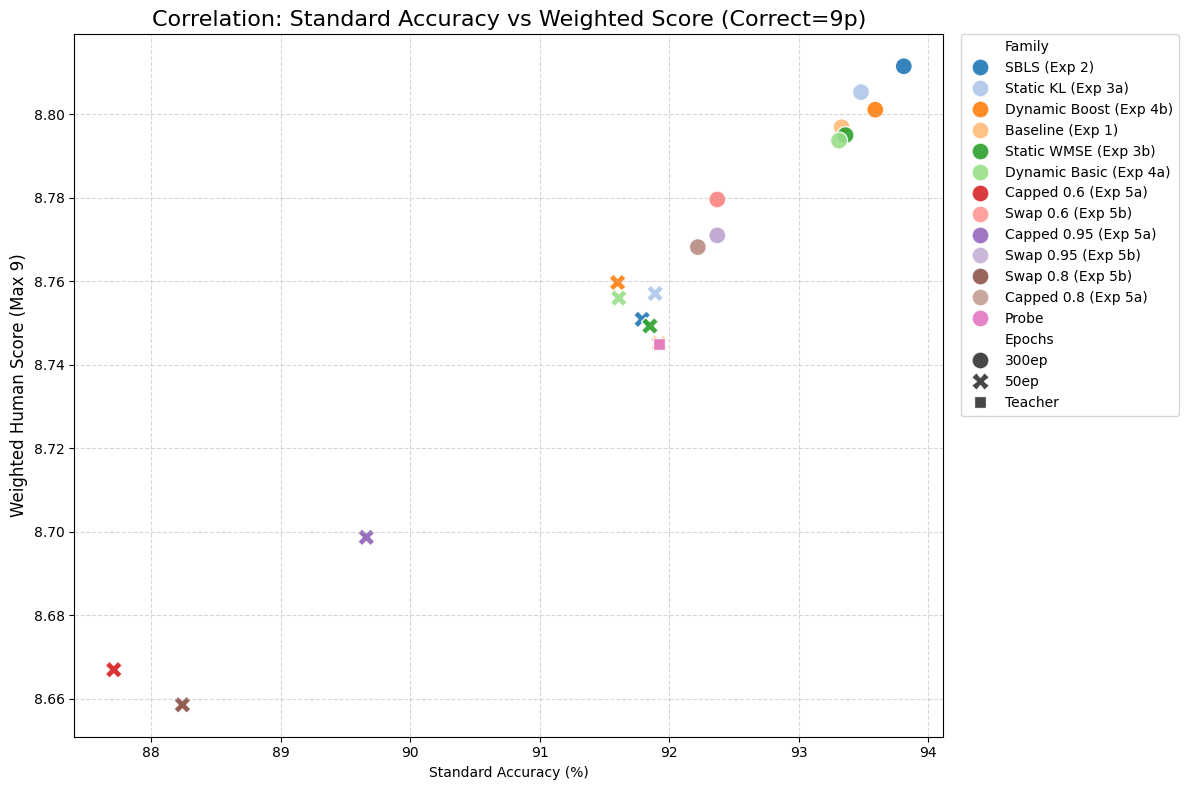

In [28]:
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASJON
# ==========================================
DATA_DIR = Path("./data")
# Ny mappe for dette eksperimentet (9 poeng)
ARTIFACTS_DIR = Path("./artifacts/human_weighted_accuracy_9p")
CKPT_DIR = Path("./checkpoints")
JSON_PATH = Path("human_similarity_ranking.json")

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 10
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# ==========================================
# 2. DEFINISJON AV ALLE MODELLER
# ==========================================
POSSIBLE_MODELS = {
    # --- Referanser ---
    "Probe (Teacher)":                    "probe_best.pth",
    
    # --- Exp 1: Baseline ---
    "Baseline (Exp 1) - 50ep":            "02_exp1_baseline_epoch50.pth",
    "Baseline (Exp 1) - 300ep":           "02_exp1_baseline_best.pth",
    
    # --- Exp 2: SBLS ---
    "SBLS (Exp 2) - 50ep":                "03_exp2_sbls_50ep_best.pth",
    "SBLS (Exp 2) - 300ep":               "03_exp2_sbls_300ep_best.pth",
    
    # --- Exp 3: Static Targets ---
    "Static KL (Exp 3a) - 50ep":          "04_exp3a_static_probs_50ep_best.pth",
    "Static KL (Exp 3a) - 300ep":         "04_exp3a_static_probs_300ep_best.pth",
    "Static WMSE (Exp 3b) - 50ep":        "05_exp3b_static_logits_50ep_best.pth",
    "Static WMSE (Exp 3b) - 300ep":       "05_exp3b_static_logits_300ep_best.pth",
    
    # --- Exp 4: Dynamic Targets ---
    "Dynamic Basic (Exp 4a) - 50ep":      "06_exp4a_dynamic_basic_50ep_best.pth",
    "Dynamic Basic (Exp 4a) - 300ep":     "06_exp4a_dynamic_basic_300ep_best.pth",
    "Dynamic Boost (Exp 4b) - 50ep":      "07_exp4b_dynamic_boost_50ep_best.pth",
    "Dynamic Boost (Exp 4b) - 300ep":     "07_exp4b_dynamic_boost_300ep_best.pth",
    
    # --- Exp 5a: Capped (Alle caps) ---
    "Capped 0.6 (Exp 5a) - 50ep":         "08_exp5a_capped_run_50ep_cap0.6_best.pth",
    "Capped 0.6 (Exp 5a) - 300ep":        "08_exp5a_capped_run_300ep_cap0.6_best.pth",
    
    "Capped 0.8 (Exp 5a) - 50ep":         "08_exp5a_capped_run_50ep_cap0.8_best.pth",
    "Capped 0.8 (Exp 5a) - 300ep":        "08_exp5a_capped_run_300ep_cap0.8_best.pth",
    
    "Capped 0.95 (Exp 5a) - 50ep":        "08_exp5a_capped_run_50ep_cap0.95_best.pth",
    "Capped 0.95 (Exp 5a) - 300ep":       "08_exp5a_capped_run_300ep_cap0.95_best.pth",
    
    # --- Exp 5b: Capped + Swap (Alle caps) ---
    "Swap 0.6 (Exp 5b) - 50ep":           "09_exp5b_capped_swap_run_50ep_cap0.6_best.pth",
    "Swap 0.6 (Exp 5b) - 300ep":          "09_exp5b_capped_swap_run_300ep_cap0.6_best.pth",
    
    "Swap 0.8 (Exp 5b) - 50ep":           "09_exp5b_capped_swap_run_50ep_cap0.8_best.pth",
    "Swap 0.8 (Exp 5b) - 300ep":          "09_exp5b_capped_swap_run_300ep_cap0.8_best.pth",
    
    "Swap 0.95 (Exp 5b) - 50ep":          "09_exp5b_capped_swap_run_50ep_cap0.95_best.pth",
    "Swap 0.95 (Exp 5b) - 300ep":         "09_exp5b_capped_swap_run_300ep_cap0.95_best.pth"
}

# ==========================================
# 3. OPPSETT AV DATA & MODELL
# ==========================================
def make_cifar_resnet18(num_classes=10):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def get_test_loader():
    test_tf = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)
    return DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==========================================
# 4. LASTE SCORINGSMATRISE (MED 9 POENG FOR RETT SVAR)
# ==========================================
def load_weighted_score_matrix(json_path):
    """
    Laster human_similarity_ranking.json.
    - Diagonalen (Rett svar) settes til 9.0 poeng.
    - Feil svar får poeng fra JSON-filen (0-10, men i praksis lavere).
    """
    # Start med nuller
    score_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    
    # 1. Sett diagonalen til 9 (Ny Max score for rett svar)
    for i in range(NUM_CLASSES):
        score_matrix[i, i] = 9.0  # <--- ENDRING HER
    
    # 2. Fyll inn poeng for feil svar fra JSON
    if not json_path.exists():
        print(f"⚠️  ADVARSEL: Fant ikke {json_path}. Bruker kun diagonal (Acc).")
        return score_matrix

    with open(json_path, "r") as f:
        data = json.load(f)
    
    wins_data = data.get("wins", {})
    
    for true_idx, true_name in enumerate(CIFAR10_CLASSES):
        if true_name not in wins_data: continue
        for pred_idx, pred_name in enumerate(CIFAR10_CLASSES):
            if true_idx == pred_idx: continue # Allerede satt til 9
            
            # Hent poeng for feilen
            points = wins_data[true_name].get(pred_name, 0)
            score_matrix[true_idx, pred_idx] = points

    print(f"✅ Weighted Score Matrix lastet. Rett svar = 9p, Feil svar = JSON poeng.")
    return score_matrix

# ==========================================
# 5. EVALUERINGSLØKKE
# ==========================================
def evaluate_models(models_dict, loader, score_matrix):
    results = []
    
    print(f"\nStarter evaluering av {len(models_dict)} modeller...")
    print("Metrikk: Total Weighted Score (Avg per bilde, Max=9)")
    
    # Hent targets (fasit) en gang for alle
    all_targets = []
    for _, y in loader:
        all_targets.append(y.to(DEVICE))
    all_targets = torch.cat(all_targets)
    
    for name, filename in tqdm(models_dict.items(), desc="Evaluerer"):
        ckpt_path = CKPT_DIR / filename
        
        # Sjekk om fil finnes
        if not ckpt_path.exists():
            if Path(filename).exists(): ckpt_path = Path(filename)
            else: continue
            
        # Last modell
        model = make_cifar_resnet18(NUM_CLASSES).to(DEVICE)
        try:
            model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
        except Exception:
            continue
            
        model.eval()
        all_preds = []
        
        with torch.no_grad():
            for x, _ in loader:
                x = x.to(DEVICE)
                logits = model(x)
                all_preds.append(logits.argmax(dim=1))
        
        all_preds = torch.cat(all_preds)
        
        # --- BEREGN SCORE ---
        # score_matrix[true_class, pred_class] gir poengene for hvert bilde
        scores = score_matrix[all_targets, all_preds]
        
        # Gjennomsnittlig score (Weighted Accuracy)
        avg_score = scores.mean().item()
        
        # Standard Accuracy (for referanse)
        acc = (all_preds == all_targets).float().mean().item() * 100
        
        # Parse navn for gruppering
        if "Probe" in name:
            family = "Probe"
            epochs = "Teacher"
        else:
            parts = name.split(" - ")
            family = parts[0]
            epochs = parts[1] if len(parts) > 1 else "Unknown"
            
        results.append({
            "Full Name": name,
            "Family": family,
            "Epochs": epochs,
            "Standard Accuracy (%)": acc,
            "Weighted Human Score (Max 9)": avg_score
        })
        
    return pd.DataFrame(results)

# ==========================================
# 6. PLOTTING OG LAGRING
# ==========================================
def run_weighted_analysis():
    # Last data
    score_matrix = load_weighted_score_matrix(JSON_PATH)
    loader = get_test_loader()
    
    # Evaluer
    df = evaluate_models(POSSIBLE_MODELS, loader, score_matrix)
    
    if df.empty:
        print("Ingen resultater å vise.")
        return

    # Sorter
    df = df.sort_values(by="Weighted Human Score (Max 9)", ascending=False)
    
    # Lagre CSV
    csv_path = ARTIFACTS_DIR / "weighted_human_accuracy_9p.csv"
    df.to_csv(csv_path, index=False)
    print(f"\nResultater lagret til: {csv_path}")
    
    # Print tabell
    print("\n" + "="*80)
    print("RESULTAT: WEIGHTED HUMAN ACCURACY (Rett=9p, Feil=Likhetspoeng)")
    print("-" * 80)
    print(df[["Full Name", "Standard Accuracy (%)", "Weighted Human Score (Max 9)"]].to_string(index=False, float_format="%.3f"))
    print("="*80)

    # --- PLOT 1: GROUPED BAR CHART (Epoch Comparison) ---
    plt.figure(figsize=(14, 8))
    
    # Filtrer vekk Probe for dette plottet for å sammenligne treningsmetoder renere
    plot_df = df[df["Family"] != "Probe"]
    
    sns.barplot(
        data=plot_df,
        x="Family",
        y="Weighted Human Score (Max 9)",
        hue="Epochs",
        palette="viridis",
        edgecolor="black"
    )
    
    # Legg til linje for Probe (Teacher) Score hvis den finnes
    probe_row = df[df["Family"] == "Probe"]
    if not probe_row.empty:
        probe_score = probe_row["Weighted Human Score (Max 9)"].values[0]
        plt.axhline(y=probe_score, color='red', linestyle='--', label=f'Teacher Score ({probe_score:.2f})')
    
    plt.title("Weighted Human Accuracy (Correct=9p)", fontsize=16)
    plt.ylabel("Average Weighted Score (Max 9)", fontsize=14)
    plt.xlabel("Model Variant", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Training Epochs")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Juster Y-akse for å zoome inn på toppen (men med tak på 9.1)
    min_score = df["Weighted Human Score (Max 9)"].min()
    plt.ylim(bottom=min_score - 0.5, top=9.1) 
    plt.tight_layout()
    
    plot_path_bar = ARTIFACTS_DIR / "weighted_score_comparison_bar.png"
    plt.savefig(plot_path_bar, dpi=150)
    print(f"Barplot lagret til: {plot_path_bar}")
    plt.show()

    # --- PLOT 2: SCATTER (Acc vs Weighted Score) ---
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x="Standard Accuracy (%)",
        y="Weighted Human Score (Max 9)",
        hue="Family",
        style="Epochs",
        s=150,
        palette="tab20",
        alpha=0.9
    )
    
    plt.title("Correlation: Standard Accuracy vs Weighted Score (Correct=9p)", fontsize=16)
    plt.ylabel("Weighted Human Score (Max 9)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    
    plot_path_scatter = ARTIFACTS_DIR / "acc_vs_weighted_score_scatter.png"
    plt.savefig(plot_path_scatter, dpi=150)
    print(f"Scatterplot lagret til: {plot_path_scatter}")
    plt.show()

if __name__ == "__main__":
    run_weighted_analysis()